In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)

# Set experiment parameters

In [4]:
z_dim = 10
run_id = 42
experiment_name = "semi_supervised_random"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]
budget = 0.1919 / 5
budget = 0
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=5,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_ACTUAL,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID",
                               budget=budget
                             )
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [5]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

In [6]:
budget

0

# Train model

In [7]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                                                                     z_dim=z_dim,
                                                                                     run_id=run_id,
                                                                                     create_split=create_split,
                                                                                     num_epochs=num_epochs,
                                                                                     num_cluster_config=num_cluster_config,
                                                                                     model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                     budget=budget,
                                                                                     manual_labels_config=ExperimentConfig.USE_ACTUAL,
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_ACTUAL', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 0, 'RUN_ID': 42, 'ID': 1, 'name': 'semi_supervised_random'}
Using labels of 0 samples
Number of samples with manual annotation 0.0



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the construct

Epoch: 0/47, Nll_loss : 204.60528564453125 KLD:1.1593073606491089  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 207.25469970703125 KLD:1.0346559286117554  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 215.49002075195312 KLD:0.9331054091453552  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 209.29373168945312 KLD:1.0185763835906982  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 209.33282470703125 KLD:1.0555288791656494  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 204.63539123535156 KLD:1.2282800674438477  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 202.79837036132812 KLD:1.3332366943359375  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 214.10426330566406 KLD:1.4427706003189087  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 213.94134521484375 KLD:1.3210618495941162  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 211.50253295898438 KLD:1.228969693183899  Supervised loss:0.0
Epoch: 0/57, Nll_loss : 223.39877319335938 KLD:1.190394401550293  Supervised loss:0.0
Epoch: 0/58, Nll_loss : 205.15481567382812 KL

Epoch: 0/142, Nll_loss : 193.4429168701172 KLD:2.165675640106201  Supervised loss:0.0
Epoch: 0/143, Nll_loss : 188.39407348632812 KLD:2.3264691829681396  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 185.98745727539062 KLD:2.2756271362304688  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 181.52635192871094 KLD:2.0948896408081055  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 181.4541015625 KLD:2.2975032329559326  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 185.68777465820312 KLD:2.5829315185546875  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 187.98751831054688 KLD:2.5788564682006836  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 181.6063232421875 KLD:2.437668561935425  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 191.81845092773438 KLD:2.3181629180908203  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 179.6739959716797 KLD:2.140380859375  Supervised loss:0.0
Epoch: 0/152, Nll_loss : 183.08514404296875 KLD:2.0068910121917725  Supervised loss:0.0
Epoch: 0/153, Nll_loss : 181.6074981689453 KL

Epoch: 0/238, Nll_loss : 161.37637329101562 KLD:4.001431465148926  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 157.55870056152344 KLD:4.379364490509033  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 155.64990234375 KLD:4.107065677642822  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 163.04798889160156 KLD:4.25844669342041  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 162.49734497070312 KLD:4.220886707305908  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 156.222412109375 KLD:3.944524049758911  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 165.57565307617188 KLD:4.13667631149292  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 169.25750732421875 KLD:4.126088619232178  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 168.62088012695312 KLD:3.9979825019836426  Supervised loss:0.0
Epoch: 0/247, Nll_loss : 163.73971557617188 KLD:4.143004417419434  Supervised loss:0.0
Epoch: 0/248, Nll_loss : 164.52745056152344 KLD:3.8779876232147217  Supervised loss:0.0
Epoch: 0/249, Nll_loss : 159.19760131835938 KLD:

Epoch: 0/334, Nll_loss : 158.24574279785156 KLD:4.931251049041748  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 153.72933959960938 KLD:4.619782447814941  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 156.3026580810547 KLD:4.912951469421387  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 157.86419677734375 KLD:4.831742763519287  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 154.91506958007812 KLD:4.718863487243652  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 160.84710693359375 KLD:4.876961708068848  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 154.39688110351562 KLD:4.878387451171875  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 148.91046142578125 KLD:5.232444763183594  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 148.20094299316406 KLD:4.808883190155029  Supervised loss:0.0
Epoch: 0/343, Nll_loss : 147.62428283691406 KLD:4.910348415374756  Supervised loss:0.0
Epoch: 0/344, Nll_loss : 160.17823791503906 KLD:5.383779525756836  Supervised loss:0.0
Epoch: 0/345, Nll_loss : 145.67861938476562 

Epoch: 0/430, Nll_loss : 153.47039794921875 KLD:5.387980937957764  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 140.8459930419922 KLD:5.072761058807373  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 148.4683837890625 KLD:5.2688984870910645  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 152.01077270507812 KLD:5.451845645904541  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 148.22935485839844 KLD:5.227648735046387  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 144.92886352539062 KLD:4.987421035766602  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 150.94970703125 KLD:5.533271789550781  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 156.3809051513672 KLD:5.2227630615234375  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 145.92559814453125 KLD:5.44605827331543  Supervised loss:0.0
Epoch: 0/439, Nll_loss : 140.90818786621094 KLD:5.27565860748291  Supervised loss:0.0
Epoch: 0/440, Nll_loss : 156.71800231933594 KLD:5.380428314208984  Supervised loss:0.0
Epoch: 0/441, Nll_loss : 146.28146362304688 KLD:5

Epoch: 0/525, Nll_loss : 142.60479736328125 KLD:5.664580345153809  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 135.95120239257812 KLD:5.414649963378906  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 141.39016723632812 KLD:5.54121208190918  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 130.8359375 KLD:5.535945892333984  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 143.54904174804688 KLD:5.657831192016602  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 141.3037109375 KLD:5.672782897949219  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 137.78427124023438 KLD:5.820151329040527  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 146.95245361328125 KLD:5.964611053466797  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 143.61500549316406 KLD:5.946396827697754  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 154.0078887939453 KLD:5.766417503356934  Supervised loss:0.0
Epoch: 0/535, Nll_loss : 137.14332580566406 KLD:5.519864082336426  Supervised loss:0.0
Epoch: 0/536, Nll_loss : 135.5435028076172 KLD:5.8412494

Epoch: 0/620, Nll_loss : 140.6847381591797 KLD:5.904326438903809  Supervised loss:0.0
Epoch: 0/621, Nll_loss : 147.05502319335938 KLD:5.673910140991211  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 135.94583129882812 KLD:5.577802658081055  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 134.04115295410156 KLD:5.731341361999512  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 145.80648803710938 KLD:5.659626007080078  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 147.67897033691406 KLD:5.616243839263916  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 148.499267578125 KLD:5.469740867614746  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 135.2204132080078 KLD:5.464577674865723  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 139.6013946533203 KLD:5.633460521697998  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 139.42990112304688 KLD:5.827364444732666  Supervised loss:0.0
Epoch: 0/630, Nll_loss : 139.1995849609375 KLD:6.022000312805176  Supervised loss:0.0
Epoch: 0/631, Nll_loss : 137.9164581298828 KLD:5.

Epoch: 0/716, Nll_loss : 134.69503784179688 KLD:6.205061912536621  Supervised loss:0.0
Epoch: 0/717, Nll_loss : 143.69595336914062 KLD:6.692999839782715  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 130.87265014648438 KLD:6.226380348205566  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 140.04348754882812 KLD:6.101098537445068  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 135.551025390625 KLD:6.346844673156738  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 139.77157592773438 KLD:5.984196662902832  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 132.15557861328125 KLD:5.936355113983154  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 136.04075622558594 KLD:6.021108627319336  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 144.77166748046875 KLD:5.997118949890137  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 138.19297790527344 KLD:5.810032844543457  Supervised loss:0.0
Epoch: 0/726, Nll_loss : 138.06968688964844 KLD:5.776641845703125  Supervised loss:0.0
Epoch: 0/727, Nll_loss : 136.04876708984375 K

Epoch: 0/812, Nll_loss : 136.15884399414062 KLD:5.873732566833496  Supervised loss:0.0
Epoch: 0/813, Nll_loss : 137.16162109375 KLD:5.764187812805176  Supervised loss:0.0
Epoch: 0/814, Nll_loss : 131.28713989257812 KLD:5.64472770690918  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 141.21109008789062 KLD:5.811537742614746  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 139.80230712890625 KLD:5.748085975646973  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 141.358154296875 KLD:5.733624458312988  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 123.01202392578125 KLD:6.061404228210449  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 144.55270385742188 KLD:6.493345260620117  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 135.38925170898438 KLD:6.429703712463379  Supervised loss:0.0
Epoch: 0/821, Nll_loss : 149.69293212890625 KLD:6.4028778076171875  Supervised loss:0.0
Epoch: 0/822, Nll_loss : 135.306640625 KLD:6.183752059936523  Supervised loss:0.0
Epoch: 0/823, Nll_loss : 140.39247131347656 KLD:6.512

Epoch: 0/908, Nll_loss : 133.856689453125 KLD:6.414941787719727  Supervised loss:0.0
Epoch: 0/909, Nll_loss : 131.2206573486328 KLD:6.118993759155273  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 140.94793701171875 KLD:6.452701568603516  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 128.763916015625 KLD:6.118280410766602  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 140.62388610839844 KLD:5.820478439331055  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 131.74111938476562 KLD:6.028224468231201  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 139.04476928710938 KLD:6.0142822265625  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 145.9571533203125 KLD:5.738164901733398  Supervised loss:0.0
Epoch: 0/916, Nll_loss : 138.14248657226562 KLD:5.888082504272461  Supervised loss:0.0
Epoch: 0/917, Nll_loss : 129.95684814453125 KLD:6.296816825866699  Supervised loss:0.0
Epoch: 0/918, Nll_loss : 144.5640106201172 KLD:6.155351638793945  Supervised loss:0.0
Epoch: 0/919, Nll_loss : 131.06671142578125 KLD:6.57

# Load the trained model

In [8]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_random/Exp_32_128_64_10_ELBOW_42/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [9]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=42 z_min=-4.3917003 z_max=4.743851
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [10]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Iteration 2

In [11]:
budget = 0.1919 / 5
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        budget=budget,
                                        manual_labels_config=ExperimentConfig.USE_ACTUAL,
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_ACTUAL', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 0.03838, 'RUN_ID': 42, 'ID': 1, 'name': 'semi_supervised_random'}
Using labels of 2297 samples
Number of samples with manual annotation 1607.9
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
IN

Epoch: 1/69, Nll_loss : 155.62472534179688 KLD:12.322851181030273  Supervised loss:1.7397410869598389
Epoch: 1/70, Nll_loss : 162.6982421875 KLD:12.25567626953125  Supervised loss:1.1025440692901611
Epoch: 1/71, Nll_loss : 150.25466918945312 KLD:13.406044006347656  Supervised loss:2.0405030250549316
Epoch: 1/72, Nll_loss : 155.23878479003906 KLD:12.142160415649414  Supervised loss:0.43988037109375
Epoch: 1/73, Nll_loss : 161.91555786132812 KLD:11.104223251342773  Supervised loss:0.6701830625534058
Epoch: 1/74, Nll_loss : 161.07533264160156 KLD:11.05427360534668  Supervised loss:1.0904570817947388
Epoch: 1/75, Nll_loss : 169.4354705810547 KLD:10.366116523742676  Supervised loss:0.6199603080749512
Epoch: 1/76, Nll_loss : 159.2030487060547 KLD:9.014609336853027  Supervised loss:2.4923624992370605
Epoch: 1/77, Nll_loss : 160.08905029296875 KLD:9.673023223876953  Supervised loss:0.8851990699768066
Epoch: 1/78, Nll_loss : 164.18984985351562 KLD:7.3045806884765625  Supervised loss:1.486645817

Epoch: 1/152, Nll_loss : 152.55914306640625 KLD:11.896322250366211  Supervised loss:0.43784841895103455
Epoch: 1/153, Nll_loss : 149.6422119140625 KLD:11.498947143554688  Supervised loss:0.5226181745529175
Epoch: 1/154, Nll_loss : 149.65814208984375 KLD:12.327911376953125  Supervised loss:1.570955514907837
Epoch: 1/155, Nll_loss : 155.6749267578125 KLD:12.5796480178833  Supervised loss:0.5861656665802002
Epoch: 1/156, Nll_loss : 157.61383056640625 KLD:11.065441131591797  Supervised loss:1.410203456878662
Epoch: 1/157, Nll_loss : 151.19232177734375 KLD:11.581981658935547  Supervised loss:0.5733882188796997
Epoch: 1/158, Nll_loss : 156.24847412109375 KLD:11.325871467590332  Supervised loss:1.3604635000228882
Epoch: 1/159, Nll_loss : 150.75296020507812 KLD:10.819792747497559  Supervised loss:0.44420528411865234
Epoch: 1/160, Nll_loss : 164.3033905029297 KLD:12.005181312561035  Supervised loss:1.264445185661316
Epoch: 1/161, Nll_loss : 167.65382385253906 KLD:11.007568359375  Supervised los

Epoch: 1/234, Nll_loss : 145.43894958496094 KLD:12.689021110534668  Supervised loss:0.4521026313304901
Epoch: 1/235, Nll_loss : 149.03994750976562 KLD:11.178361892700195  Supervised loss:0.6736413240432739
Epoch: 1/236, Nll_loss : 149.63365173339844 KLD:10.734420776367188  Supervised loss:0.5217964053153992
Epoch: 1/237, Nll_loss : 149.39935302734375 KLD:11.769989967346191  Supervised loss:0.9071542024612427
Epoch: 1/238, Nll_loss : 155.09231567382812 KLD:9.459696769714355  Supervised loss:0.8002493381500244
Epoch: 1/239, Nll_loss : 150.55572509765625 KLD:10.528021812438965  Supervised loss:0.5050203204154968
Epoch: 1/240, Nll_loss : 149.7960205078125 KLD:11.464656829833984  Supervised loss:0.12270881980657578
Epoch: 1/241, Nll_loss : 140.84341430664062 KLD:11.539214134216309  Supervised loss:0.455967515707016
Epoch: 1/242, Nll_loss : 147.39247131347656 KLD:11.795748710632324  Supervised loss:0.2698574960231781
Epoch: 1/243, Nll_loss : 145.46926879882812 KLD:11.775941848754883  Supervi

Epoch: 1/317, Nll_loss : 140.17120361328125 KLD:11.525777816772461  Supervised loss:0.3610198497772217
Epoch: 1/318, Nll_loss : 140.29135131835938 KLD:11.65134048461914  Supervised loss:0.6384602189064026
Epoch: 1/319, Nll_loss : 133.5009765625 KLD:13.103520393371582  Supervised loss:0.48715758323669434
Epoch: 1/320, Nll_loss : 141.7962646484375 KLD:13.573797225952148  Supervised loss:0.1402750015258789
Epoch: 1/321, Nll_loss : 138.65541076660156 KLD:11.837224960327148  Supervised loss:1.6065415143966675
Epoch: 1/322, Nll_loss : 139.53665161132812 KLD:12.527624130249023  Supervised loss:0.34613779187202454
Epoch: 1/323, Nll_loss : 138.1472930908203 KLD:12.162943840026855  Supervised loss:0.6839437484741211
Epoch: 1/324, Nll_loss : 139.07618713378906 KLD:11.480671882629395  Supervised loss:0.519736647605896
Epoch: 1/325, Nll_loss : 140.9942626953125 KLD:11.45374584197998  Supervised loss:0.5062506794929504
Epoch: 1/326, Nll_loss : 134.23977661132812 KLD:11.122980117797852  Supervised lo

Epoch: 1/399, Nll_loss : 149.83059692382812 KLD:11.89796257019043  Supervised loss:0.05415293946862221
Epoch: 1/400, Nll_loss : 152.67172241210938 KLD:11.1757230758667  Supervised loss:1.0279955863952637
Epoch: 1/401, Nll_loss : 137.74728393554688 KLD:12.393214225769043  Supervised loss:0.4595843255519867
Epoch: 1/402, Nll_loss : 132.96775817871094 KLD:12.214447021484375  Supervised loss:0.10146904736757278
Epoch: 1/403, Nll_loss : 140.73370361328125 KLD:11.932903289794922  Supervised loss:0.9173786640167236
Epoch: 1/404, Nll_loss : 140.05764770507812 KLD:12.400103569030762  Supervised loss:0.27416297793388367
Epoch: 1/405, Nll_loss : 135.14491271972656 KLD:11.706537246704102  Supervised loss:0.8524399399757385
Epoch: 1/406, Nll_loss : 137.11302185058594 KLD:12.168092727661133  Supervised loss:0.5825684070587158
Epoch: 1/407, Nll_loss : 141.57188415527344 KLD:11.963895797729492  Supervised loss:0.10493995249271393
Epoch: 1/408, Nll_loss : 138.1305389404297 KLD:11.581808090209961  Super

Epoch: 1/481, Nll_loss : 133.81639099121094 KLD:12.026599884033203  Supervised loss:0.33953171968460083
Epoch: 1/482, Nll_loss : 140.21694946289062 KLD:13.043903350830078  Supervised loss:0.5076693892478943
Epoch: 1/483, Nll_loss : 138.33094787597656 KLD:12.08415412902832  Supervised loss:0.06399711966514587
Epoch: 1/484, Nll_loss : 139.5716552734375 KLD:12.191431999206543  Supervised loss:0.5949123501777649
Epoch: 1/485, Nll_loss : 135.633056640625 KLD:12.065713882446289  Supervised loss:0.927222728729248
Epoch: 1/486, Nll_loss : 133.33056640625 KLD:12.969974517822266  Supervised loss:0.4013127386569977
Epoch: 1/487, Nll_loss : 141.11856079101562 KLD:12.178274154663086  Supervised loss:0.6040319800376892
Epoch: 1/488, Nll_loss : 143.03880310058594 KLD:10.295364379882812  Supervised loss:0.9571835398674011
Epoch: 1/489, Nll_loss : 144.99728393554688 KLD:11.393867492675781  Supervised loss:1.5126019716262817
Epoch: 1/490, Nll_loss : 141.837890625 KLD:11.405454635620117  Supervised loss:

Epoch: 1/563, Nll_loss : 141.5274658203125 KLD:10.476245880126953  Supervised loss:0.46544212102890015
Epoch: 1/564, Nll_loss : 139.97178649902344 KLD:11.418216705322266  Supervised loss:0.46330738067626953
Epoch: 1/565, Nll_loss : 142.90606689453125 KLD:10.680400848388672  Supervised loss:0.9201924204826355
Epoch: 1/566, Nll_loss : 127.73043823242188 KLD:11.266780853271484  Supervised loss:1.1124175786972046
Epoch: 1/567, Nll_loss : 142.74057006835938 KLD:11.097367286682129  Supervised loss:0.2836938202381134
Epoch: 1/568, Nll_loss : 136.85560607910156 KLD:11.091958045959473  Supervised loss:0.494620144367218
Epoch: 1/569, Nll_loss : 133.6506805419922 KLD:10.896120071411133  Supervised loss:0.0
Epoch: 1/570, Nll_loss : 148.22900390625 KLD:11.272242546081543  Supervised loss:0.14607036113739014
Epoch: 1/571, Nll_loss : 137.66415405273438 KLD:11.247573852539062  Supervised loss:0.1881093978881836
Epoch: 1/572, Nll_loss : 141.19122314453125 KLD:10.612728118896484  Supervised loss:0.08483

Epoch: 1/646, Nll_loss : 129.7978515625 KLD:12.812673568725586  Supervised loss:0.3044533431529999
Epoch: 1/647, Nll_loss : 145.031005859375 KLD:10.889472961425781  Supervised loss:0.0494549535214901
Epoch: 1/648, Nll_loss : 138.17408752441406 KLD:11.947202682495117  Supervised loss:0.0
Epoch: 1/649, Nll_loss : 142.5665283203125 KLD:11.912662506103516  Supervised loss:0.30450135469436646
Epoch: 1/650, Nll_loss : 140.9650115966797 KLD:12.685016632080078  Supervised loss:0.4331056475639343
Epoch: 1/651, Nll_loss : 137.37478637695312 KLD:11.297794342041016  Supervised loss:0.0
Epoch: 1/652, Nll_loss : 146.6514892578125 KLD:11.303418159484863  Supervised loss:0.3216789662837982
Epoch: 1/653, Nll_loss : 135.062744140625 KLD:11.790721893310547  Supervised loss:0.44593167304992676
Epoch: 1/654, Nll_loss : 138.63458251953125 KLD:11.416919708251953  Supervised loss:0.07802965492010117
Epoch: 1/655, Nll_loss : 139.1744842529297 KLD:10.869831085205078  Supervised loss:0.829911470413208
Epoch: 1/6

Epoch: 1/728, Nll_loss : 133.54754638671875 KLD:14.43016242980957  Supervised loss:0.38725602626800537
Epoch: 1/729, Nll_loss : 132.6363525390625 KLD:13.688291549682617  Supervised loss:0.29329198598861694
Epoch: 1/730, Nll_loss : 126.91219329833984 KLD:12.467360496520996  Supervised loss:0.13806889951229095
Epoch: 1/731, Nll_loss : 133.77835083007812 KLD:12.820487976074219  Supervised loss:0.06531450897455215
Epoch: 1/732, Nll_loss : 124.41651153564453 KLD:13.399796485900879  Supervised loss:0.0755208358168602
Epoch: 1/733, Nll_loss : 132.87806701660156 KLD:12.31993579864502  Supervised loss:0.33596399426460266
Epoch: 1/734, Nll_loss : 138.6019287109375 KLD:12.15694522857666  Supervised loss:1.3497135639190674
Epoch: 1/735, Nll_loss : 139.54440307617188 KLD:11.513921737670898  Supervised loss:0.3716493248939514
Epoch: 1/736, Nll_loss : 135.78961181640625 KLD:12.172842025756836  Supervised loss:1.0571907758712769
Epoch: 1/737, Nll_loss : 126.63186645507812 KLD:11.751934051513672  Super

Epoch: 1/809, Nll_loss : 128.84848022460938 KLD:12.284125328063965  Supervised loss:0.7359051704406738
Epoch: 1/810, Nll_loss : 139.5159454345703 KLD:11.832016944885254  Supervised loss:0.8256444931030273
Epoch: 1/811, Nll_loss : 140.85479736328125 KLD:12.176678657531738  Supervised loss:0.19714589416980743
Epoch: 1/812, Nll_loss : 138.56884765625 KLD:11.055021286010742  Supervised loss:0.22750233113765717
Epoch: 1/813, Nll_loss : 136.9686279296875 KLD:12.664932250976562  Supervised loss:0.17342016100883484
Epoch: 1/814, Nll_loss : 132.7443084716797 KLD:11.12042236328125  Supervised loss:0.19489289820194244
Epoch: 1/815, Nll_loss : 130.25564575195312 KLD:12.322592735290527  Supervised loss:0.19353610277175903
Epoch: 1/816, Nll_loss : 139.56939697265625 KLD:12.188545227050781  Supervised loss:0.09391637146472931
Epoch: 1/817, Nll_loss : 134.23924255371094 KLD:11.879179000854492  Supervised loss:0.0
Epoch: 1/818, Nll_loss : 135.7208251953125 KLD:11.376502990722656  Supervised loss:0.1095

Epoch: 1/892, Nll_loss : 145.4932861328125 KLD:11.138663291931152  Supervised loss:0.6426661610603333
Epoch: 1/893, Nll_loss : 129.94839477539062 KLD:12.260408401489258  Supervised loss:0.5454123020172119
Epoch: 1/894, Nll_loss : 125.2939453125 KLD:11.948199272155762  Supervised loss:0.29604870080947876
Epoch: 1/895, Nll_loss : 128.6008758544922 KLD:11.372745513916016  Supervised loss:0.6624612808227539
Epoch: 1/896, Nll_loss : 144.16920471191406 KLD:12.39842414855957  Supervised loss:0.331373393535614
Epoch: 1/897, Nll_loss : 135.951171875 KLD:12.868560791015625  Supervised loss:0.22207170724868774
Epoch: 1/898, Nll_loss : 138.40379333496094 KLD:12.17614459991455  Supervised loss:0.16338026523590088
Epoch: 1/899, Nll_loss : 129.691162109375 KLD:12.46044921875  Supervised loss:1.1423779726028442
Epoch: 1/900, Nll_loss : 125.51325988769531 KLD:13.342784881591797  Supervised loss:0.11041689664125443
Epoch: 1/901, Nll_loss : 126.96769714355469 KLD:12.711944580078125  Supervised loss:0.0
E

In [46]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_42/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


# Iteration 3

In [66]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [67]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [68]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        budget=budget,
                                        manual_labels_config=ExperimentConfig.USE_ACTUAL,

                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 42, 'ID': 1, 'name': 'semi_supervised_classification'}
Loaded manual annotation
Number of samples with manual confidence 57789
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tenso

Epoch: 2/65, Nll_loss : 122.93313598632812 KLD:11.261496543884277  Supervised loss:0.2934044599533081
Epoch: 2/66, Nll_loss : 110.0297622680664 KLD:10.860610961914062  Supervised loss:0.17453522980213165
Epoch: 2/67, Nll_loss : 115.47616577148438 KLD:10.197811126708984  Supervised loss:0.2534135580062866
Epoch: 2/68, Nll_loss : 123.60584259033203 KLD:10.360115051269531  Supervised loss:0.2516278624534607
Epoch: 2/69, Nll_loss : 127.99147033691406 KLD:10.170245170593262  Supervised loss:0.30937492847442627
Epoch: 2/70, Nll_loss : 120.18797302246094 KLD:10.037496566772461  Supervised loss:0.3087627589702606
Epoch: 2/71, Nll_loss : 122.84478759765625 KLD:9.651468276977539  Supervised loss:0.37255388498306274
Epoch: 2/72, Nll_loss : 126.42138671875 KLD:8.921406745910645  Supervised loss:0.3491012156009674
Epoch: 2/73, Nll_loss : 122.32363891601562 KLD:9.136043548583984  Supervised loss:0.25453269481658936
Epoch: 2/74, Nll_loss : 133.1538848876953 KLD:9.416031837463379  Supervised loss:0.24

Epoch: 2/146, Nll_loss : 115.39839172363281 KLD:10.349632263183594  Supervised loss:0.1452009379863739
Epoch: 2/147, Nll_loss : 122.83950805664062 KLD:10.13592529296875  Supervised loss:0.3159664273262024
Epoch: 2/148, Nll_loss : 132.9612579345703 KLD:10.063249588012695  Supervised loss:0.32039788365364075
Epoch: 2/149, Nll_loss : 116.38761138916016 KLD:10.15959358215332  Supervised loss:0.2656560242176056
Epoch: 2/150, Nll_loss : 127.69666290283203 KLD:10.178653717041016  Supervised loss:0.34079551696777344
Epoch: 2/151, Nll_loss : 120.81343078613281 KLD:9.92593002319336  Supervised loss:0.19128695130348206
Epoch: 2/152, Nll_loss : 120.65908813476562 KLD:9.526951789855957  Supervised loss:0.2296486347913742
Epoch: 2/153, Nll_loss : 116.49974060058594 KLD:9.83996295928955  Supervised loss:0.21465089917182922
Epoch: 2/154, Nll_loss : 126.25514221191406 KLD:9.648202896118164  Supervised loss:0.26689258217811584
Epoch: 2/155, Nll_loss : 132.59957885742188 KLD:9.585501670837402  Supervised

Epoch: 2/228, Nll_loss : 127.32744598388672 KLD:9.832775115966797  Supervised loss:0.2855719327926636
Epoch: 2/229, Nll_loss : 123.46133422851562 KLD:9.663707733154297  Supervised loss:0.17718134820461273
Epoch: 2/230, Nll_loss : 124.87619018554688 KLD:9.576126098632812  Supervised loss:0.2395392507314682
Epoch: 2/231, Nll_loss : 129.87347412109375 KLD:9.832525253295898  Supervised loss:0.2996503412723541
Epoch: 2/232, Nll_loss : 116.72258758544922 KLD:10.208894729614258  Supervised loss:0.28186219930648804
Epoch: 2/233, Nll_loss : 119.08456420898438 KLD:10.369029998779297  Supervised loss:0.24825440347194672
Epoch: 2/234, Nll_loss : 123.90959167480469 KLD:9.793094635009766  Supervised loss:0.2495562583208084
Epoch: 2/235, Nll_loss : 123.09770965576172 KLD:9.923788070678711  Supervised loss:0.2422371208667755
Epoch: 2/236, Nll_loss : 119.5653076171875 KLD:9.856258392333984  Supervised loss:0.22205494344234467
Epoch: 2/237, Nll_loss : 131.19187927246094 KLD:9.423347473144531  Supervised

Epoch: 2/310, Nll_loss : 129.40773010253906 KLD:9.736369132995605  Supervised loss:0.24903355538845062
Epoch: 2/311, Nll_loss : 129.4108428955078 KLD:9.877618789672852  Supervised loss:0.2327314019203186
Epoch: 2/312, Nll_loss : 126.51884460449219 KLD:10.32260513305664  Supervised loss:0.27813953161239624
Epoch: 2/313, Nll_loss : 125.80772399902344 KLD:10.04408073425293  Supervised loss:0.3295515179634094
Epoch: 2/314, Nll_loss : 114.90156555175781 KLD:10.024020195007324  Supervised loss:0.2436913102865219
Epoch: 2/315, Nll_loss : 117.33155822753906 KLD:10.066030502319336  Supervised loss:0.29006072878837585
Epoch: 2/316, Nll_loss : 115.79917907714844 KLD:10.082200050354004  Supervised loss:0.22150324285030365
Epoch: 2/317, Nll_loss : 116.37141418457031 KLD:10.090105056762695  Supervised loss:0.17233607172966003
Epoch: 2/318, Nll_loss : 117.17430114746094 KLD:10.081485748291016  Supervised loss:0.20654456317424774
Epoch: 2/319, Nll_loss : 119.39697265625 KLD:10.4908447265625  Supervise

Epoch: 2/392, Nll_loss : 121.14158630371094 KLD:9.82508373260498  Supervised loss:0.20138032734394073
Epoch: 2/393, Nll_loss : 127.36000061035156 KLD:10.309640884399414  Supervised loss:0.18750528991222382
Epoch: 2/394, Nll_loss : 118.9415054321289 KLD:10.23003101348877  Supervised loss:0.36782264709472656
Epoch: 2/395, Nll_loss : 120.07550811767578 KLD:9.887950897216797  Supervised loss:0.21793055534362793
Epoch: 2/396, Nll_loss : 114.87269592285156 KLD:10.572832107543945  Supervised loss:0.17186342179775238
Epoch: 2/397, Nll_loss : 112.56021118164062 KLD:9.965291976928711  Supervised loss:0.24207501113414764
Epoch: 2/398, Nll_loss : 127.80267333984375 KLD:10.476872444152832  Supervised loss:0.2233705371618271
Epoch: 2/399, Nll_loss : 124.00448608398438 KLD:10.306060791015625  Supervised loss:0.20275133848190308
Epoch: 2/400, Nll_loss : 123.67765808105469 KLD:10.035974502563477  Supervised loss:0.2778642773628235
Epoch: 2/401, Nll_loss : 112.64044189453125 KLD:10.340280532836914  Supe

Epoch: 2/472, Nll_loss : 123.33668518066406 KLD:9.894357681274414  Supervised loss:0.2791990041732788
Epoch: 2/473, Nll_loss : 114.09754943847656 KLD:10.131423950195312  Supervised loss:0.3410378098487854
Epoch: 2/474, Nll_loss : 119.26655578613281 KLD:9.80599308013916  Supervised loss:0.18645130097866058
Epoch: 2/475, Nll_loss : 120.47966003417969 KLD:9.927392959594727  Supervised loss:0.26112428307533264
Epoch: 2/476, Nll_loss : 119.54308319091797 KLD:10.246294021606445  Supervised loss:0.20001865923404694
Epoch: 2/477, Nll_loss : 121.59803771972656 KLD:9.936114311218262  Supervised loss:0.2969052493572235
Epoch: 2/478, Nll_loss : 120.73075103759766 KLD:9.960369110107422  Supervised loss:0.1845165491104126
Epoch: 2/479, Nll_loss : 126.47773742675781 KLD:9.968624114990234  Supervised loss:0.2051737904548645
Epoch: 2/480, Nll_loss : 117.08865356445312 KLD:9.992746353149414  Supervised loss:0.2708685100078583
Epoch: 2/481, Nll_loss : 123.47283935546875 KLD:9.906311988830566  Supervised 

Epoch: 2/553, Nll_loss : 123.41964721679688 KLD:10.037281036376953  Supervised loss:0.27084511518478394
Epoch: 2/554, Nll_loss : 122.41413879394531 KLD:9.620701789855957  Supervised loss:0.23884892463684082
Epoch: 2/555, Nll_loss : 122.28650665283203 KLD:10.16026782989502  Supervised loss:0.22818231582641602
Epoch: 2/556, Nll_loss : 124.28509521484375 KLD:10.040675163269043  Supervised loss:0.20254571735858917
Epoch: 2/557, Nll_loss : 118.61917877197266 KLD:9.972930908203125  Supervised loss:0.25740694999694824
Epoch: 2/558, Nll_loss : 120.50714111328125 KLD:9.92646598815918  Supervised loss:0.1572098582983017
Epoch: 2/559, Nll_loss : 115.93611907958984 KLD:10.396780967712402  Supervised loss:0.21269755065441132
Epoch: 2/560, Nll_loss : 113.73590087890625 KLD:10.0877685546875  Supervised loss:0.2590707242488861
Epoch: 2/561, Nll_loss : 115.283203125 KLD:10.201860427856445  Supervised loss:0.25163158774375916
Epoch: 2/562, Nll_loss : 119.93372344970703 KLD:10.264928817749023  Supervised

Epoch: 2/634, Nll_loss : 120.33012390136719 KLD:10.061843872070312  Supervised loss:0.280068963766098
Epoch: 2/635, Nll_loss : 122.77265167236328 KLD:10.191221237182617  Supervised loss:0.2954326570034027
Epoch: 2/636, Nll_loss : 117.56716918945312 KLD:10.354400634765625  Supervised loss:0.22336715459823608
Epoch: 2/637, Nll_loss : 113.34232330322266 KLD:10.010786056518555  Supervised loss:0.19448480010032654
Epoch: 2/638, Nll_loss : 118.48490905761719 KLD:10.271793365478516  Supervised loss:0.29979395866394043
Epoch: 2/639, Nll_loss : 129.87435913085938 KLD:10.015726089477539  Supervised loss:0.23409631848335266
Epoch: 2/640, Nll_loss : 115.97035217285156 KLD:10.175451278686523  Supervised loss:0.24812819063663483
Epoch: 2/641, Nll_loss : 119.75968170166016 KLD:10.043872833251953  Supervised loss:0.23350906372070312
Epoch: 2/642, Nll_loss : 129.89785766601562 KLD:10.537643432617188  Supervised loss:0.28920668363571167
Epoch: 2/643, Nll_loss : 122.63768005371094 KLD:10.69830322265625  

Epoch: 2/714, Nll_loss : 116.62684631347656 KLD:10.075499534606934  Supervised loss:0.265493780374527
Epoch: 2/715, Nll_loss : 115.55123138427734 KLD:9.721071243286133  Supervised loss:0.20935411751270294
Epoch: 2/716, Nll_loss : 116.39585876464844 KLD:10.082710266113281  Supervised loss:0.20349738001823425
Epoch: 2/717, Nll_loss : 120.4132080078125 KLD:10.715171813964844  Supervised loss:0.20909766852855682
Epoch: 2/718, Nll_loss : 111.03028869628906 KLD:10.121740341186523  Supervised loss:0.1984521448612213
Epoch: 2/719, Nll_loss : 120.54924011230469 KLD:9.996788024902344  Supervised loss:0.2980218827724457
Epoch: 2/720, Nll_loss : 116.86965942382812 KLD:10.193120956420898  Supervised loss:0.3052796721458435
Epoch: 2/721, Nll_loss : 118.1290512084961 KLD:10.242874145507812  Supervised loss:0.20878924429416656
Epoch: 2/722, Nll_loss : 113.09373474121094 KLD:10.064472198486328  Supervised loss:0.200546532869339
Epoch: 2/723, Nll_loss : 115.31880950927734 KLD:10.237533569335938  Supervi

Epoch: 2/795, Nll_loss : 116.44312286376953 KLD:10.360237121582031  Supervised loss:0.27337515354156494
Epoch: 2/796, Nll_loss : 128.38735961914062 KLD:10.312426567077637  Supervised loss:0.32467061281204224
Epoch: 2/797, Nll_loss : 119.70633697509766 KLD:10.090086936950684  Supervised loss:0.13784217834472656
Epoch: 2/798, Nll_loss : 118.721435546875 KLD:9.384272575378418  Supervised loss:0.26582571864128113
Epoch: 2/799, Nll_loss : 129.49957275390625 KLD:9.728912353515625  Supervised loss:0.2783145010471344
Epoch: 2/800, Nll_loss : 123.88311767578125 KLD:9.83192253112793  Supervised loss:0.21801112592220306
Epoch: 2/801, Nll_loss : 114.16629028320312 KLD:9.591714859008789  Supervised loss:0.2672165632247925
Epoch: 2/802, Nll_loss : 114.80496215820312 KLD:10.281166076660156  Supervised loss:0.17409364879131317
Epoch: 2/803, Nll_loss : 113.51316833496094 KLD:9.739714622497559  Supervised loss:0.22581037878990173
Epoch: 2/804, Nll_loss : 117.62122344970703 KLD:10.198304176330566  Superv

Epoch: 2/875, Nll_loss : 118.60951232910156 KLD:10.216537475585938  Supervised loss:0.1736941784620285
Epoch: 2/876, Nll_loss : 114.56370544433594 KLD:10.101529121398926  Supervised loss:0.13599561154842377
Epoch: 2/877, Nll_loss : 122.00634765625 KLD:10.598434448242188  Supervised loss:0.17509622871875763
Epoch: 2/878, Nll_loss : 126.42417907714844 KLD:10.326497077941895  Supervised loss:0.20281116664409637
Epoch: 2/879, Nll_loss : 112.40200805664062 KLD:10.317169189453125  Supervised loss:0.1639680415391922
Epoch: 2/880, Nll_loss : 113.64557647705078 KLD:9.757582664489746  Supervised loss:0.23132599890232086
Epoch: 2/881, Nll_loss : 123.25165557861328 KLD:10.12235164642334  Supervised loss:0.18495908379554749
Epoch: 2/882, Nll_loss : 117.84969329833984 KLD:10.036176681518555  Supervised loss:0.22496269643306732
Epoch: 2/883, Nll_loss : 109.06358337402344 KLD:9.971077919006348  Supervised loss:0.1664966642856598
Epoch: 2/884, Nll_loss : 119.47681427001953 KLD:10.31155014038086  Superv

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_42/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=42 z_min=-4.5371594 z_max=4.120399
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal

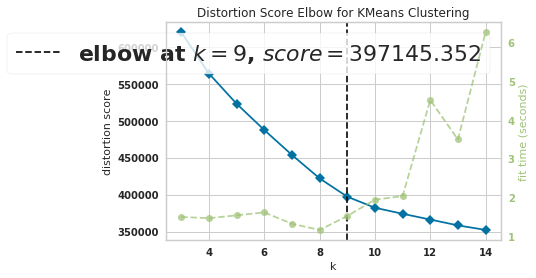

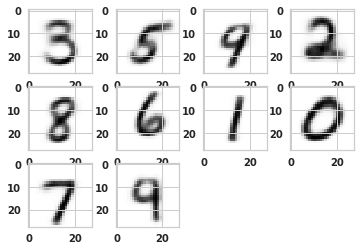

In [69]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()


# Iteration 4

In [82]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs
                                        budget=budget,
                                        manual_labels_config=ExperimentConfig.USE_ACTUAL
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 42, 'ID': 1, 'name': 'semi_supervised_classification'}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tenso

Epoch: 3/66, Nll_loss : 110.78936767578125 KLD:10.39563274383545  Supervised loss:0.14240339398384094
Epoch: 3/67, Nll_loss : 113.57565307617188 KLD:10.228456497192383  Supervised loss:0.27514636516571045
Epoch: 3/68, Nll_loss : 119.84176635742188 KLD:10.667815208435059  Supervised loss:0.16739362478256226
Epoch: 3/69, Nll_loss : 130.26925659179688 KLD:10.603324890136719  Supervised loss:0.16071172058582306
Epoch: 3/70, Nll_loss : 117.13713073730469 KLD:10.505853652954102  Supervised loss:0.16780313849449158
Epoch: 3/71, Nll_loss : 116.4669189453125 KLD:10.247976303100586  Supervised loss:0.23870761692523956
Epoch: 3/72, Nll_loss : 123.93563079833984 KLD:9.944823265075684  Supervised loss:0.2707426846027374
Epoch: 3/73, Nll_loss : 120.11173248291016 KLD:9.792730331420898  Supervised loss:0.207472562789917
Epoch: 3/74, Nll_loss : 128.2154998779297 KLD:9.926858901977539  Supervised loss:0.17993713915348053
Epoch: 3/75, Nll_loss : 119.73233032226562 KLD:9.717733383178711  Supervised loss:

Epoch: 3/146, Nll_loss : 115.25747680664062 KLD:10.44429874420166  Supervised loss:0.1805555820465088
Epoch: 3/147, Nll_loss : 119.7192611694336 KLD:10.255352020263672  Supervised loss:0.20032048225402832
Epoch: 3/148, Nll_loss : 126.37486267089844 KLD:9.975249290466309  Supervised loss:0.28689664602279663
Epoch: 3/149, Nll_loss : 117.36276245117188 KLD:9.992300033569336  Supervised loss:0.17199373245239258
Epoch: 3/150, Nll_loss : 124.83200073242188 KLD:10.139042854309082  Supervised loss:0.19769644737243652
Epoch: 3/151, Nll_loss : 116.05732727050781 KLD:9.668496131896973  Supervised loss:0.0993594378232956
Epoch: 3/152, Nll_loss : 117.90662384033203 KLD:9.554738998413086  Supervised loss:0.23131290078163147
Epoch: 3/153, Nll_loss : 116.95176696777344 KLD:9.933235168457031  Supervised loss:0.17423665523529053
Epoch: 3/154, Nll_loss : 125.43347930908203 KLD:10.060002326965332  Supervised loss:0.16858713328838348
Epoch: 3/155, Nll_loss : 125.4651107788086 KLD:10.231071472167969  Superv

Epoch: 3/227, Nll_loss : 121.47285461425781 KLD:10.103075981140137  Supervised loss:0.27783092856407166
Epoch: 3/228, Nll_loss : 121.77099609375 KLD:10.486471176147461  Supervised loss:0.22211116552352905
Epoch: 3/229, Nll_loss : 120.792724609375 KLD:10.241649627685547  Supervised loss:0.16608548164367676
Epoch: 3/230, Nll_loss : 122.04839324951172 KLD:9.977212905883789  Supervised loss:0.2068967968225479
Epoch: 3/231, Nll_loss : 121.3307113647461 KLD:10.314960479736328  Supervised loss:0.19425149261951447
Epoch: 3/232, Nll_loss : 114.96234130859375 KLD:10.356405258178711  Supervised loss:0.15778474509716034
Epoch: 3/233, Nll_loss : 117.82388305664062 KLD:10.650157928466797  Supervised loss:0.14277134835720062
Epoch: 3/234, Nll_loss : 120.81763458251953 KLD:10.232353210449219  Supervised loss:0.10062289983034134
Epoch: 3/235, Nll_loss : 116.47625732421875 KLD:10.34483528137207  Supervised loss:0.18966981768608093
Epoch: 3/236, Nll_loss : 117.53854370117188 KLD:10.54595947265625  Superv

Epoch: 3/307, Nll_loss : 116.47269439697266 KLD:10.043521881103516  Supervised loss:0.19562995433807373
Epoch: 3/308, Nll_loss : 126.21076965332031 KLD:10.222434043884277  Supervised loss:0.1658632904291153
Epoch: 3/309, Nll_loss : 115.40980529785156 KLD:9.766304016113281  Supervised loss:0.1930234730243683
Epoch: 3/310, Nll_loss : 127.26628112792969 KLD:9.921422004699707  Supervised loss:0.18158388137817383
Epoch: 3/311, Nll_loss : 128.51820373535156 KLD:9.88853645324707  Supervised loss:0.16973146796226501
Epoch: 3/312, Nll_loss : 124.19194030761719 KLD:10.208616256713867  Supervised loss:0.19387665390968323
Epoch: 3/313, Nll_loss : 123.50374603271484 KLD:9.717557907104492  Supervised loss:0.2393237054347992
Epoch: 3/314, Nll_loss : 115.38929748535156 KLD:9.70347785949707  Supervised loss:0.1467284858226776
Epoch: 3/315, Nll_loss : 116.23653411865234 KLD:9.841347694396973  Supervised loss:0.137021005153656
Epoch: 3/316, Nll_loss : 116.87326049804688 KLD:9.880704879760742  Supervised 

Epoch: 3/389, Nll_loss : 117.7686767578125 KLD:10.0628662109375  Supervised loss:0.17234684526920319
Epoch: 3/390, Nll_loss : 121.00960540771484 KLD:10.40121078491211  Supervised loss:0.16809064149856567
Epoch: 3/391, Nll_loss : 113.08063507080078 KLD:10.241069793701172  Supervised loss:0.24549412727355957
Epoch: 3/392, Nll_loss : 116.35149383544922 KLD:10.173471450805664  Supervised loss:0.1412316858768463
Epoch: 3/393, Nll_loss : 120.67758178710938 KLD:10.759442329406738  Supervised loss:0.19966650009155273
Epoch: 3/394, Nll_loss : 116.9244613647461 KLD:10.48655891418457  Supervised loss:0.17229366302490234
Epoch: 3/395, Nll_loss : 115.74333953857422 KLD:10.380882263183594  Supervised loss:0.25116097927093506
Epoch: 3/396, Nll_loss : 116.50830841064453 KLD:10.965597152709961  Supervised loss:0.11516880989074707
Epoch: 3/397, Nll_loss : 108.25711059570312 KLD:10.357942581176758  Supervised loss:0.18808595836162567
Epoch: 3/398, Nll_loss : 123.04953002929688 KLD:10.940900802612305  Sup

Epoch: 3/470, Nll_loss : 115.08128356933594 KLD:10.702391624450684  Supervised loss:0.12404526770114899
Epoch: 3/471, Nll_loss : 115.98548889160156 KLD:10.22266960144043  Supervised loss:0.11359599977731705
Epoch: 3/472, Nll_loss : 121.95667266845703 KLD:9.679062843322754  Supervised loss:0.2651643753051758
Epoch: 3/473, Nll_loss : 115.42695617675781 KLD:9.786005020141602  Supervised loss:0.21779432892799377
Epoch: 3/474, Nll_loss : 117.7105712890625 KLD:9.493088722229004  Supervised loss:0.15958178043365479
Epoch: 3/475, Nll_loss : 121.37843322753906 KLD:9.672903060913086  Supervised loss:0.2156529724597931
Epoch: 3/476, Nll_loss : 117.39513397216797 KLD:10.115348815917969  Supervised loss:0.12222978472709656
Epoch: 3/477, Nll_loss : 117.12732696533203 KLD:9.815011978149414  Supervised loss:0.21276745200157166
Epoch: 3/478, Nll_loss : 115.28731536865234 KLD:9.480474472045898  Supervised loss:0.22162684798240662
Epoch: 3/479, Nll_loss : 127.56615447998047 KLD:9.63800048828125  Supervis

Epoch: 3/551, Nll_loss : 120.09983825683594 KLD:9.87723159790039  Supervised loss:0.1664065718650818
Epoch: 3/552, Nll_loss : 111.5613021850586 KLD:9.485971450805664  Supervised loss:0.16475118696689606
Epoch: 3/553, Nll_loss : 118.89884948730469 KLD:10.111078262329102  Supervised loss:0.14124420285224915
Epoch: 3/554, Nll_loss : 118.74954223632812 KLD:9.807945251464844  Supervised loss:0.22021722793579102
Epoch: 3/555, Nll_loss : 118.6321792602539 KLD:10.58067798614502  Supervised loss:0.1678968369960785
Epoch: 3/556, Nll_loss : 122.0343017578125 KLD:10.351240158081055  Supervised loss:0.10851012915372849
Epoch: 3/557, Nll_loss : 117.32475280761719 KLD:10.285618782043457  Supervised loss:0.2065240889787674
Epoch: 3/558, Nll_loss : 115.84739685058594 KLD:9.89348316192627  Supervised loss:0.17364315688610077
Epoch: 3/559, Nll_loss : 113.73129272460938 KLD:10.274866104125977  Supervised loss:0.12488643079996109
Epoch: 3/560, Nll_loss : 110.81415557861328 KLD:9.539459228515625  Supervised

Epoch: 3/632, Nll_loss : 113.84675598144531 KLD:10.028084754943848  Supervised loss:0.16971497237682343
Epoch: 3/633, Nll_loss : 115.36125183105469 KLD:10.248556137084961  Supervised loss:0.15464234352111816
Epoch: 3/634, Nll_loss : 113.38113403320312 KLD:10.192462921142578  Supervised loss:0.2647002935409546
Epoch: 3/635, Nll_loss : 118.39955139160156 KLD:10.24341106414795  Supervised loss:0.1912895143032074
Epoch: 3/636, Nll_loss : 113.6827163696289 KLD:10.36421012878418  Supervised loss:0.24707596004009247
Epoch: 3/637, Nll_loss : 109.72960662841797 KLD:9.858299255371094  Supervised loss:0.1741602122783661
Epoch: 3/638, Nll_loss : 119.37747192382812 KLD:10.00865364074707  Supervised loss:0.1913314014673233
Epoch: 3/639, Nll_loss : 123.31179809570312 KLD:9.904447555541992  Supervised loss:0.25703662633895874
Epoch: 3/640, Nll_loss : 114.62272644042969 KLD:9.952371597290039  Supervised loss:0.1577269434928894
Epoch: 3/641, Nll_loss : 117.6446533203125 KLD:9.814186096191406  Supervised

Epoch: 3/713, Nll_loss : 114.29107666015625 KLD:10.288074493408203  Supervised loss:0.19291476905345917
Epoch: 3/714, Nll_loss : 112.70831298828125 KLD:10.652730941772461  Supervised loss:0.16360513865947723
Epoch: 3/715, Nll_loss : 111.0029296875 KLD:10.262362480163574  Supervised loss:0.15280894935131073
Epoch: 3/716, Nll_loss : 111.57235717773438 KLD:10.258560180664062  Supervised loss:0.10837805271148682
Epoch: 3/717, Nll_loss : 121.17103576660156 KLD:10.576638221740723  Supervised loss:0.19062092900276184
Epoch: 3/718, Nll_loss : 110.71180725097656 KLD:9.723615646362305  Supervised loss:0.15044772624969482
Epoch: 3/719, Nll_loss : 118.48560333251953 KLD:9.712406158447266  Supervised loss:0.21967579424381256
Epoch: 3/720, Nll_loss : 114.84347534179688 KLD:9.911157608032227  Supervised loss:0.14797760546207428
Epoch: 3/721, Nll_loss : 119.750244140625 KLD:9.724579811096191  Supervised loss:0.21974638104438782
Epoch: 3/722, Nll_loss : 111.169921875 KLD:9.898565292358398  Supervised l

Epoch: 3/794, Nll_loss : 117.59324645996094 KLD:10.738862991333008  Supervised loss:0.13099226355552673
Epoch: 3/795, Nll_loss : 112.45890045166016 KLD:10.460687637329102  Supervised loss:0.21482403576374054
Epoch: 3/796, Nll_loss : 124.27737426757812 KLD:10.458171844482422  Supervised loss:0.1643565148115158
Epoch: 3/797, Nll_loss : 117.80830383300781 KLD:10.197397232055664  Supervised loss:0.22038176655769348
Epoch: 3/798, Nll_loss : 117.9937744140625 KLD:9.74669075012207  Supervised loss:0.19108359515666962
Epoch: 3/799, Nll_loss : 122.99545288085938 KLD:10.560850143432617  Supervised loss:0.17502358555793762
Epoch: 3/800, Nll_loss : 120.952392578125 KLD:10.289377212524414  Supervised loss:0.10951483249664307
Epoch: 3/801, Nll_loss : 112.26800537109375 KLD:10.000041007995605  Supervised loss:0.21800291538238525
Epoch: 3/802, Nll_loss : 112.48783874511719 KLD:10.40876579284668  Supervised loss:0.15972068905830383
Epoch: 3/803, Nll_loss : 112.27098083496094 KLD:9.694869995117188  Supe

Epoch: 3/875, Nll_loss : 117.94392395019531 KLD:9.627304077148438  Supervised loss:0.13942524790763855
Epoch: 3/876, Nll_loss : 114.48759460449219 KLD:9.640174865722656  Supervised loss:0.161603182554245
Epoch: 3/877, Nll_loss : 122.18093872070312 KLD:10.018516540527344  Supervised loss:0.23148775100708008
Epoch: 3/878, Nll_loss : 123.02058410644531 KLD:9.844613075256348  Supervised loss:0.19205278158187866
Epoch: 3/879, Nll_loss : 111.0355453491211 KLD:10.072469711303711  Supervised loss:0.18044933676719666
Epoch: 3/880, Nll_loss : 112.42695617675781 KLD:9.919212341308594  Supervised loss:0.1643487811088562
Epoch: 3/881, Nll_loss : 114.76155090332031 KLD:10.458856582641602  Supervised loss:0.14532318711280823
Epoch: 3/882, Nll_loss : 115.50727081298828 KLD:10.41274642944336  Supervised loss:0.16842785477638245
Epoch: 3/883, Nll_loss : 109.31800079345703 KLD:10.123113632202148  Supervised loss:0.11969394236803055
Epoch: 3/884, Nll_loss : 120.63395690917969 KLD:10.262139320373535  Super

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_42/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=42 z_min=-4.3365517 z_max=4.2529645
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illega

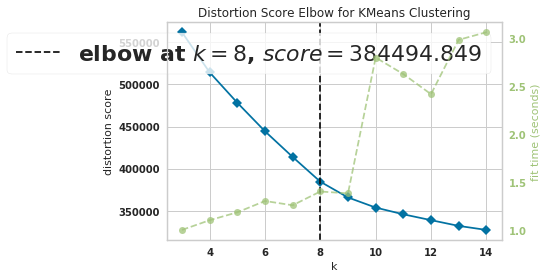

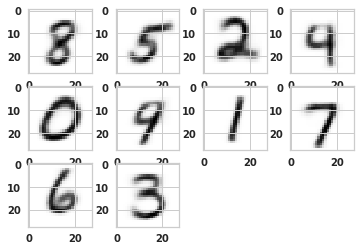

In [84]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()


# iteration 5

In [92]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs,
                                        budget=budget,
                                        manual_labels_config=ExperimentConfig.USE_ACTUAL,

                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'RUN_ID': 42, 'ID': 1, 'name': 'semi_supervised_classification'}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tenso

Epoch: 4/66, Nll_loss : 106.89412689208984 KLD:11.175125122070312  Supervised loss:0.11505120247602463
Epoch: 4/67, Nll_loss : 112.46736145019531 KLD:10.716461181640625  Supervised loss:0.30328238010406494
Epoch: 4/68, Nll_loss : 118.30178833007812 KLD:11.317361831665039  Supervised loss:0.22232866287231445
Epoch: 4/69, Nll_loss : 128.79151916503906 KLD:10.750341415405273  Supervised loss:0.29531508684158325
Epoch: 4/70, Nll_loss : 116.35267639160156 KLD:10.4244384765625  Supervised loss:0.20149263739585876
Epoch: 4/71, Nll_loss : 120.65030670166016 KLD:10.128911972045898  Supervised loss:0.2944888472557068
Epoch: 4/72, Nll_loss : 122.92646789550781 KLD:9.927452087402344  Supervised loss:0.27393242716789246
Epoch: 4/73, Nll_loss : 120.57640838623047 KLD:10.022964477539062  Supervised loss:0.21334552764892578
Epoch: 4/74, Nll_loss : 127.47264862060547 KLD:10.458526611328125  Supervised loss:0.24098607897758484
Epoch: 4/75, Nll_loss : 120.72171020507812 KLD:10.619730949401855  Supervised

Epoch: 4/147, Nll_loss : 119.1583480834961 KLD:11.052987098693848  Supervised loss:0.2356991469860077
Epoch: 4/148, Nll_loss : 126.77392578125 KLD:10.669857025146484  Supervised loss:0.2818051874637604
Epoch: 4/149, Nll_loss : 112.67518615722656 KLD:10.85389518737793  Supervised loss:0.20612353086471558
Epoch: 4/150, Nll_loss : 123.8995132446289 KLD:11.118548393249512  Supervised loss:0.20585888624191284
Epoch: 4/151, Nll_loss : 116.41374206542969 KLD:10.949626922607422  Supervised loss:0.18799829483032227
Epoch: 4/152, Nll_loss : 116.01922607421875 KLD:10.855842590332031  Supervised loss:0.2209392786026001
Epoch: 4/153, Nll_loss : 113.31031799316406 KLD:11.039955139160156  Supervised loss:0.1857837587594986
Epoch: 4/154, Nll_loss : 123.53096008300781 KLD:10.859541893005371  Supervised loss:0.2783146798610687
Epoch: 4/155, Nll_loss : 122.21150207519531 KLD:10.796812057495117  Supervised loss:0.19027851521968842
Epoch: 4/156, Nll_loss : 116.94490051269531 KLD:10.464667320251465  Supervi

Epoch: 4/227, Nll_loss : 121.13521575927734 KLD:10.161934852600098  Supervised loss:0.29778406023979187
Epoch: 4/228, Nll_loss : 123.03199768066406 KLD:10.444469451904297  Supervised loss:0.1710631400346756
Epoch: 4/229, Nll_loss : 116.6546401977539 KLD:10.375249862670898  Supervised loss:0.17999297380447388
Epoch: 4/230, Nll_loss : 121.5249252319336 KLD:9.659635543823242  Supervised loss:0.24538782238960266
Epoch: 4/231, Nll_loss : 123.98881530761719 KLD:9.986841201782227  Supervised loss:0.2176828682422638
Epoch: 4/232, Nll_loss : 116.84228515625 KLD:10.187872886657715  Supervised loss:0.22679643332958221
Epoch: 4/233, Nll_loss : 118.60026550292969 KLD:10.49293041229248  Supervised loss:0.22650445997714996
Epoch: 4/234, Nll_loss : 122.61447143554688 KLD:10.488049507141113  Supervised loss:0.11883117258548737
Epoch: 4/235, Nll_loss : 117.67112731933594 KLD:10.559955596923828  Supervised loss:0.1755281686782837
Epoch: 4/236, Nll_loss : 118.51272583007812 KLD:10.860285758972168  Supervi

Epoch: 4/307, Nll_loss : 117.00969696044922 KLD:10.620077133178711  Supervised loss:0.18215948343276978
Epoch: 4/308, Nll_loss : 127.16873168945312 KLD:10.989895820617676  Supervised loss:0.22056350111961365
Epoch: 4/309, Nll_loss : 112.72755432128906 KLD:10.617828369140625  Supervised loss:0.17857538163661957
Epoch: 4/310, Nll_loss : 123.08441162109375 KLD:10.87179183959961  Supervised loss:0.22206324338912964
Epoch: 4/311, Nll_loss : 127.03817749023438 KLD:10.843761444091797  Supervised loss:0.24928826093673706
Epoch: 4/312, Nll_loss : 121.4981918334961 KLD:11.165121078491211  Supervised loss:0.2485824078321457
Epoch: 4/313, Nll_loss : 121.54390716552734 KLD:10.628263473510742  Supervised loss:0.19679099321365356
Epoch: 4/314, Nll_loss : 113.97213745117188 KLD:10.412370681762695  Supervised loss:0.2555704712867737
Epoch: 4/315, Nll_loss : 116.87496948242188 KLD:10.388927459716797  Supervised loss:0.19674745202064514
Epoch: 4/316, Nll_loss : 115.58140563964844 KLD:10.100136756896973  

Epoch: 4/388, Nll_loss : 119.44808959960938 KLD:10.327550888061523  Supervised loss:0.20516528189182281
Epoch: 4/389, Nll_loss : 117.78375244140625 KLD:10.60831069946289  Supervised loss:0.17861202359199524
Epoch: 4/390, Nll_loss : 120.42530059814453 KLD:10.52274227142334  Supervised loss:0.16182424128055573
Epoch: 4/391, Nll_loss : 110.93155670166016 KLD:10.479607582092285  Supervised loss:0.15235134959220886
Epoch: 4/392, Nll_loss : 116.68608093261719 KLD:10.486801147460938  Supervised loss:0.1634235829114914
Epoch: 4/393, Nll_loss : 122.53038024902344 KLD:10.583100318908691  Supervised loss:0.22367334365844727
Epoch: 4/394, Nll_loss : 115.57673645019531 KLD:10.396260261535645  Supervised loss:0.2886611521244049
Epoch: 4/395, Nll_loss : 118.68846130371094 KLD:10.000592231750488  Supervised loss:0.261055588722229
Epoch: 4/396, Nll_loss : 115.2076187133789 KLD:10.536580085754395  Supervised loss:0.18230146169662476
Epoch: 4/397, Nll_loss : 111.68391418457031 KLD:10.023829460144043  Sup

Epoch: 4/469, Nll_loss : 113.58509826660156 KLD:10.813021659851074  Supervised loss:0.18865163624286652
Epoch: 4/470, Nll_loss : 112.48712158203125 KLD:11.200486183166504  Supervised loss:0.14404180645942688
Epoch: 4/471, Nll_loss : 111.98719787597656 KLD:11.346550941467285  Supervised loss:0.23738709092140198
Epoch: 4/472, Nll_loss : 118.21015930175781 KLD:11.128617286682129  Supervised loss:0.19317308068275452
Epoch: 4/473, Nll_loss : 111.273681640625 KLD:11.503641128540039  Supervised loss:0.18616655468940735
Epoch: 4/474, Nll_loss : 109.2601318359375 KLD:11.227041244506836  Supervised loss:0.16442176699638367
Epoch: 4/475, Nll_loss : 118.2957763671875 KLD:11.277725219726562  Supervised loss:0.22136403620243073
Epoch: 4/476, Nll_loss : 114.33486938476562 KLD:11.563916206359863  Supervised loss:0.16532331705093384
Epoch: 4/477, Nll_loss : 116.90957641601562 KLD:10.948282241821289  Supervised loss:0.20451563596725464
Epoch: 4/478, Nll_loss : 115.38776397705078 KLD:10.427328109741211  

Epoch: 4/551, Nll_loss : 117.25120544433594 KLD:10.246696472167969  Supervised loss:0.18888752162456512
Epoch: 4/552, Nll_loss : 107.77112579345703 KLD:9.916975021362305  Supervised loss:0.2250116765499115
Epoch: 4/553, Nll_loss : 118.36273193359375 KLD:10.750483512878418  Supervised loss:0.21261103451251984
Epoch: 4/554, Nll_loss : 117.24853515625 KLD:10.048372268676758  Supervised loss:0.16130895912647247
Epoch: 4/555, Nll_loss : 118.67561340332031 KLD:10.795184135437012  Supervised loss:0.18671581149101257
Epoch: 4/556, Nll_loss : 120.75120544433594 KLD:10.674856185913086  Supervised loss:0.14950203895568848
Epoch: 4/557, Nll_loss : 112.93352508544922 KLD:10.749689102172852  Supervised loss:0.20554909110069275
Epoch: 4/558, Nll_loss : 113.79216003417969 KLD:10.263666152954102  Supervised loss:0.2644091844558716
Epoch: 4/559, Nll_loss : 115.246337890625 KLD:10.479013442993164  Supervised loss:0.1761554479598999
Epoch: 4/560, Nll_loss : 111.01373291015625 KLD:9.838916778564453  Superv

Epoch: 4/632, Nll_loss : 116.11744689941406 KLD:10.55787181854248  Supervised loss:0.19812405109405518
Epoch: 4/633, Nll_loss : 114.57991027832031 KLD:10.45466423034668  Supervised loss:0.2104267179965973
Epoch: 4/634, Nll_loss : 118.71713256835938 KLD:10.35755729675293  Supervised loss:0.2692509889602661
Epoch: 4/635, Nll_loss : 120.95957946777344 KLD:10.516611099243164  Supervised loss:0.22819292545318604
Epoch: 4/636, Nll_loss : 118.40035247802734 KLD:10.503621101379395  Supervised loss:0.21020792424678802
Epoch: 4/637, Nll_loss : 113.18984985351562 KLD:10.003320693969727  Supervised loss:0.14302021265029907
Epoch: 4/638, Nll_loss : 117.36460876464844 KLD:10.305937767028809  Supervised loss:0.19078922271728516
Epoch: 4/639, Nll_loss : 124.36453247070312 KLD:10.605304718017578  Supervised loss:0.18217119574546814
Epoch: 4/640, Nll_loss : 112.67236328125 KLD:10.79874038696289  Supervised loss:0.2294103503227234
Epoch: 4/641, Nll_loss : 118.6229019165039 KLD:10.38245964050293  Supervis

Epoch: 4/713, Nll_loss : 117.66819763183594 KLD:10.426525115966797  Supervised loss:0.16164398193359375
Epoch: 4/714, Nll_loss : 111.67732238769531 KLD:10.638830184936523  Supervised loss:0.16460826992988586
Epoch: 4/715, Nll_loss : 111.42546844482422 KLD:10.306070327758789  Supervised loss:0.16645409166812897
Epoch: 4/716, Nll_loss : 111.443359375 KLD:10.466236114501953  Supervised loss:0.1337897777557373
Epoch: 4/717, Nll_loss : 117.31330871582031 KLD:10.903509140014648  Supervised loss:0.21674950420856476
Epoch: 4/718, Nll_loss : 109.67475891113281 KLD:9.978877067565918  Supervised loss:0.15893112123012543
Epoch: 4/719, Nll_loss : 120.5253677368164 KLD:10.128644943237305  Supervised loss:0.235199972987175
Epoch: 4/720, Nll_loss : 113.88182067871094 KLD:10.178466796875  Supervised loss:0.17121896147727966
Epoch: 4/721, Nll_loss : 117.17820739746094 KLD:10.00466537475586  Supervised loss:0.18795731663703918
Epoch: 4/722, Nll_loss : 112.50076293945312 KLD:9.889232635498047  Supervised 

Epoch: 4/793, Nll_loss : 111.14063262939453 KLD:9.589495658874512  Supervised loss:0.1828649789094925
Epoch: 4/794, Nll_loss : 119.43070983886719 KLD:10.67963981628418  Supervised loss:0.14466886222362518
Epoch: 4/795, Nll_loss : 115.81084442138672 KLD:10.434053421020508  Supervised loss:0.197633296251297
Epoch: 4/796, Nll_loss : 124.79082489013672 KLD:10.447897911071777  Supervised loss:0.301052451133728
Epoch: 4/797, Nll_loss : 115.36271667480469 KLD:10.567232131958008  Supervised loss:0.20769114792346954
Epoch: 4/798, Nll_loss : 120.72097778320312 KLD:10.12797737121582  Supervised loss:0.30330583453178406
Epoch: 4/799, Nll_loss : 122.22175598144531 KLD:11.103606224060059  Supervised loss:0.2239774763584137
Epoch: 4/800, Nll_loss : 118.12767791748047 KLD:11.05419635772705  Supervised loss:0.17237204313278198
Epoch: 4/801, Nll_loss : 109.79801940917969 KLD:10.709507942199707  Supervised loss:0.2408134639263153
Epoch: 4/802, Nll_loss : 113.0436782836914 KLD:11.290010452270508  Supervis

Epoch: 4/874, Nll_loss : 119.08529663085938 KLD:10.468575477600098  Supervised loss:0.2094126045703888
Epoch: 4/875, Nll_loss : 113.19096374511719 KLD:10.46830940246582  Supervised loss:0.20977552235126495
Epoch: 4/876, Nll_loss : 112.27368927001953 KLD:10.174236297607422  Supervised loss:0.18345847725868225
Epoch: 4/877, Nll_loss : 117.00411224365234 KLD:10.53870964050293  Supervised loss:0.2418755143880844
Epoch: 4/878, Nll_loss : 121.9595718383789 KLD:10.565922737121582  Supervised loss:0.1529693305492401
Epoch: 4/879, Nll_loss : 108.73161315917969 KLD:10.418594360351562  Supervised loss:0.1716897338628769
Epoch: 4/880, Nll_loss : 110.01455688476562 KLD:10.09409236907959  Supervised loss:0.2221011072397232
Epoch: 4/881, Nll_loss : 115.60143280029297 KLD:10.610572814941406  Supervised loss:0.1722722202539444
Epoch: 4/882, Nll_loss : 116.07778930664062 KLD:10.68248176574707  Supervised loss:0.1834772676229477
Epoch: 4/883, Nll_loss : 108.01042938232422 KLD:10.35975170135498  Supervise

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_42/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=42 z_min=-4.608894 z_max=4.0989256
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal

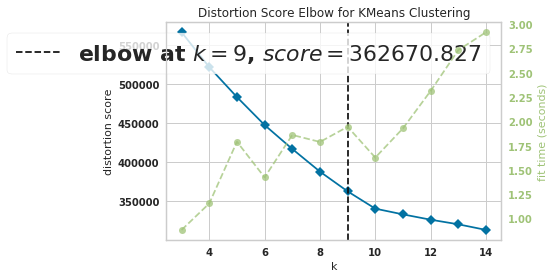

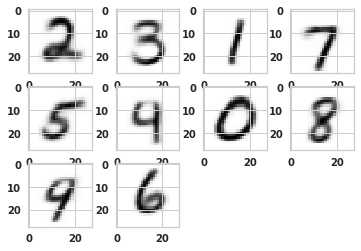

In [93]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


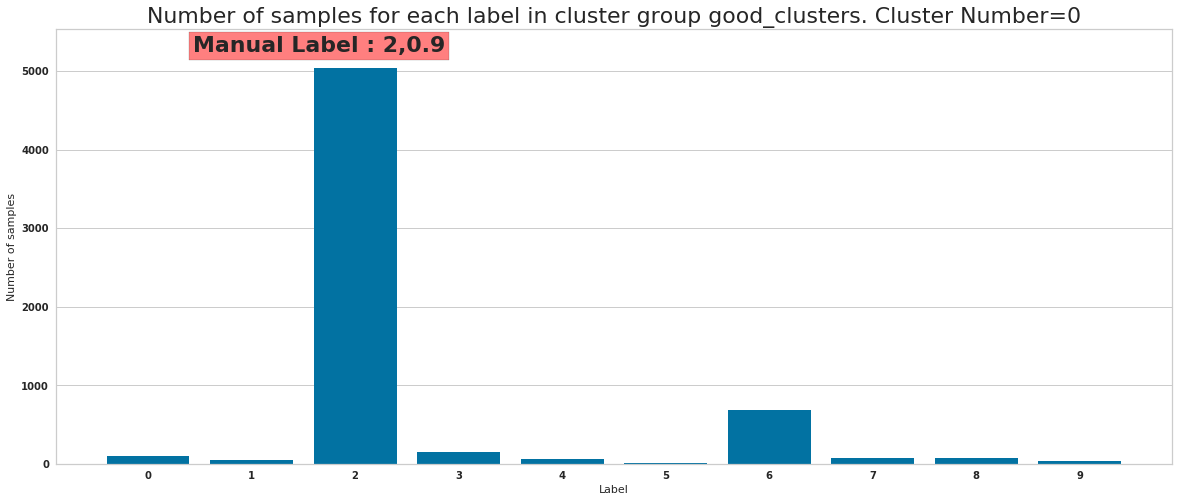

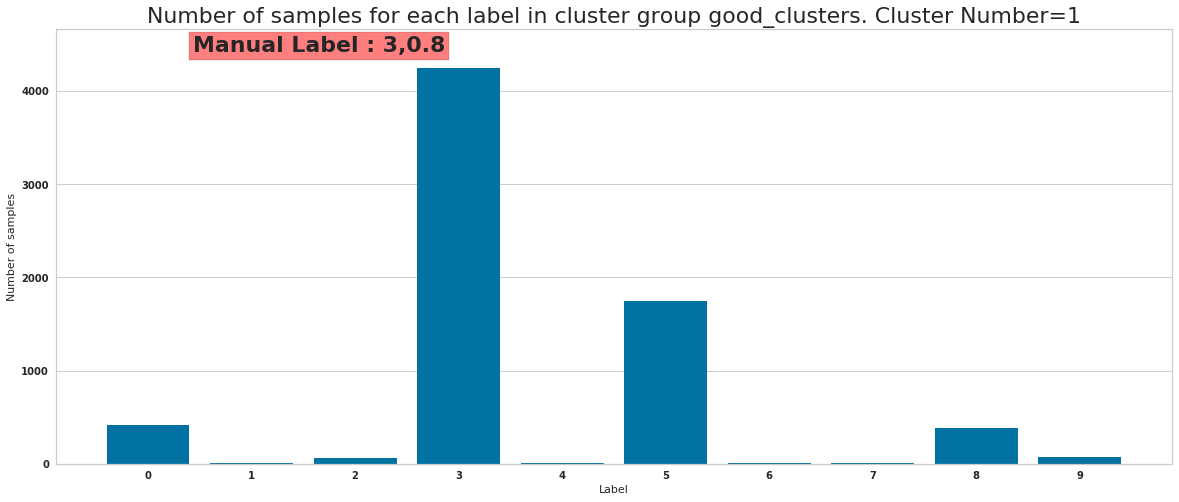

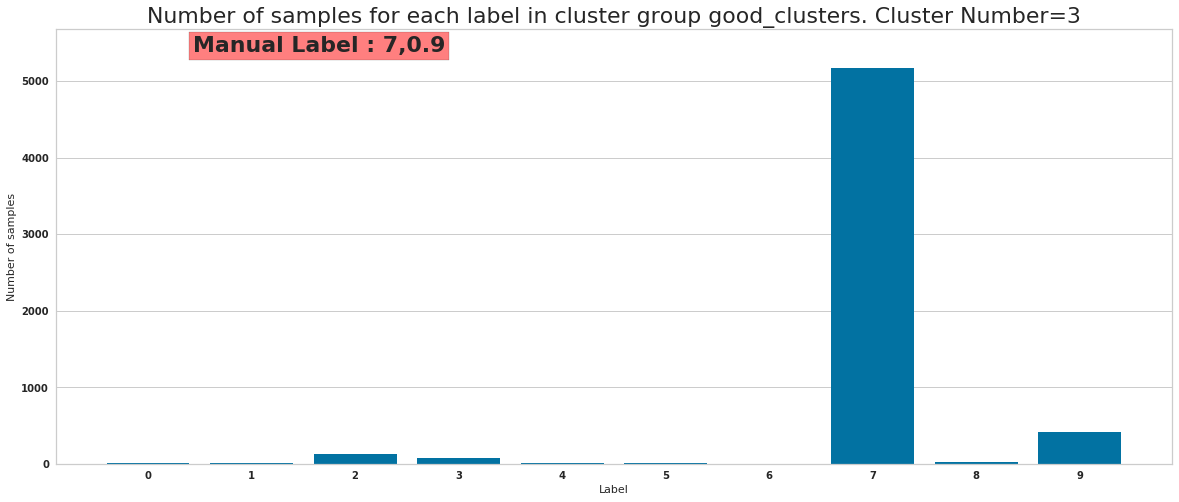

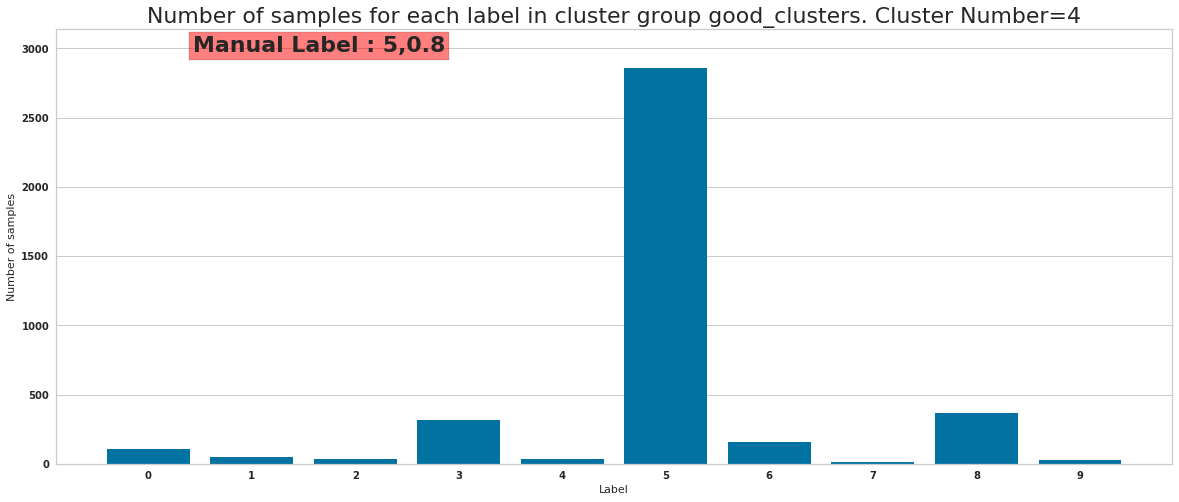

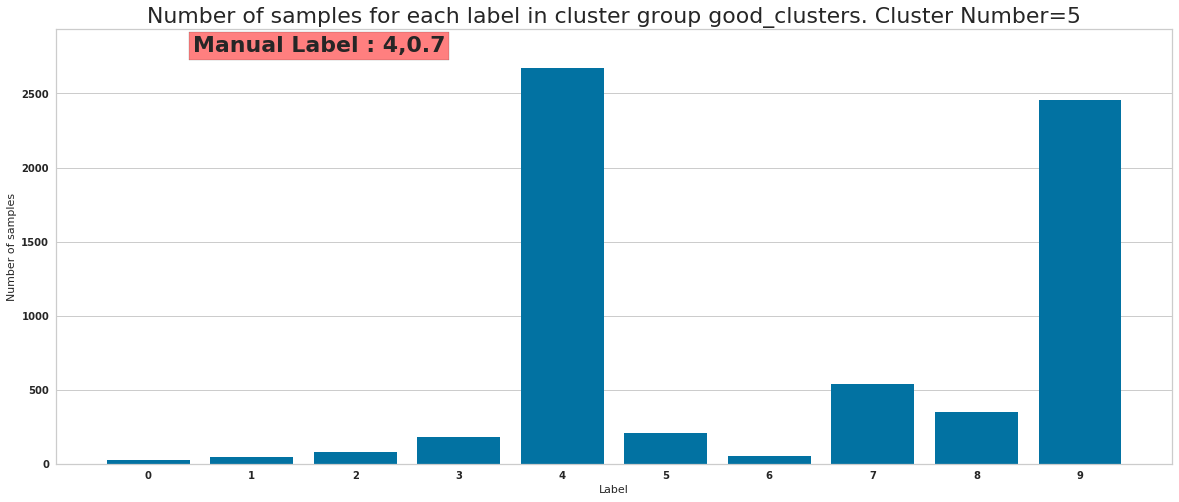

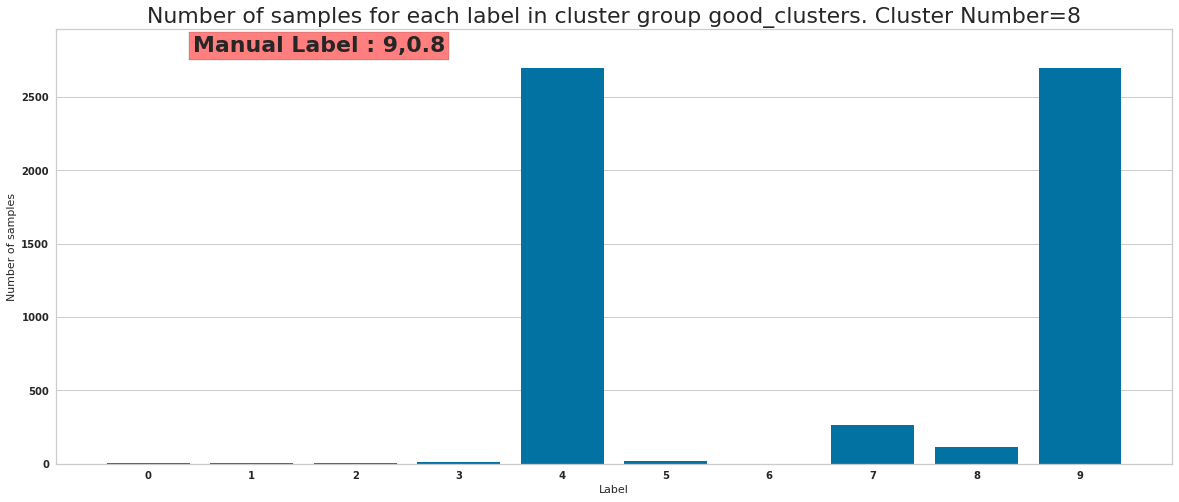

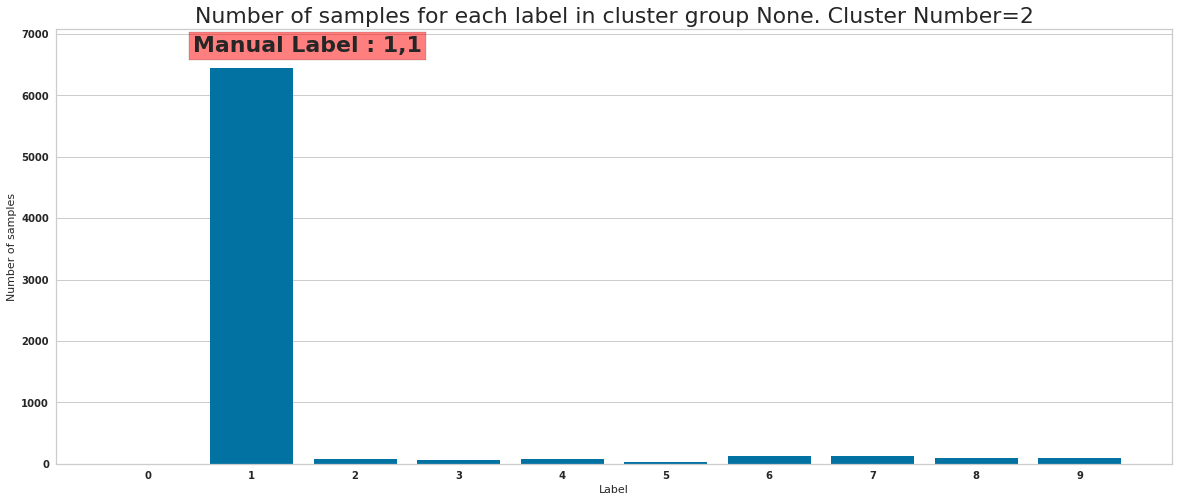

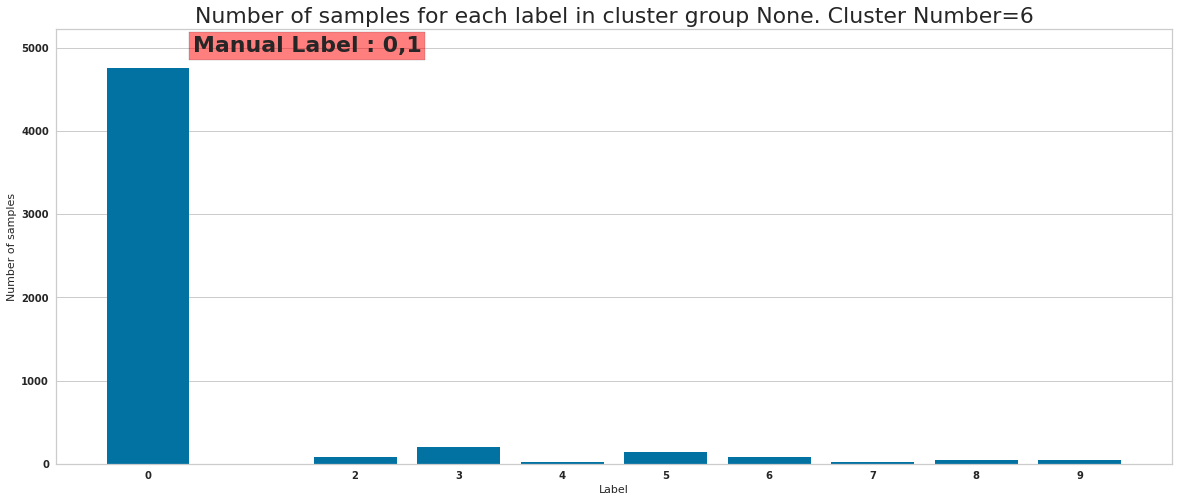

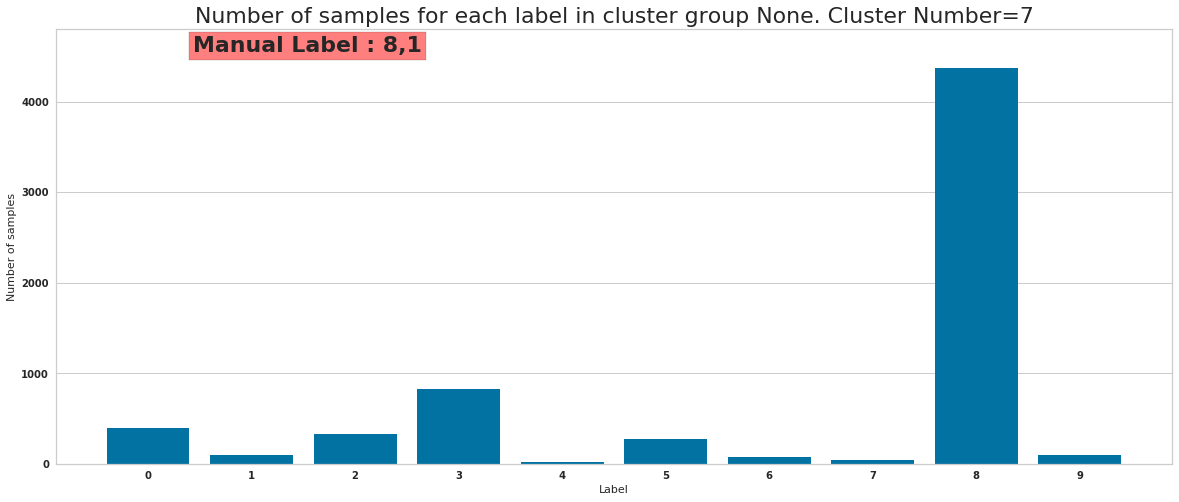

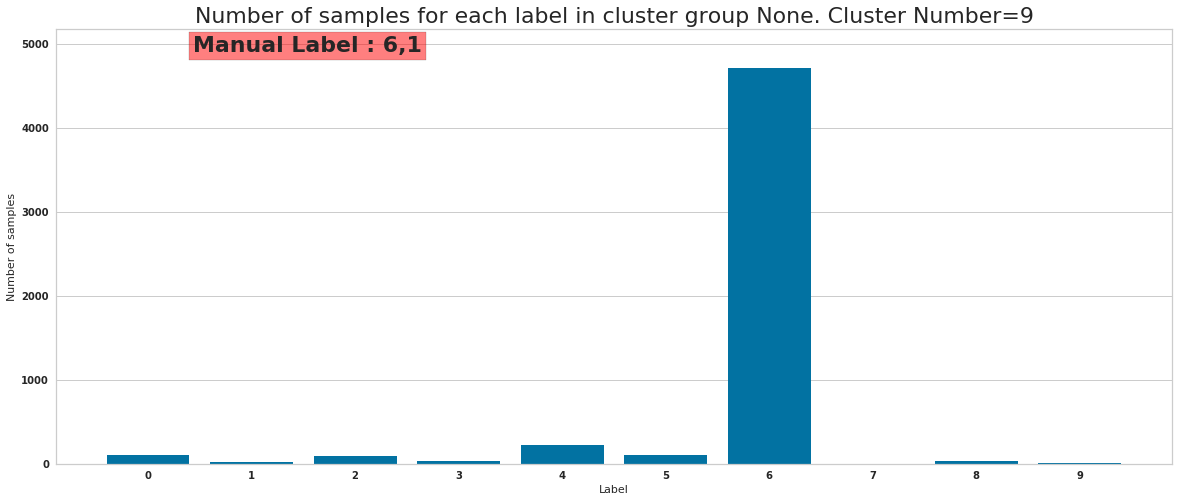

In [94]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [2,3,1,7,
                                           5,4,0,8,
                                           9,6,
                                          ]
manual_annotation_json["manual_confidence"] = [0.9,0.8,1,0.9,
                                               0.8,0.7,1,1,
                                               0.8,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [95]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 2
(6259, 47) (6259, 33)
Num correct=5034
Cluster 0 Manual Label 2 Percentage correct 80.42818341588114
********************************
Manual Label 3
(6954, 47) (6954, 33)
Num correct=4243
Cluster 1 Manual Label 3 Percentage correct 61.01524302559678
********************************
Manual Label 1
(7147, 47) (7147, 33)
Num correct=6439
Cluster 2 Manual Label 1 Percentage correct 90.09374562753602
********************************
Manual Label 7
(5853, 47) (5853, 33)
Num correct=5163
Cluster 3 Manual Label 7 Percentage correct 88.21117375704767
********************************
Manual Label 5
(3966, 47) (3966, 33)
Num correct=2855
Cluster 4 Manual Label 5 Percentage correct 71.98688855269793
********************************
Manual Label 4
(6608, 47) (6608, 33)
Num correct=2669
Cluster 5 Manual Label 4 Percentage correct 40.39043583535109
********************************
Manual Label 0
(5392, 47) (5392, 33)
Num correct=4749
Cluster 6 Manual Label 0 Percentage correct 88.07492

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

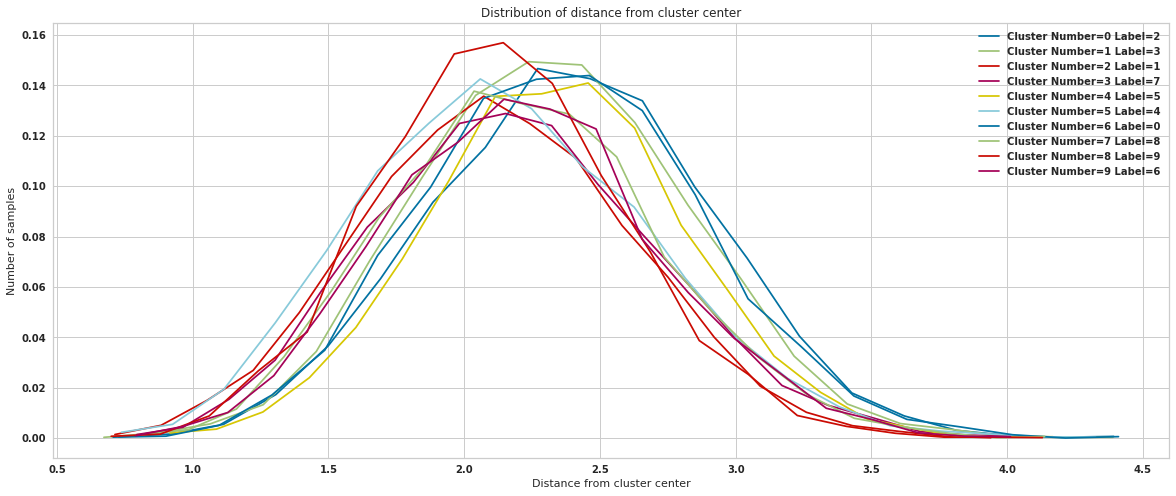

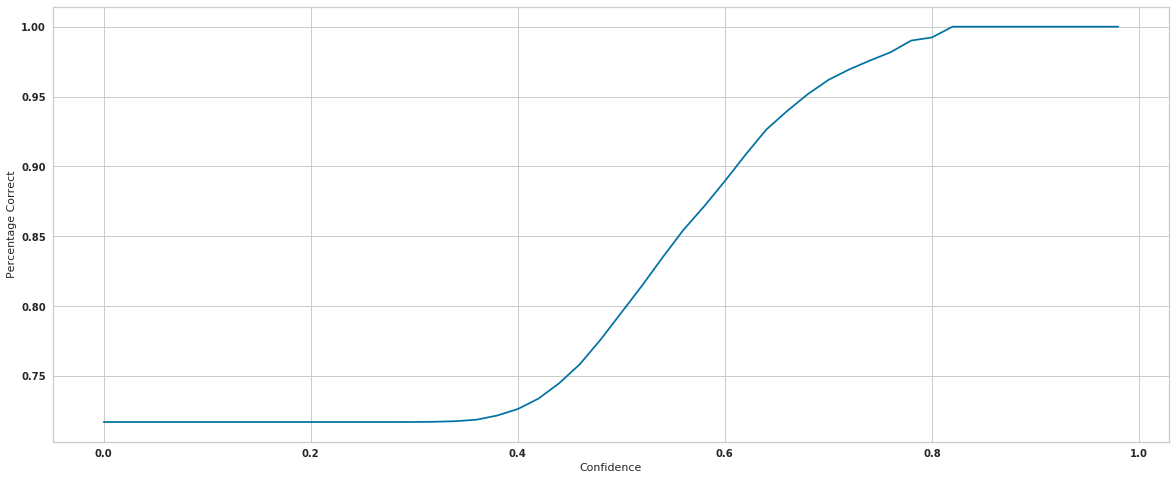

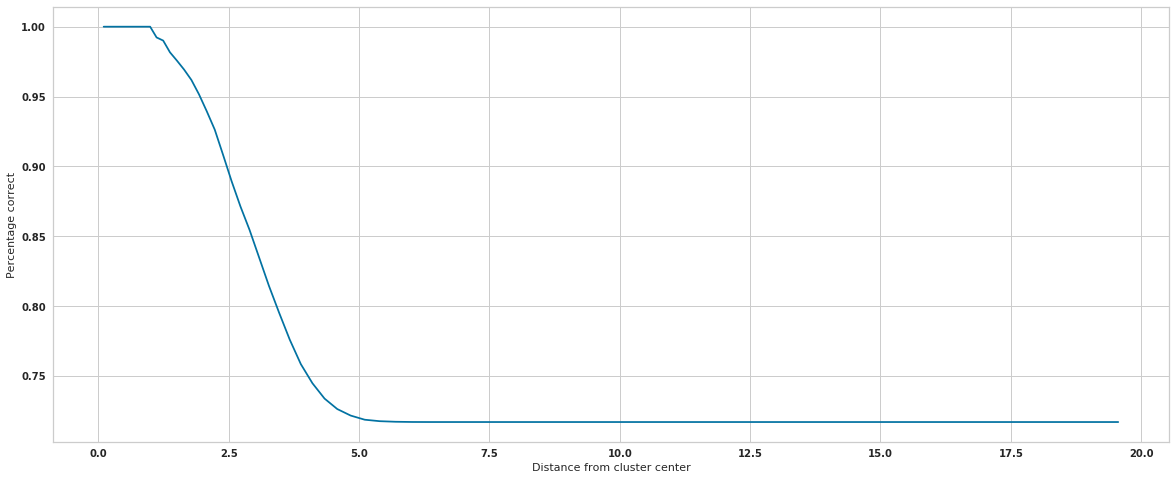

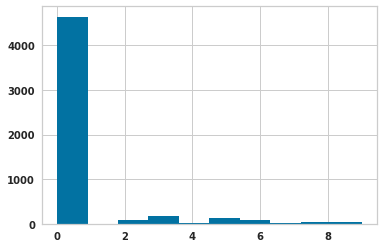

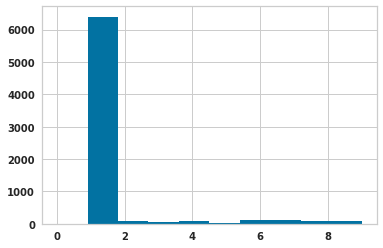

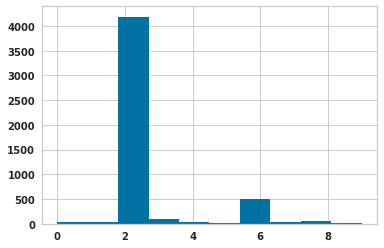

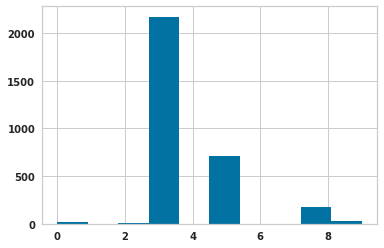

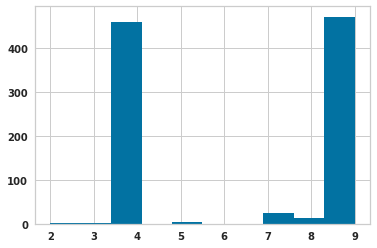

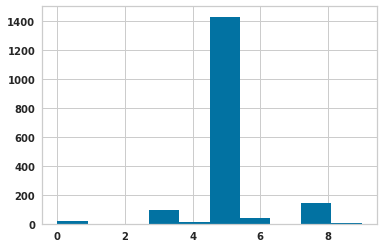

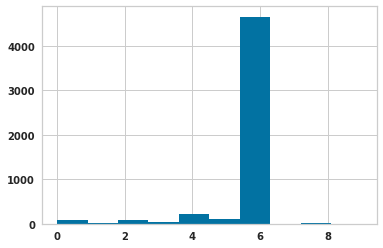

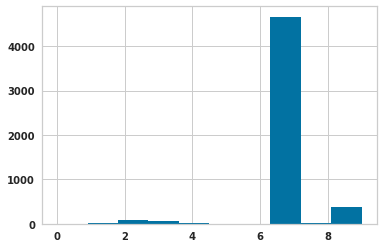

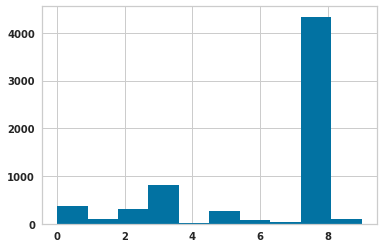

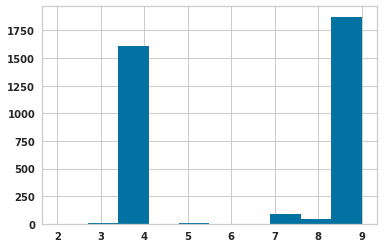

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [100]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

TypeError: initialize_model_train_and_get_features() missing 1 required positional argument: 'model_type'

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_10/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS
Number of steps completed=5610
Number of epochs completed 6.0
run_id=10 z_min=-5.0479445 z_max=4.711913
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instea

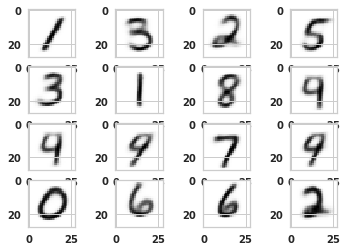

In [75]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


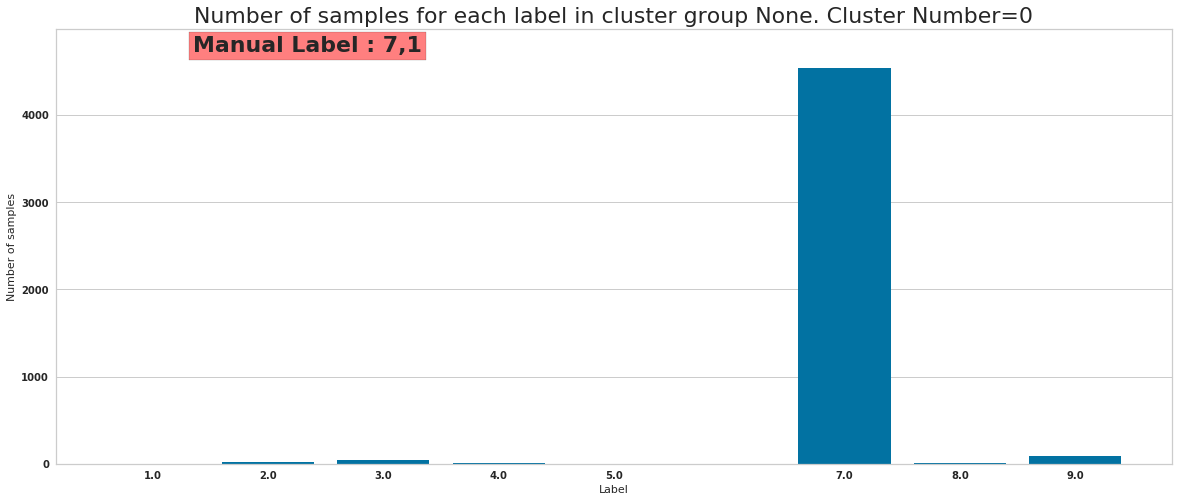

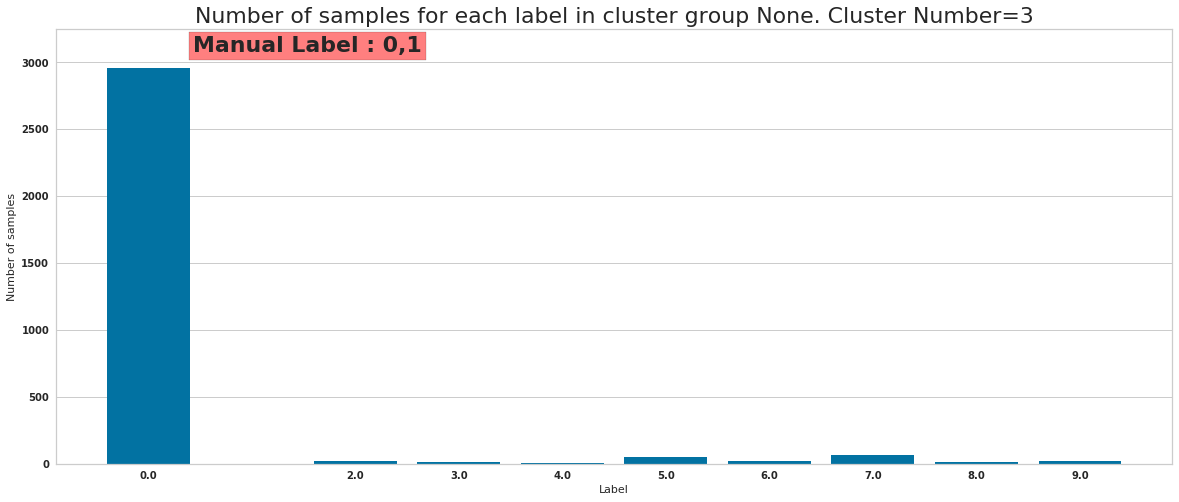

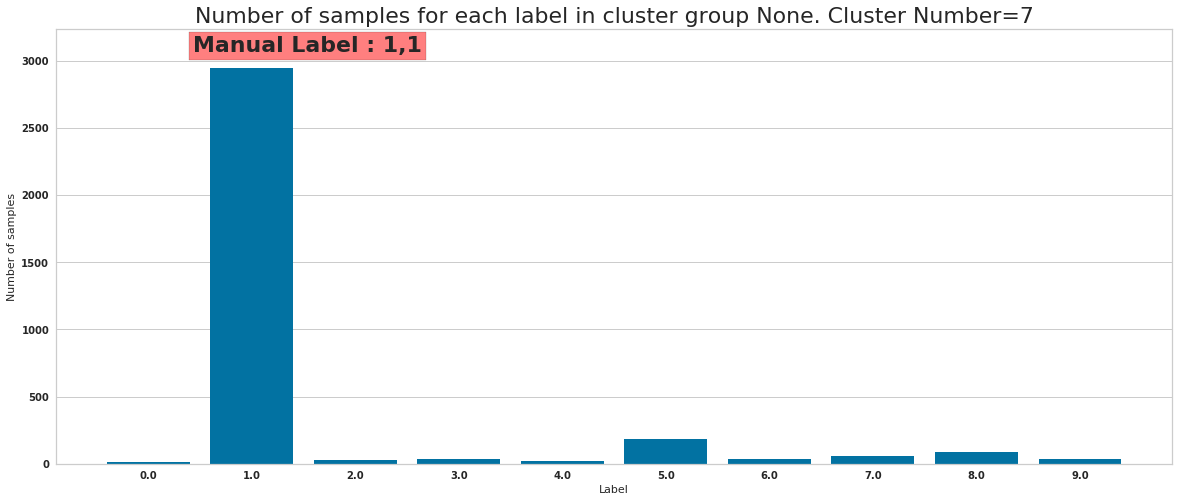

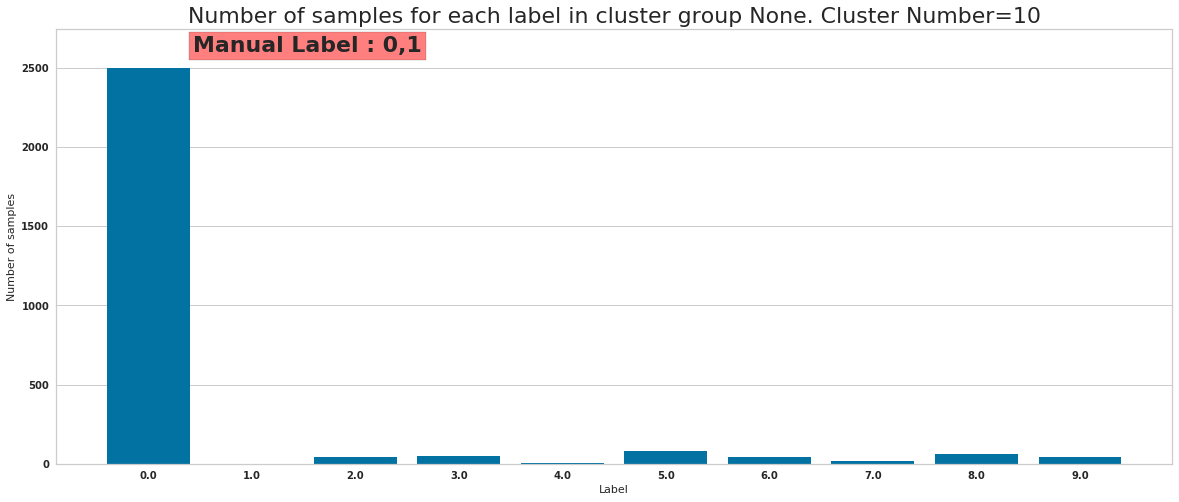

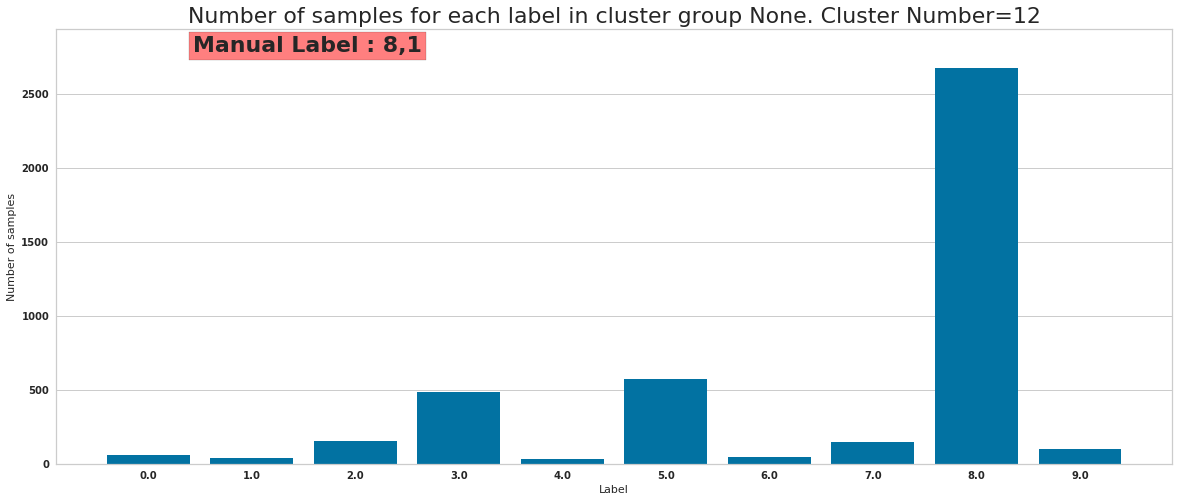

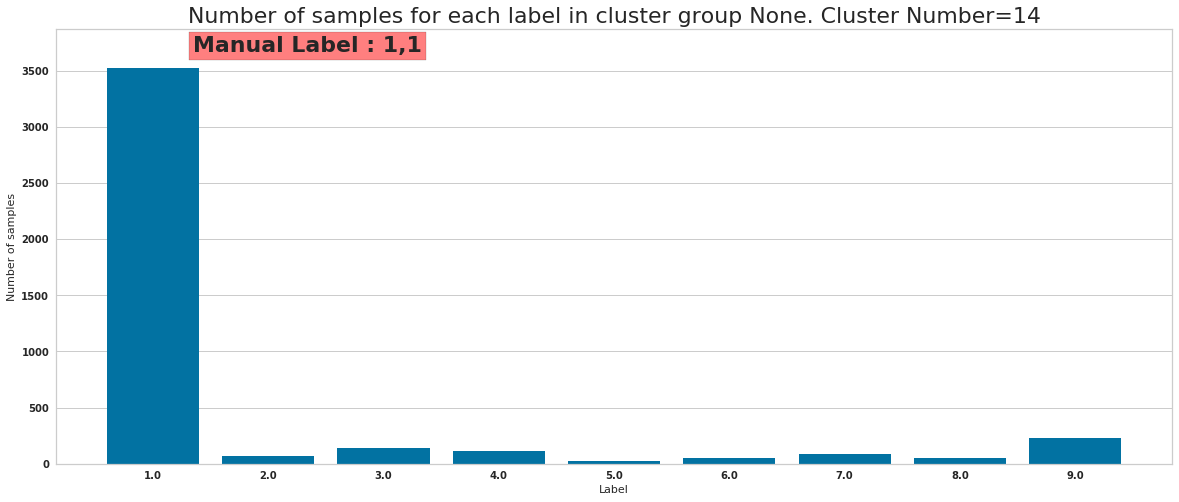

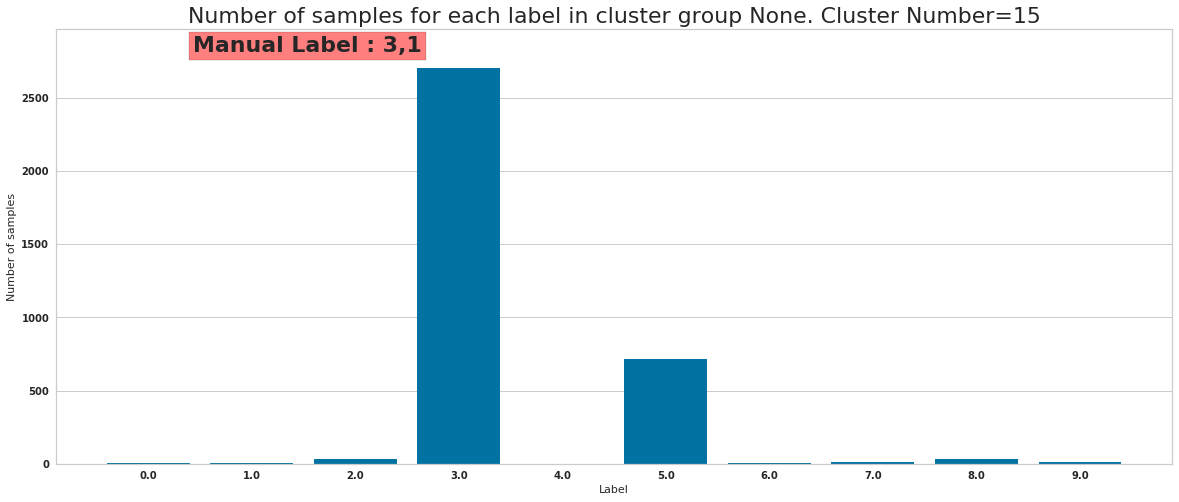

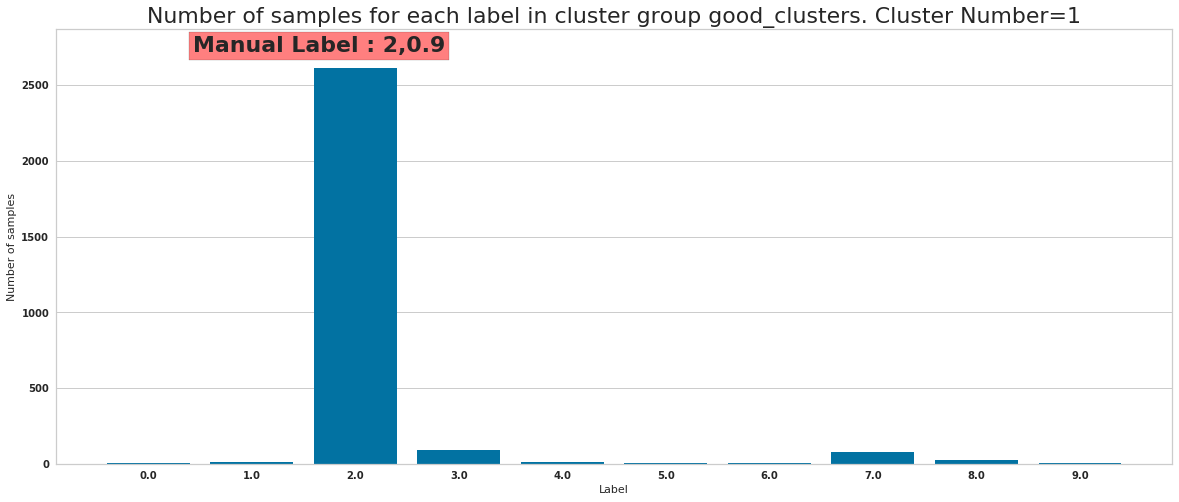

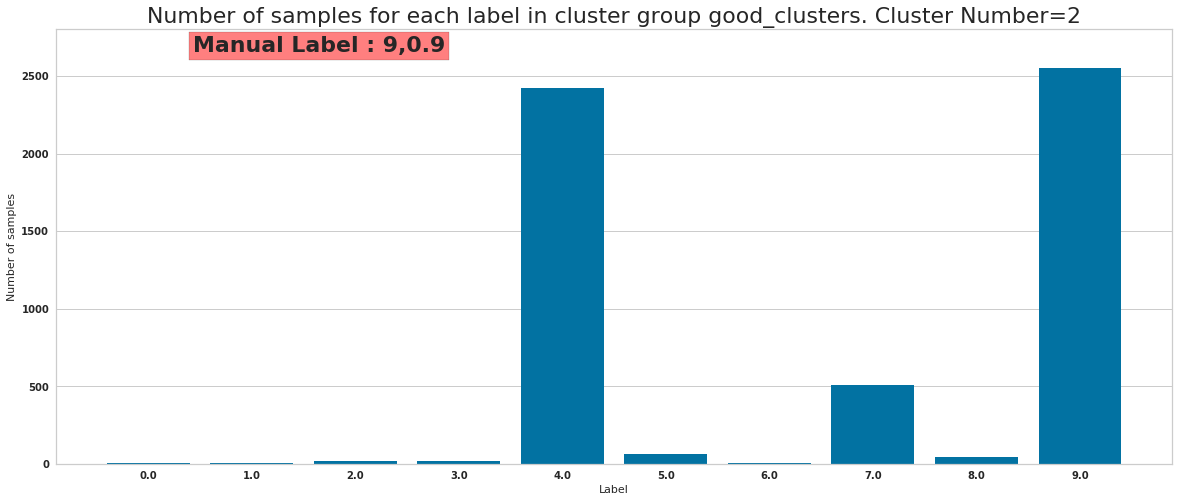

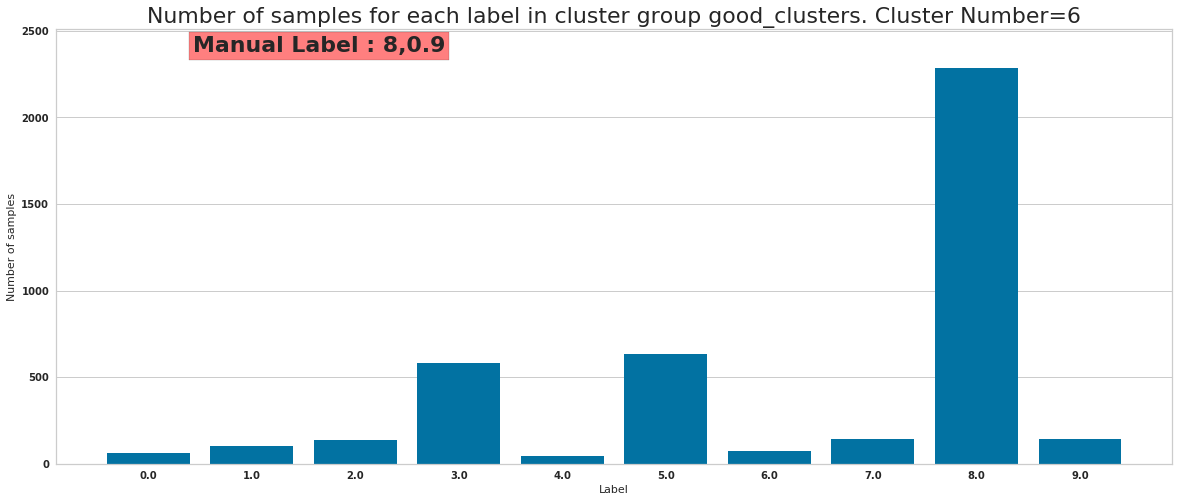

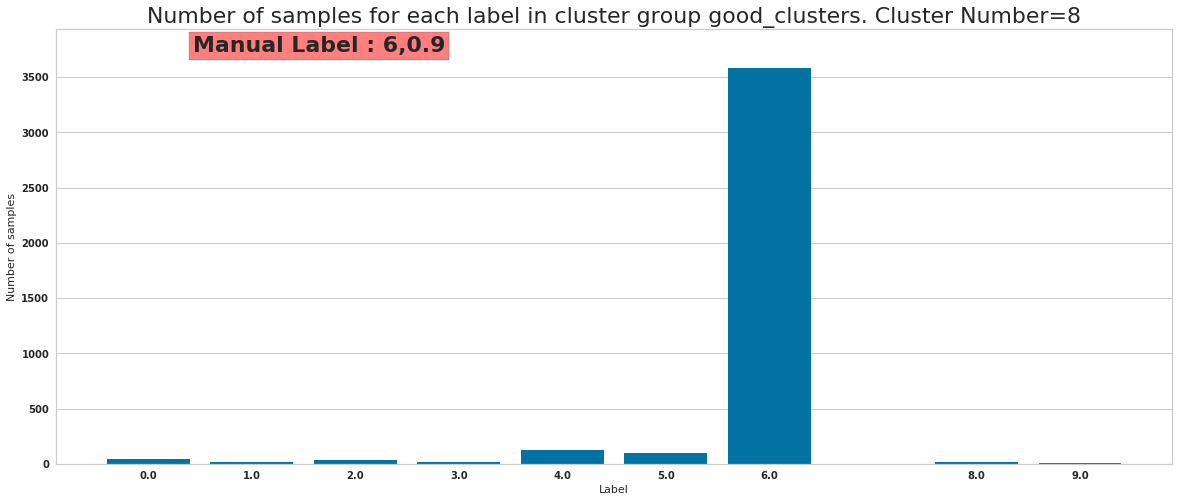

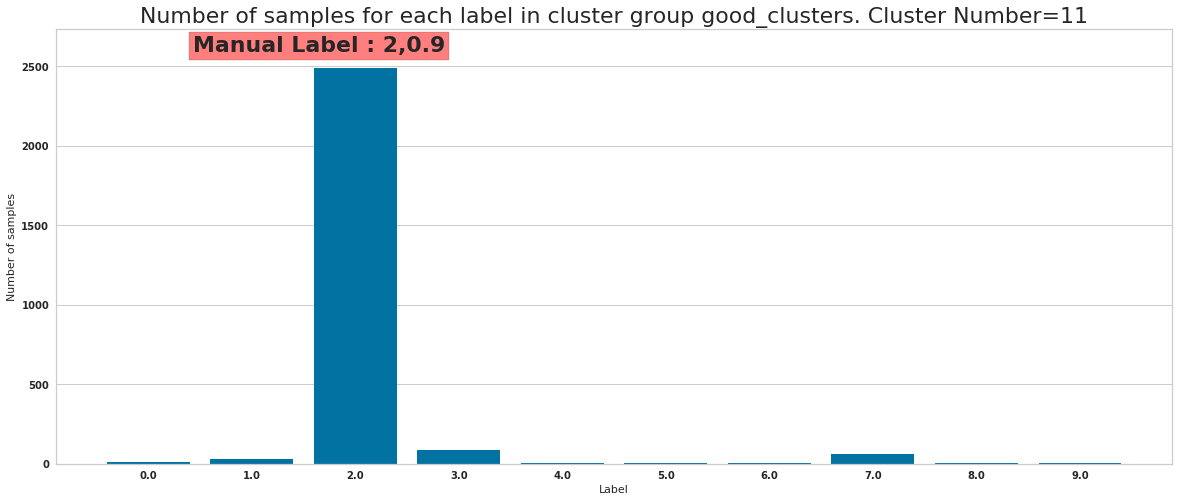

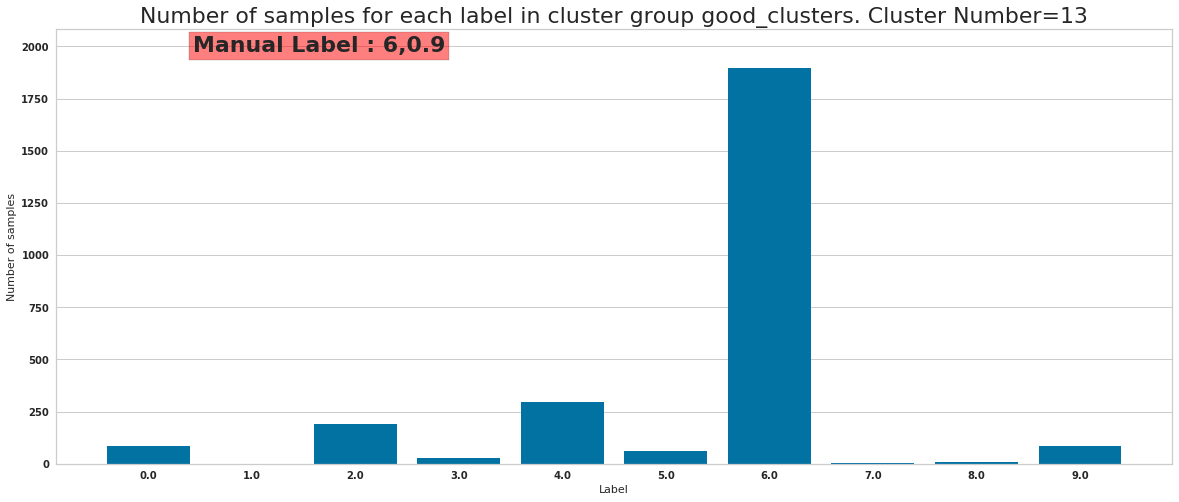

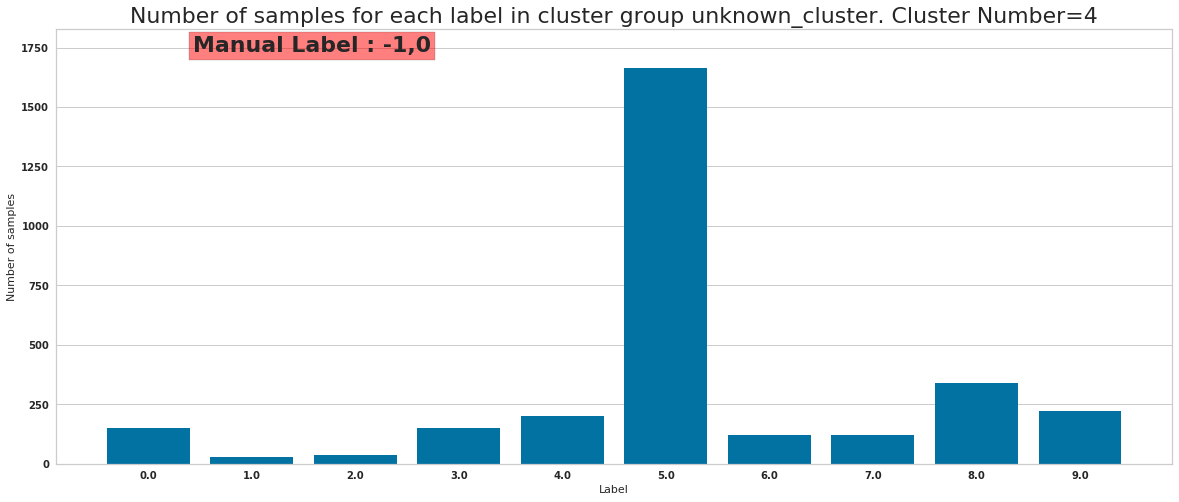

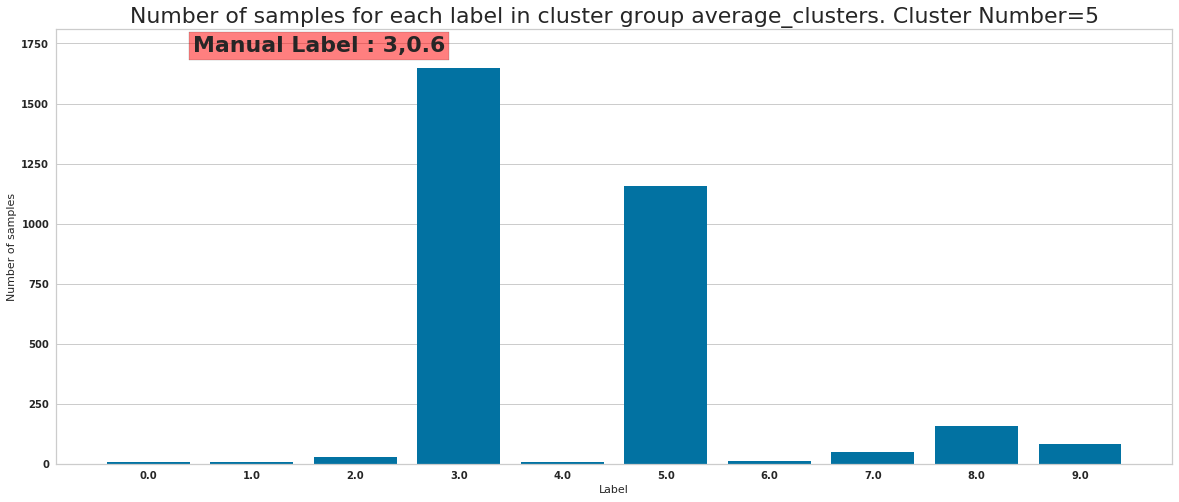

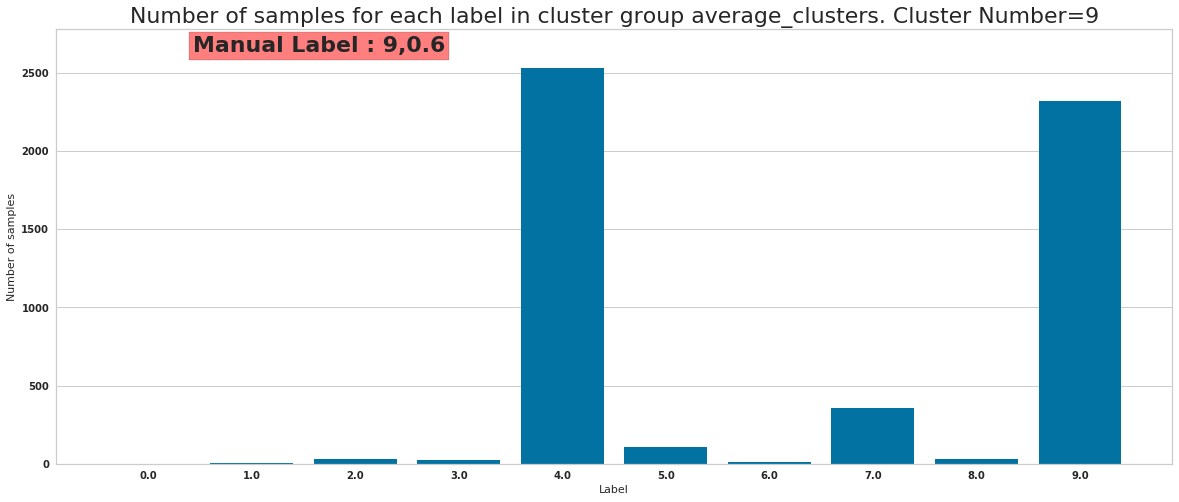

In [115]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,2,9,0,
                                           -1,3,8,1,
                                           6,9,0,2,
                                           8,6,1,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,0.9,1,
                                               0,0.6,0.9,1,
                                               0.9,0.6,1,0.9,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


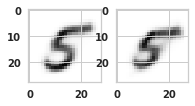

In [116]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [117]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [118]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


4
2
Skipping distance computation for unknown cluster
Manual Label 7
(4718, 54) (4718, 49)
Num correct=4536
Cluster 0 Manual Label 7 Percentage correct 96.14243323442136
********************************
Manual Label 2
(2847, 54) (2847, 49)
Num correct=2609
Cluster 1 Manual Label 2 Percentage correct 91.64032314717247
********************************
Manual Label 9
(5642, 54) (5642, 49)
Num correct=2549
Cluster 2 Manual Label 9 Percentage correct 45.17901453385324
********************************
Manual Label 0
(3158, 54) (3158, 49)
Num correct=2954
Cluster 3 Manual Label 0 Percentage correct 93.54021532615579
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 3
(3149, 54) (3149, 49)
Num correct=1646
Cluster 5 Manual Label 3 Percentage correct 52.270562083201014
********************************
Manual Label 8
(4202, 54) (4202, 49)
Num correct=2283
Cluster 6 Manual Label 8 Percentage correct 54.33127082341742
********

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

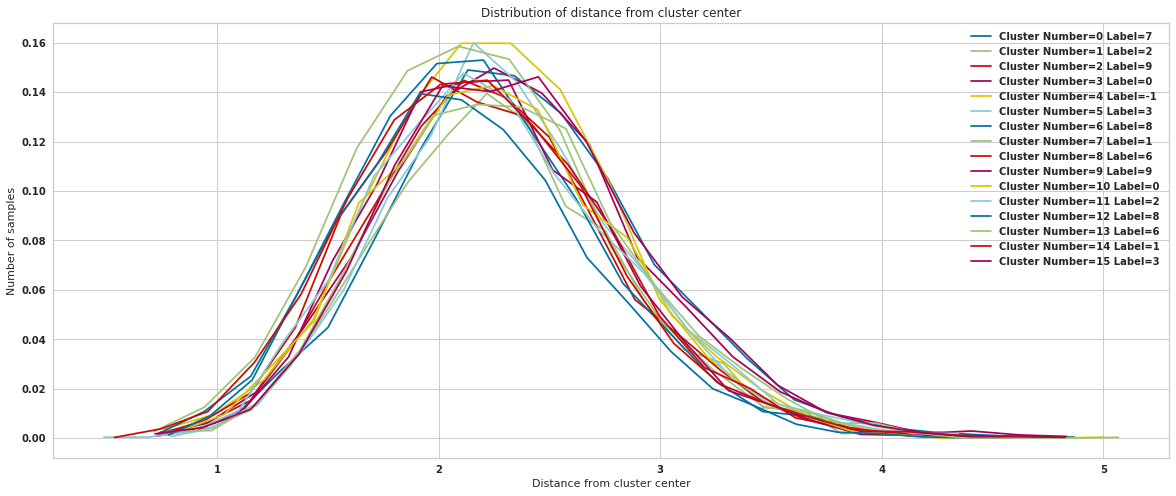

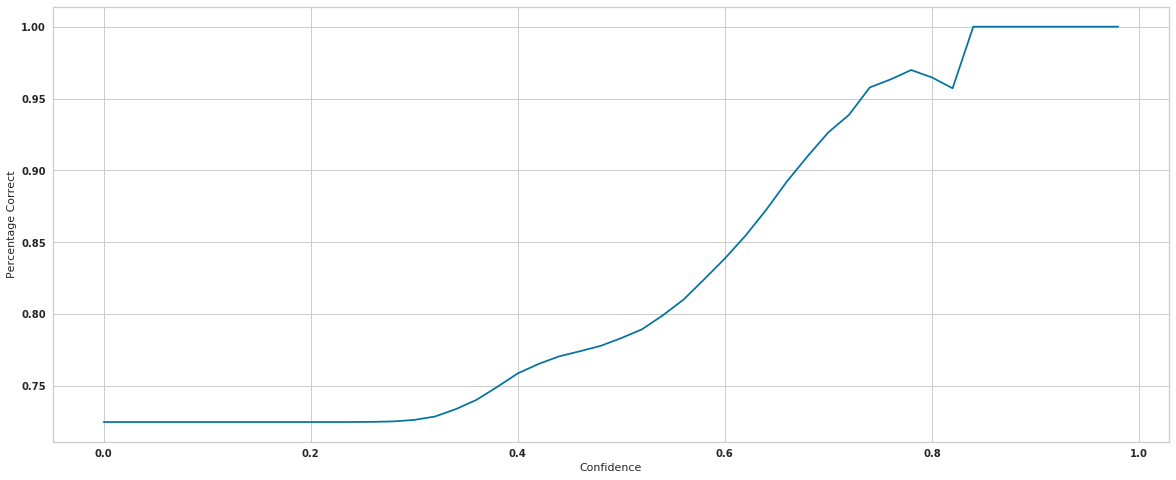

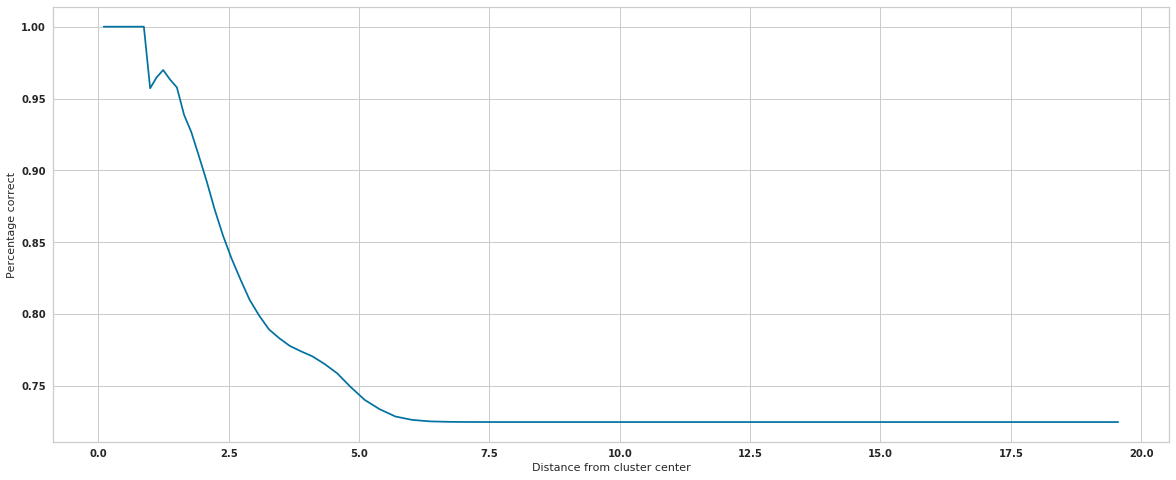

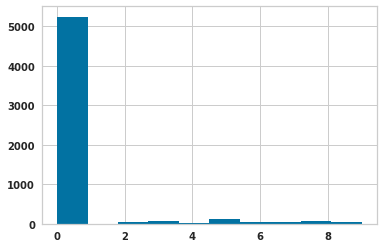

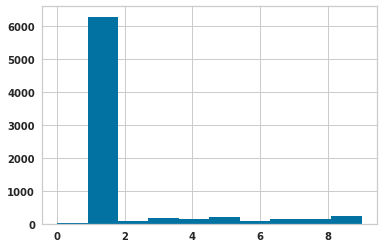

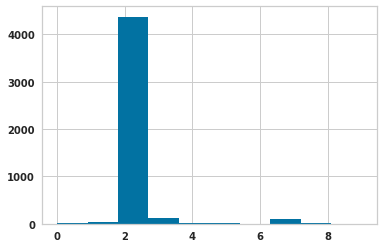

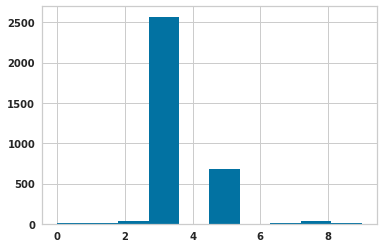

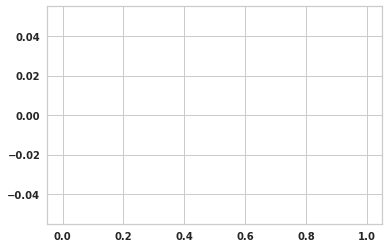

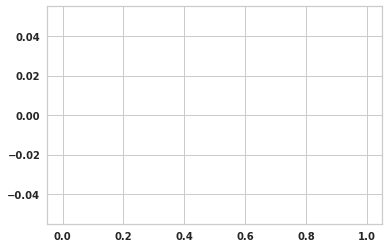

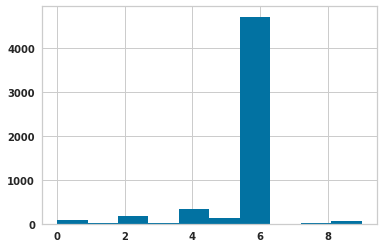

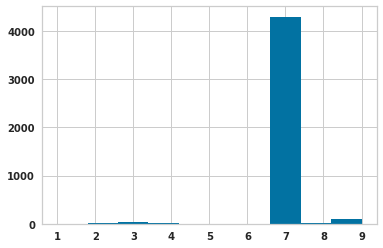

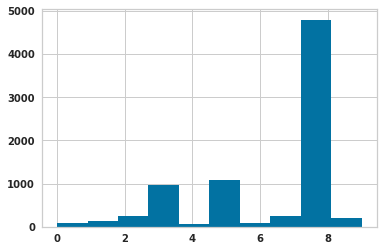

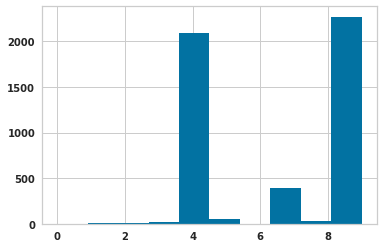

In [119]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [120]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56805
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:06 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS
Number of steps completed=6545
Number of epochs completed 7.0
run_id=2 z_min=-4.9489493 z_max=4.856212
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.

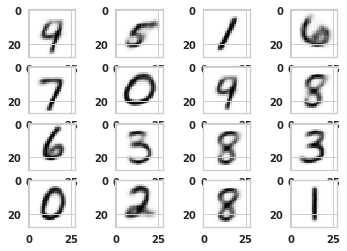

In [121]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


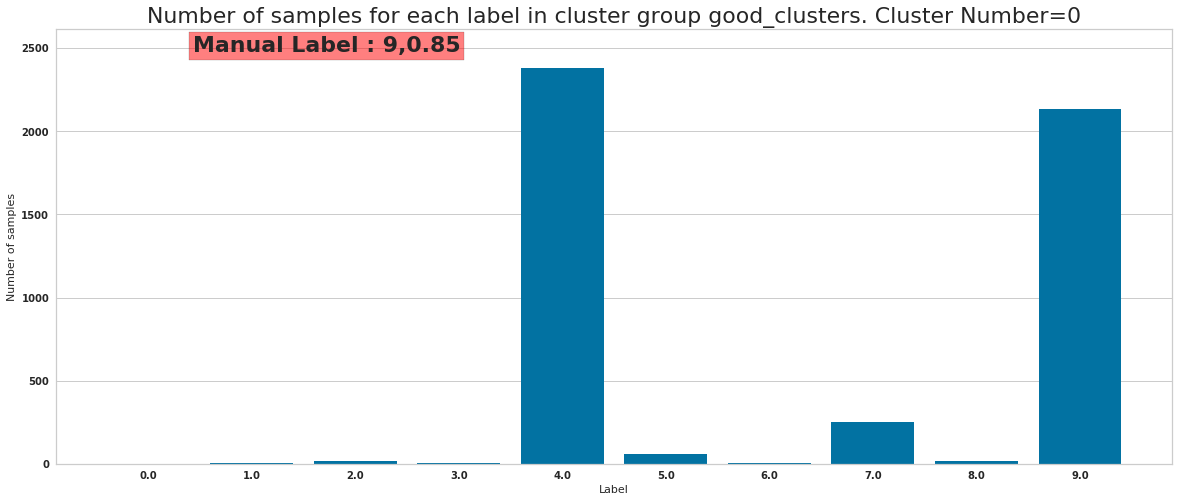

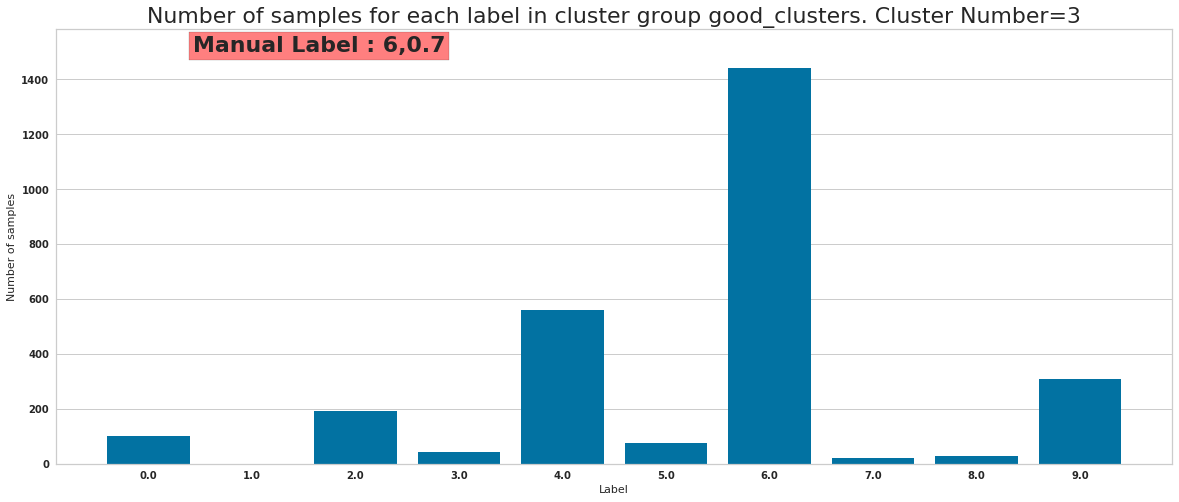

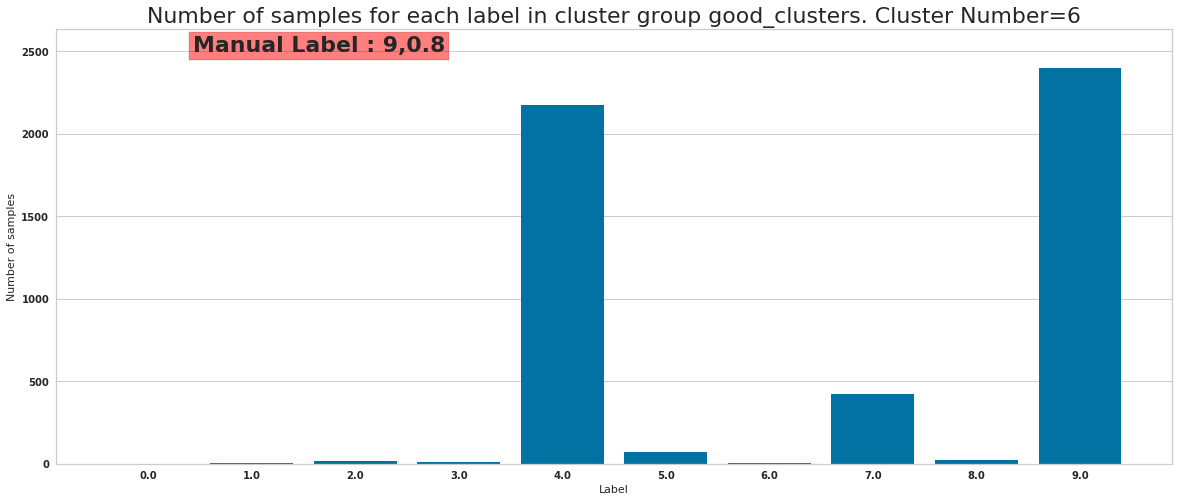

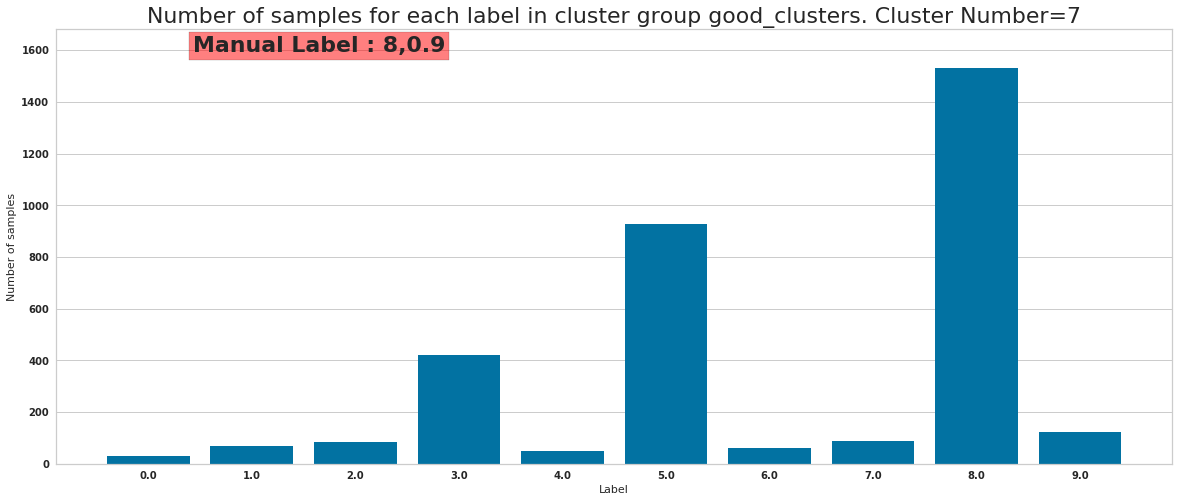

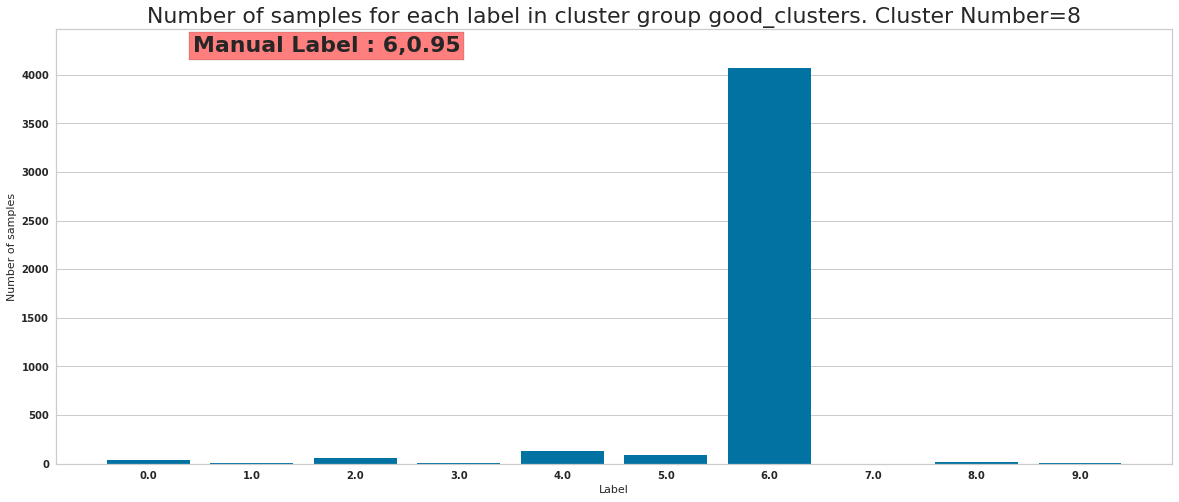

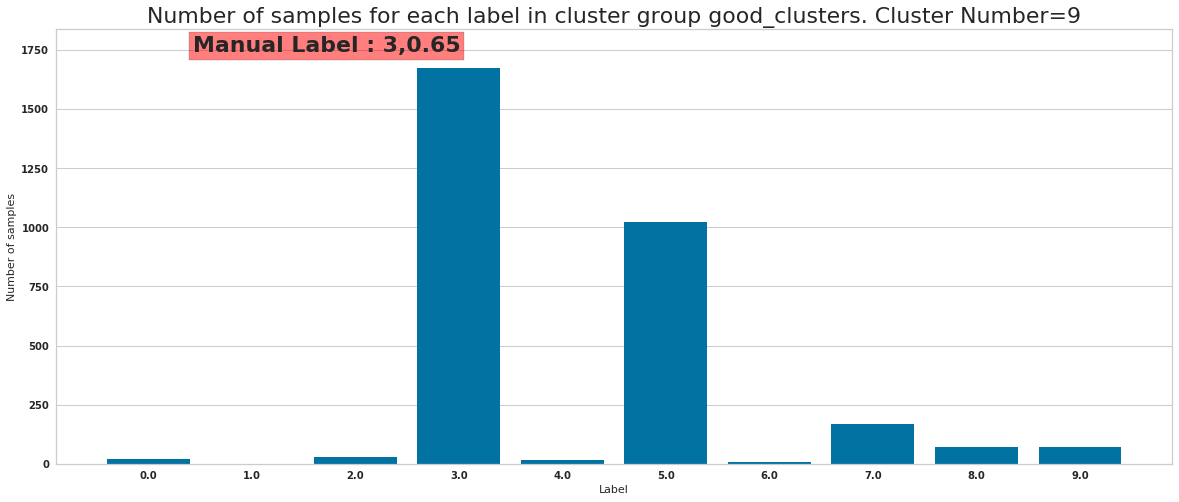

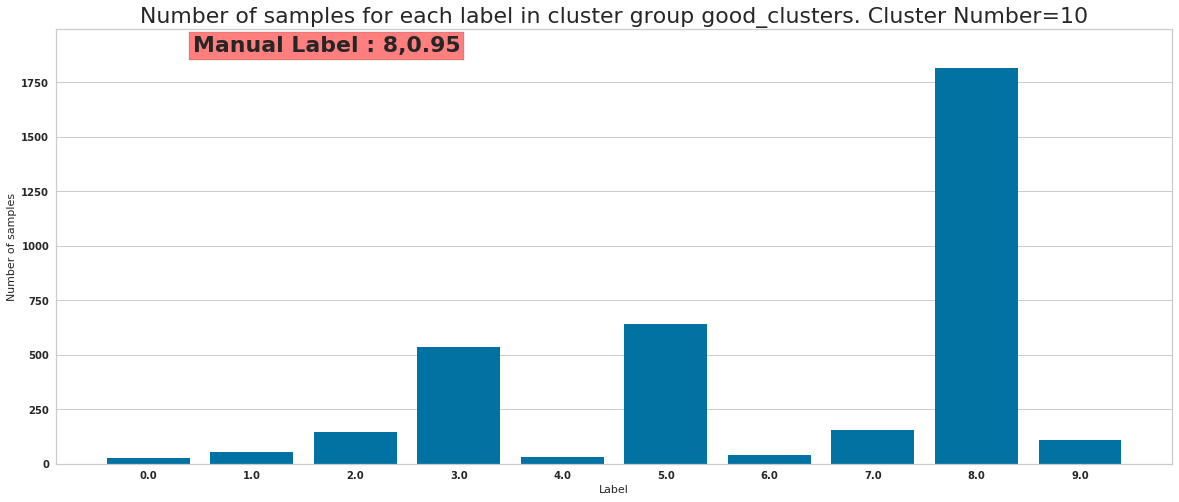

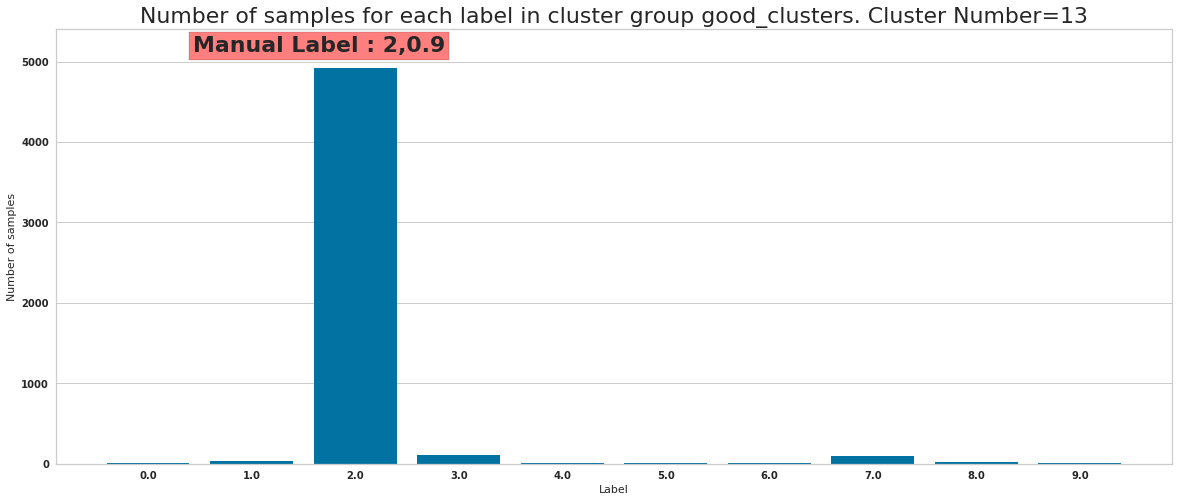

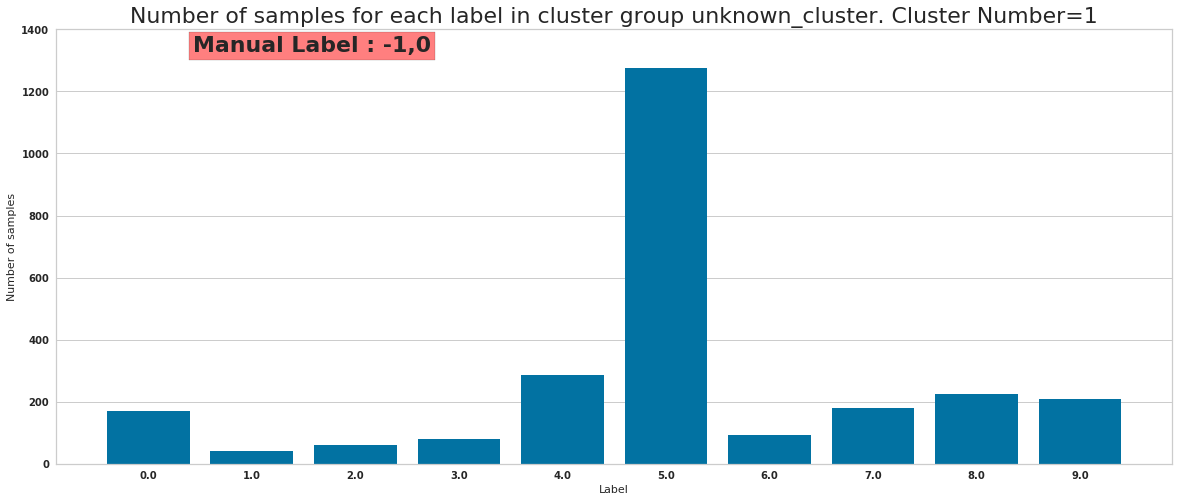

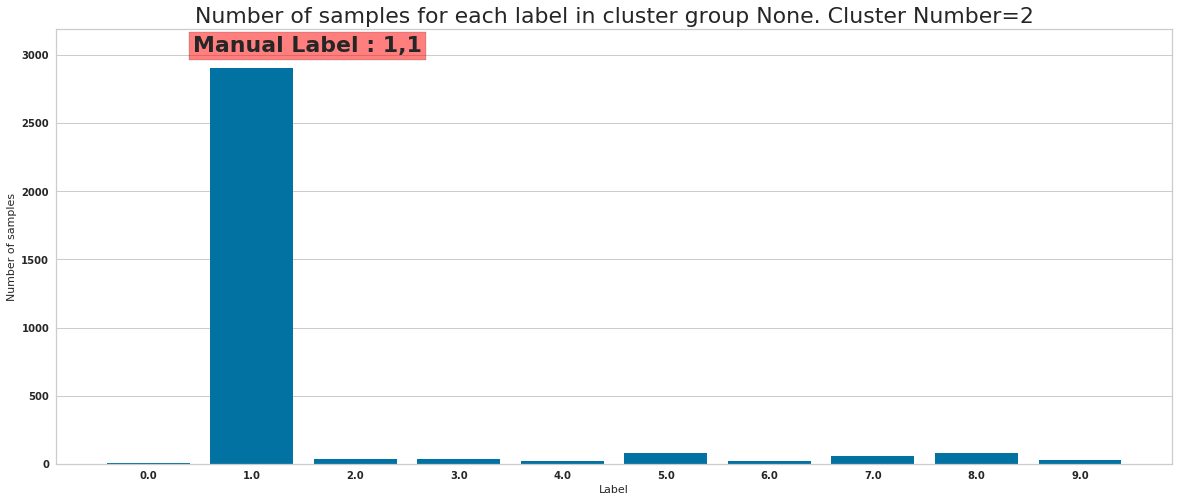

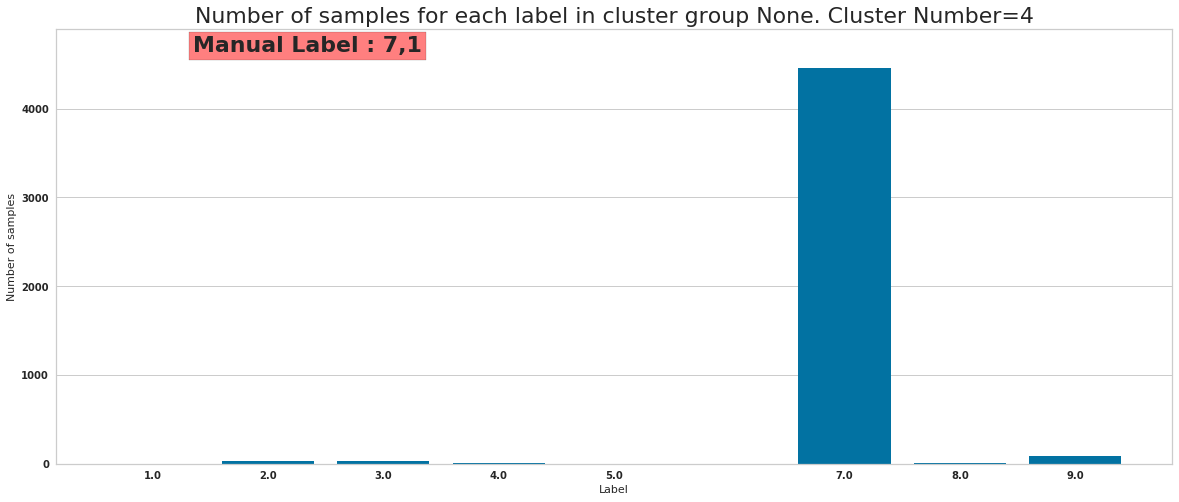

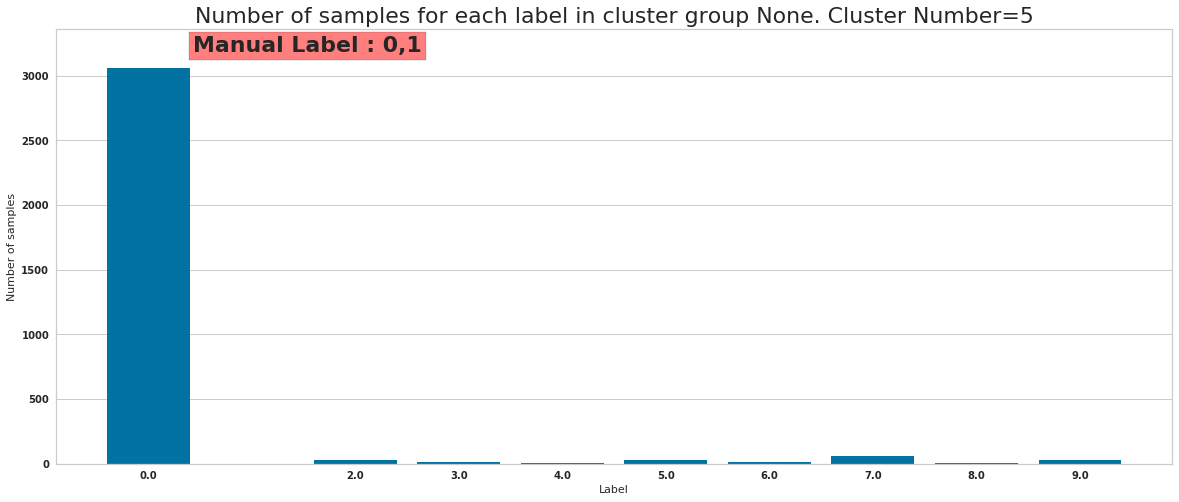

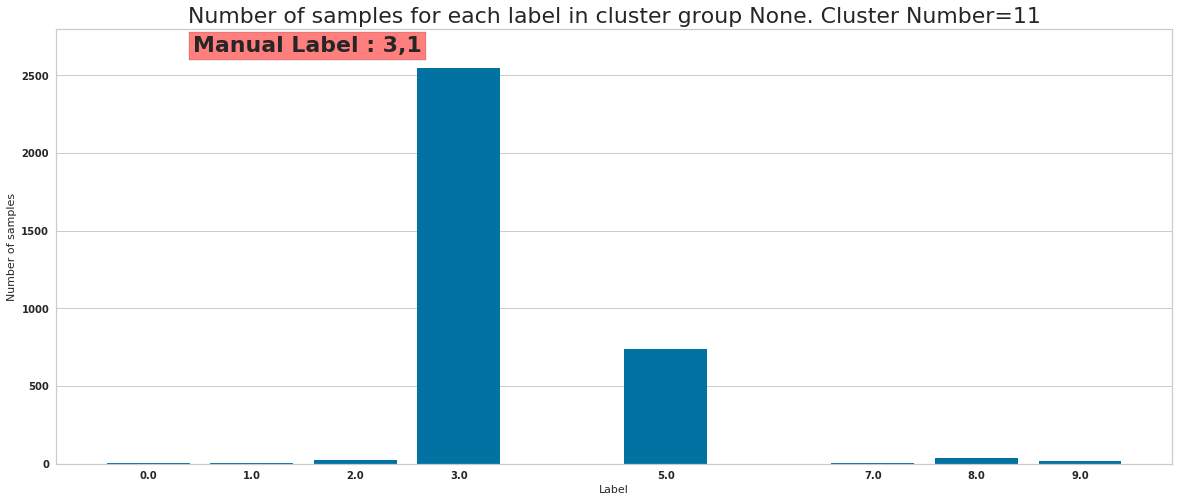

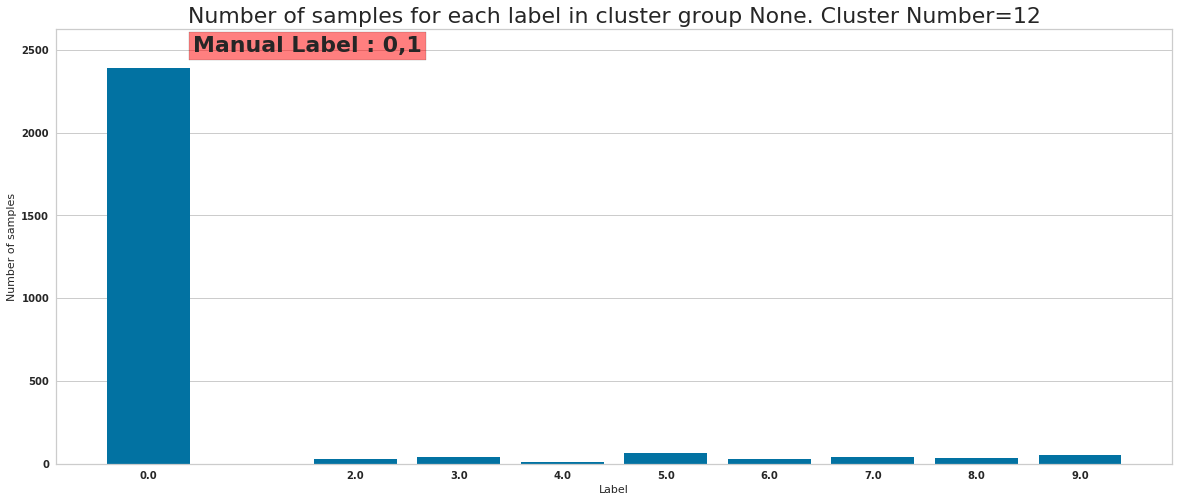

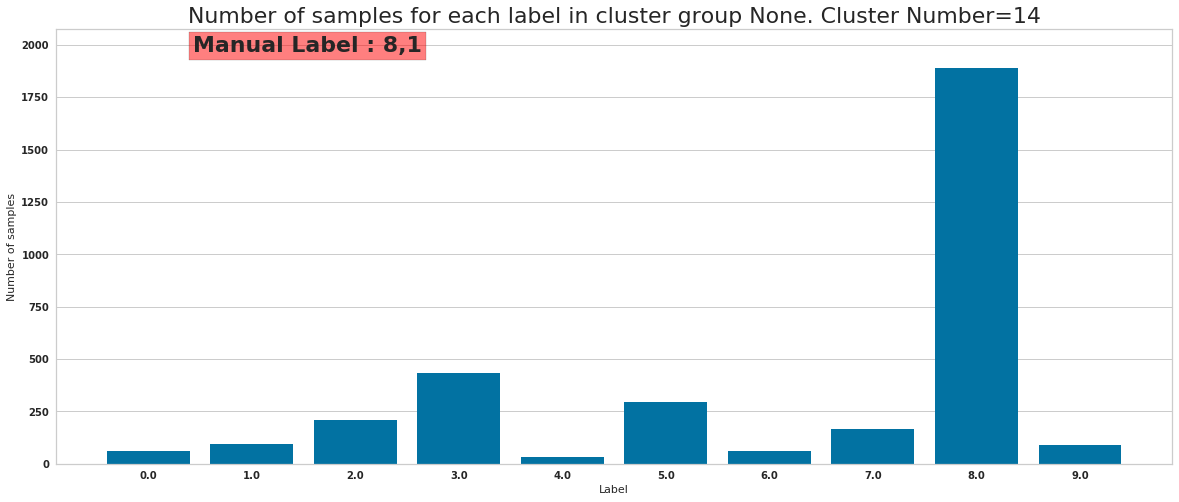

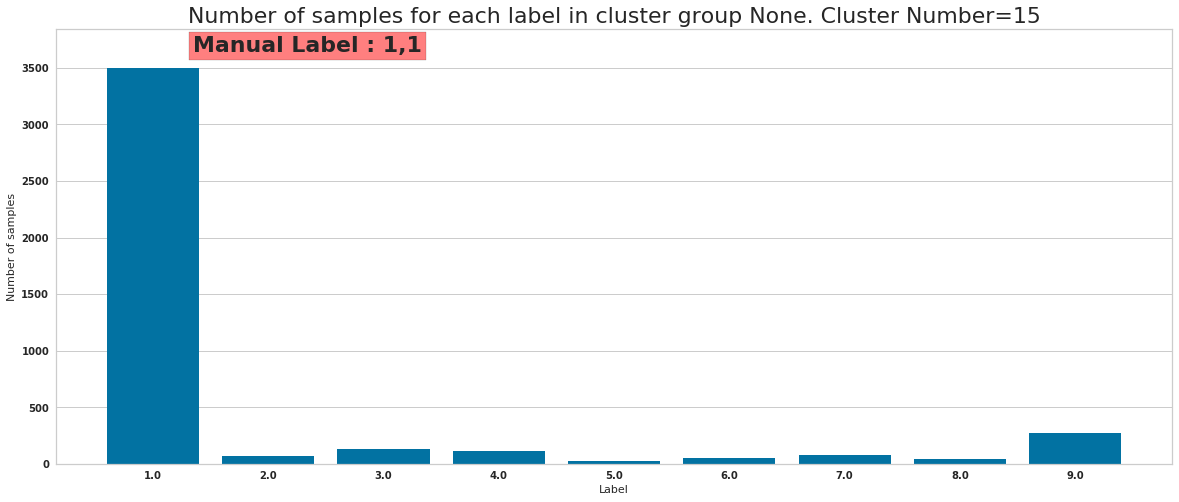

In [122]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,-1,1,6,
                                           7,0,9,8,
                                           6,3,8,3,
                                           0,2,8,1
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0,1,0.7,
                                               1,1,0.8,0.9,
                                               0.95,0.65,0.95,1,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


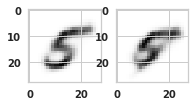

In [123]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [124]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [125]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


1
2
Skipping distance computation for unknown cluster
Manual Label 9
(4878, 54) (4878, 32)
Num correct=2136
Cluster 0 Manual Label 9 Percentage correct 43.788437884378844
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 1
(3259, 54) (3259, 32)
Num correct=2902
Cluster 2 Manual Label 1 Percentage correct 89.04571954587297
********************************
Manual Label 6
(2766, 54) (2766, 32)
Num correct=1440
Cluster 3 Manual Label 6 Percentage correct 52.060737527114966
********************************
Manual Label 7
(4614, 54) (4614, 32)
Num correct=4453
Cluster 4 Manual Label 7 Percentage correct 96.51061985262245
********************************
Manual Label 0
(3247, 54) (3247, 32)
Num correct=3056
Cluster 5 Manual Label 0 Percentage correct 94.11764705882354
********************************
Manual Label 9
(9998, 54) (5120, 32)
Num correct=4532
Cluster 6 Manual Label 9 Percentage correct 45.329065813162636
******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

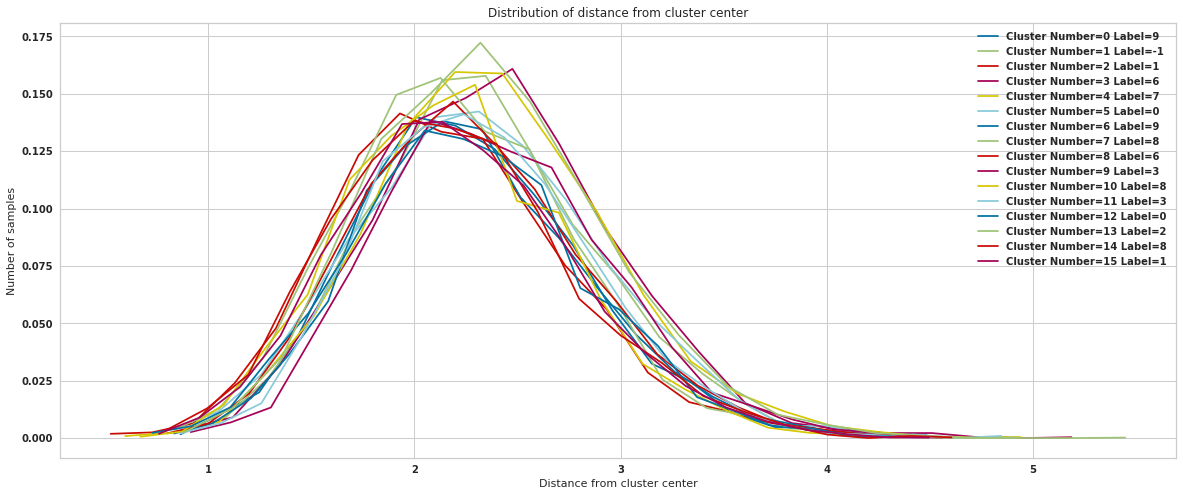

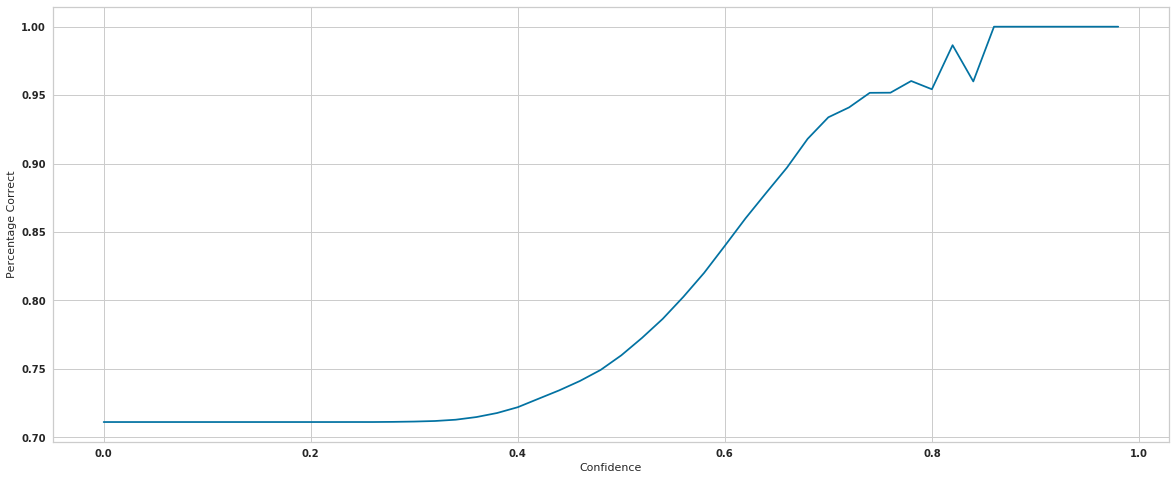

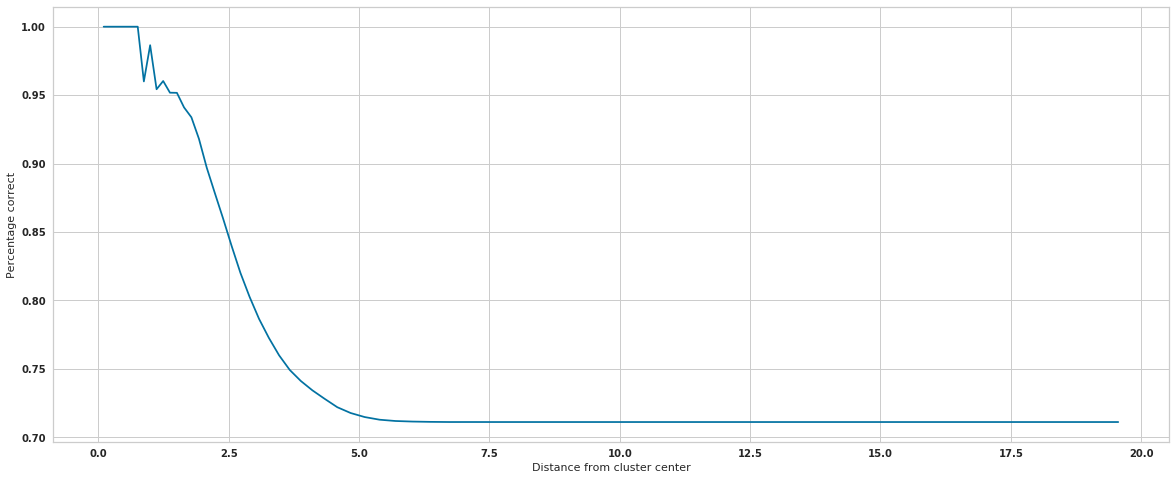

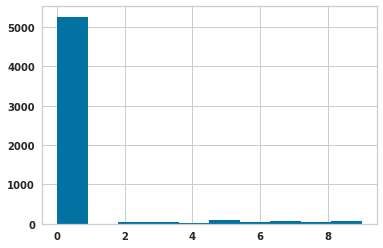

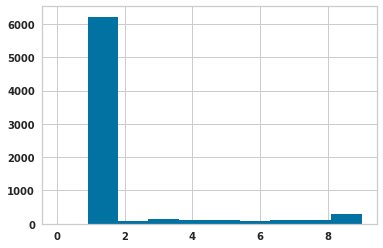

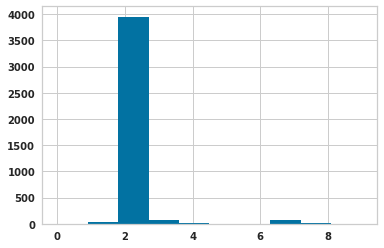

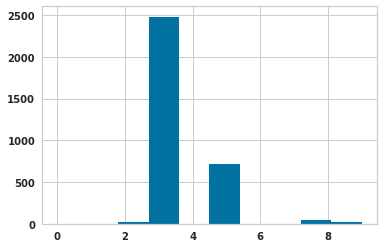

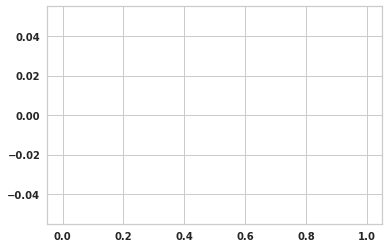

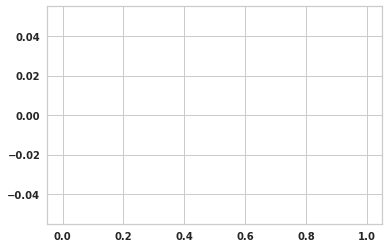

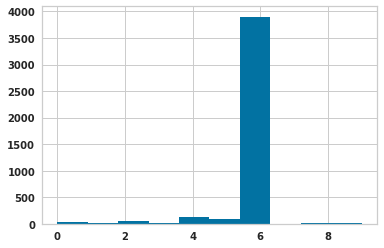

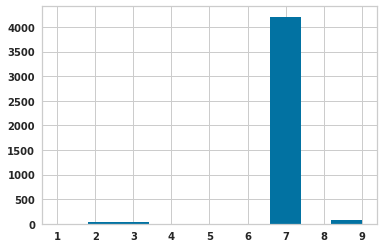

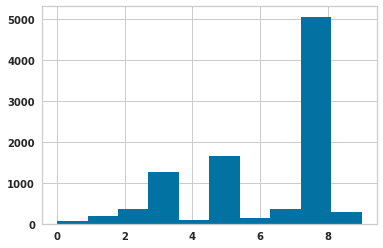

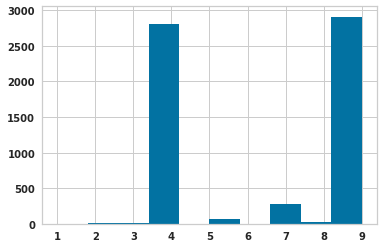

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [127]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 57217
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-7480
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-7480
 [*] Success to read ClassifierModel.model-7480
 [*] Load SUCCESS
Number of steps completed=7480
Number of epochs completed 8.0
run_id=2 z_min=-4.4770355 z_max=4.1615150000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergenc

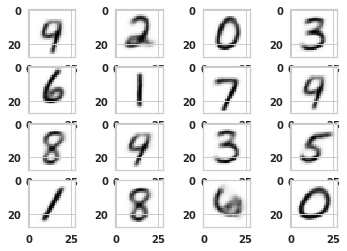

In [128]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


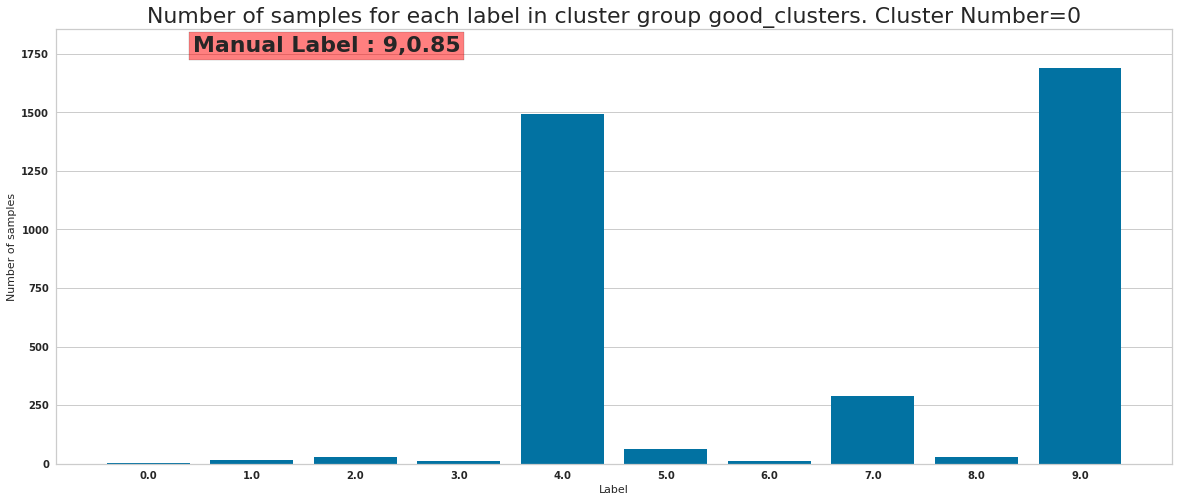

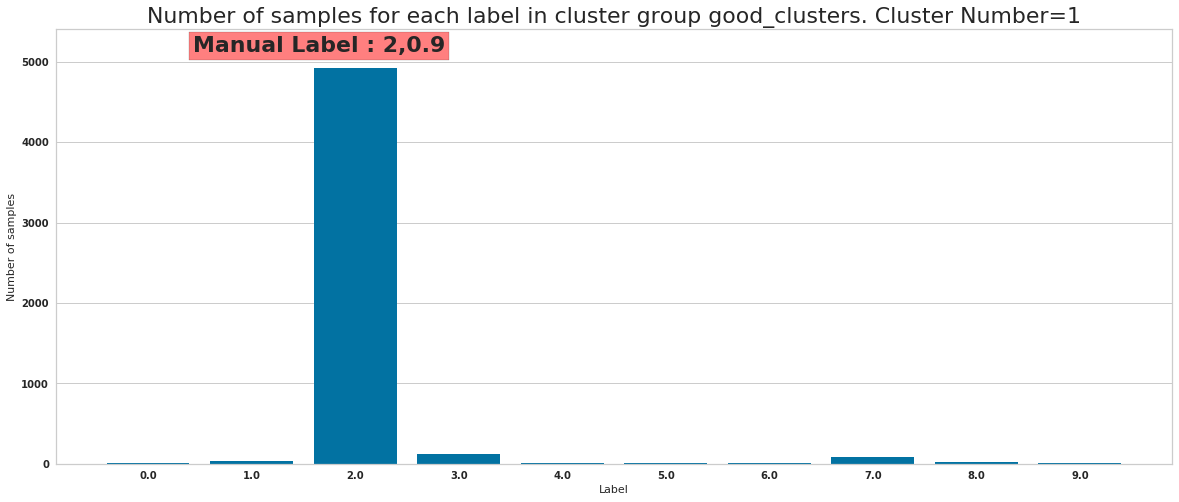

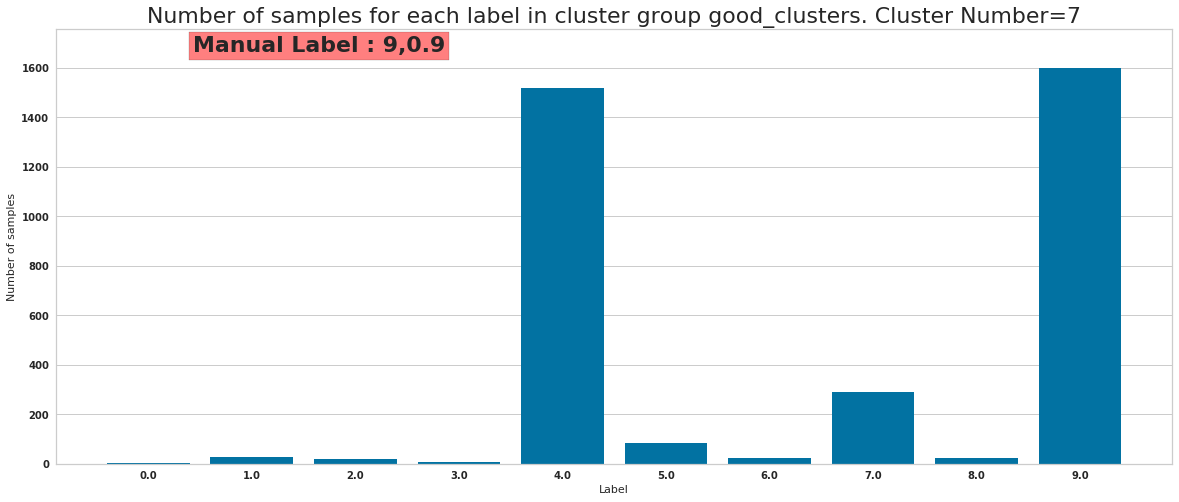

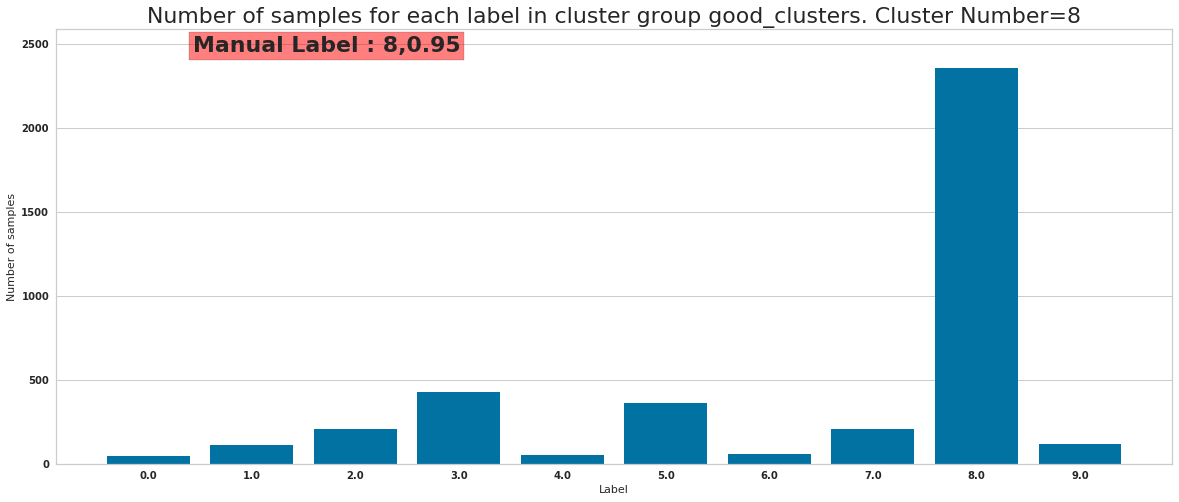

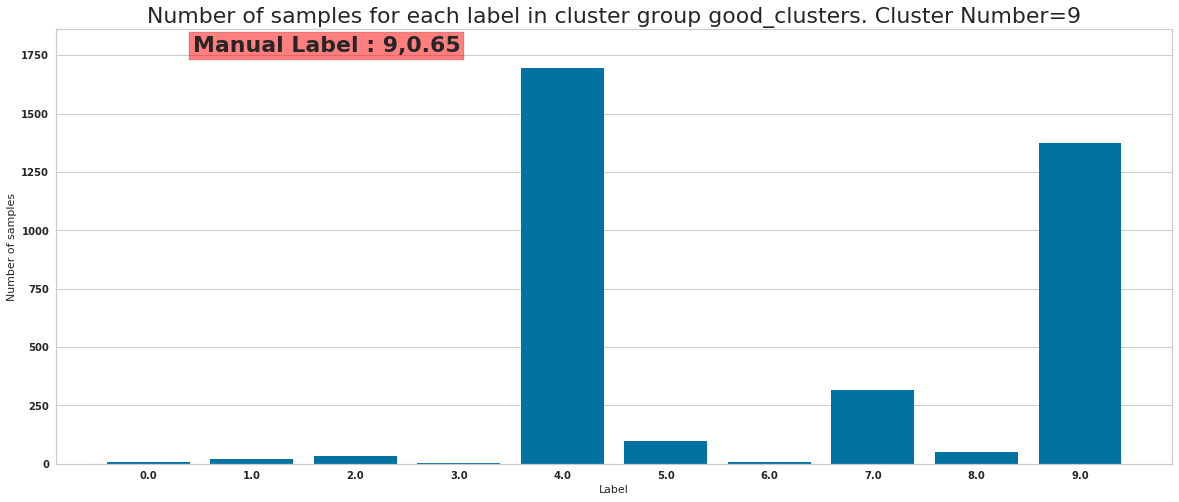

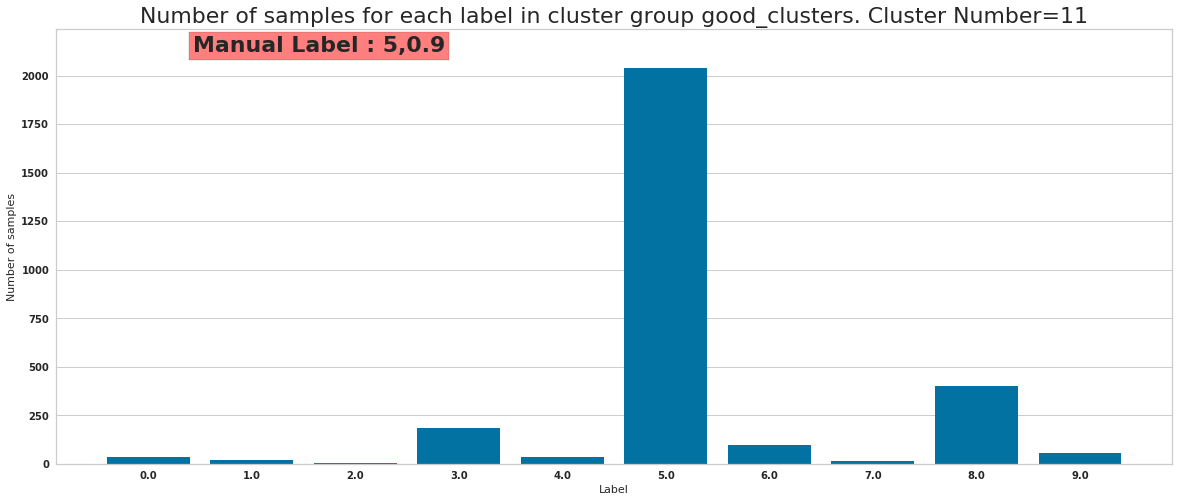

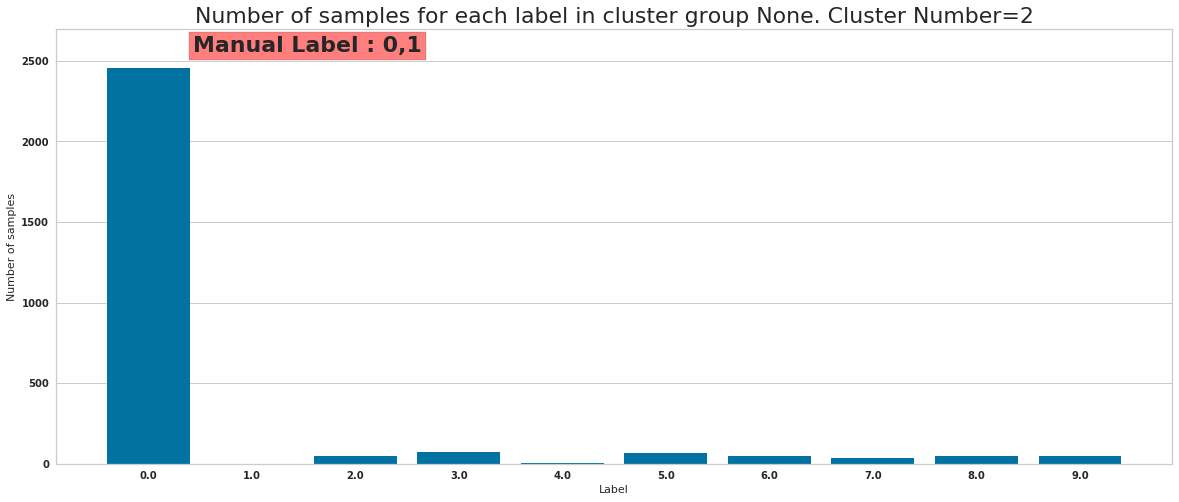

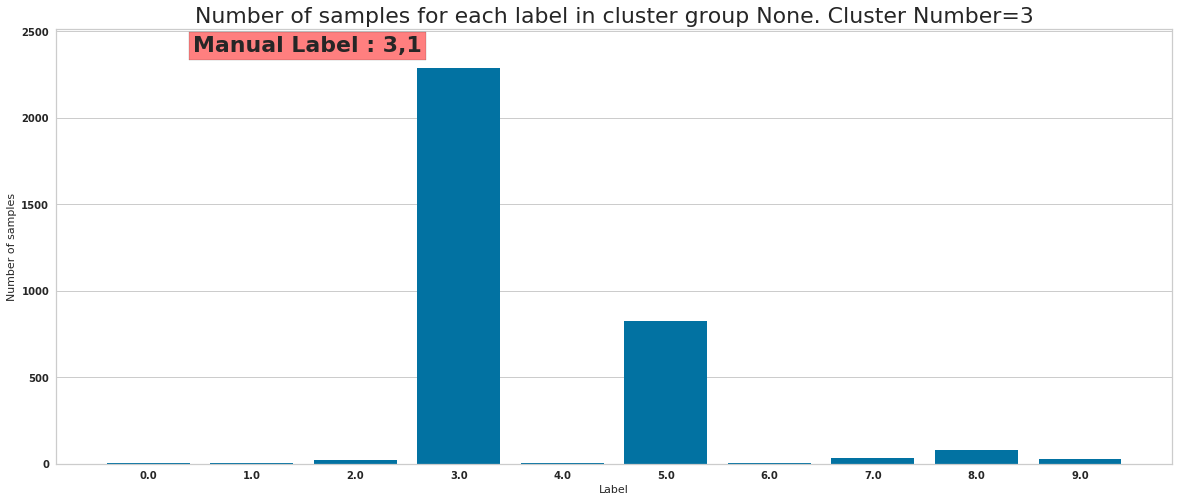

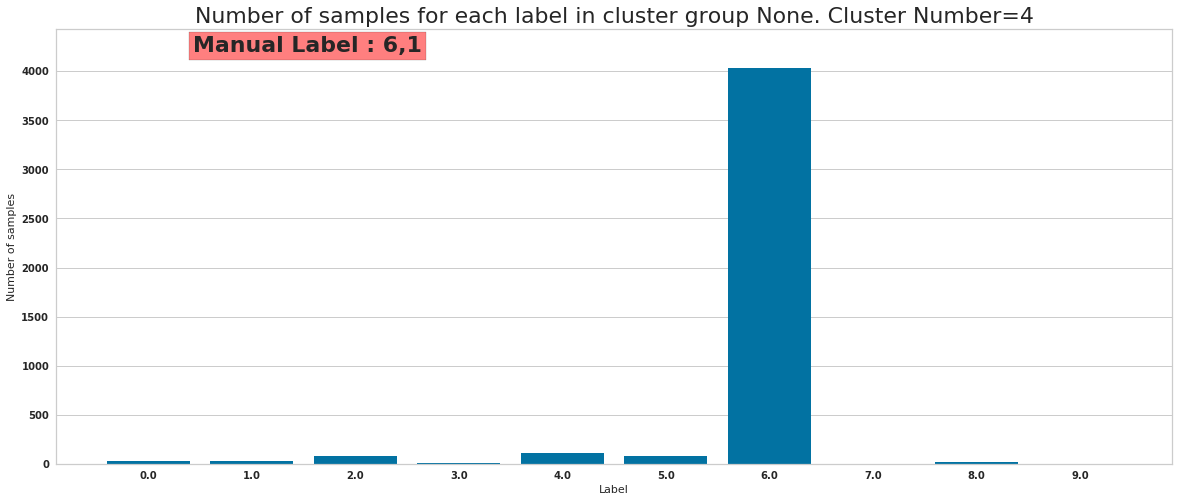

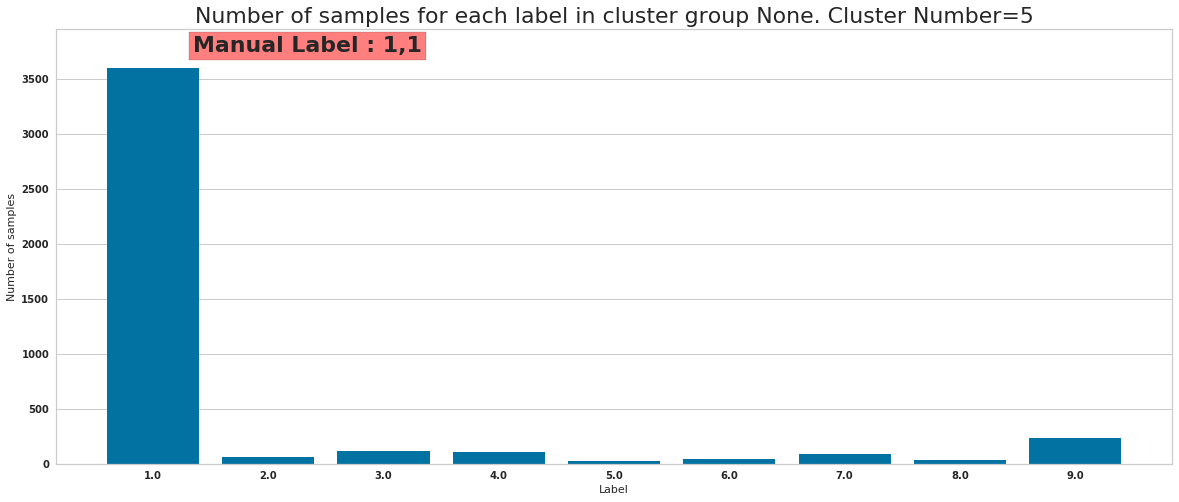

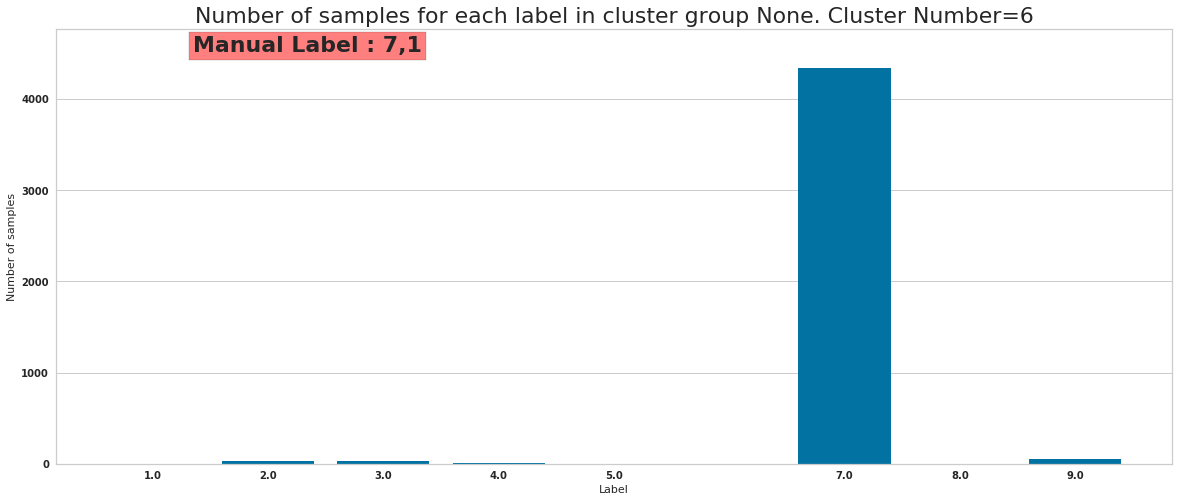

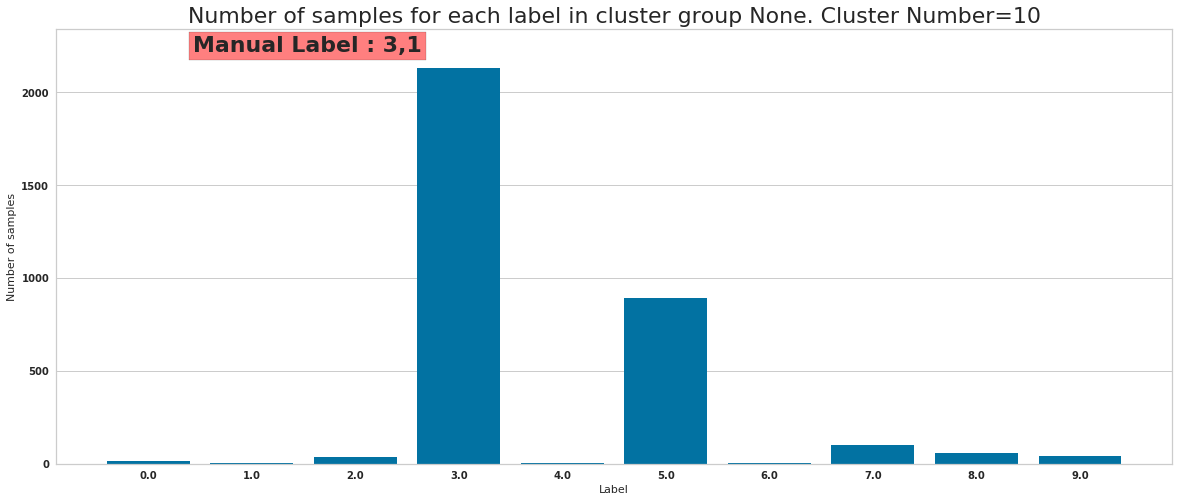

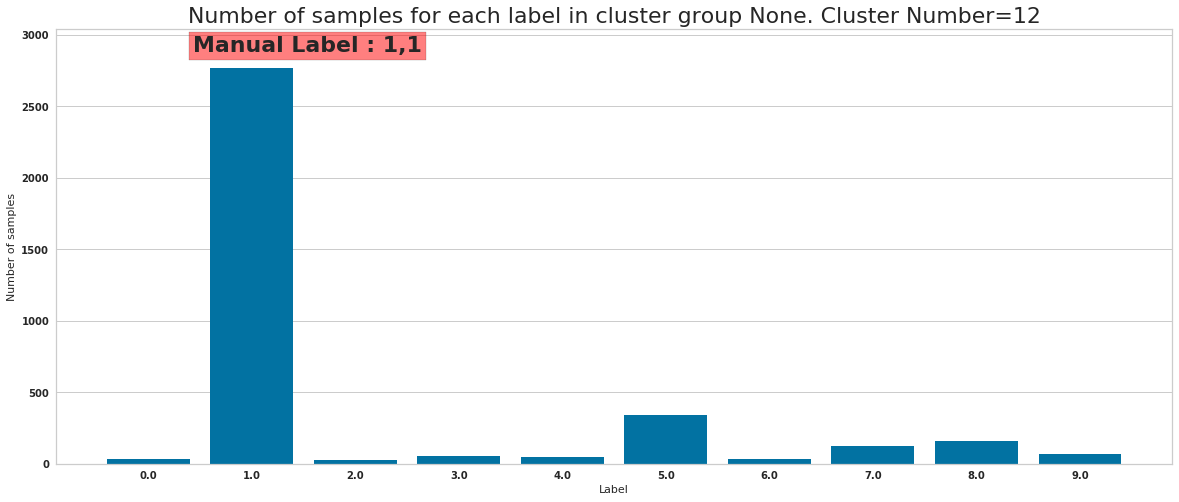

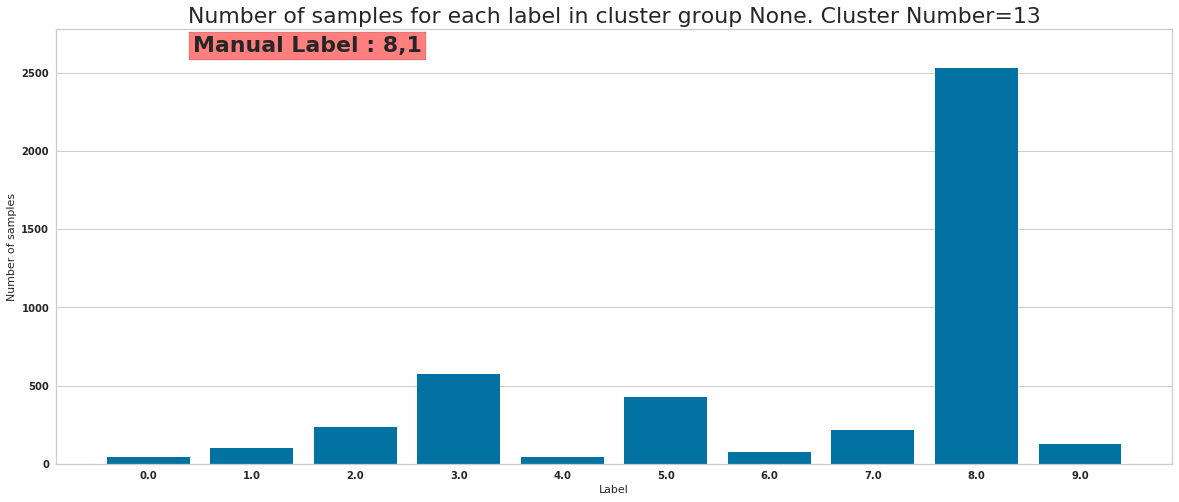

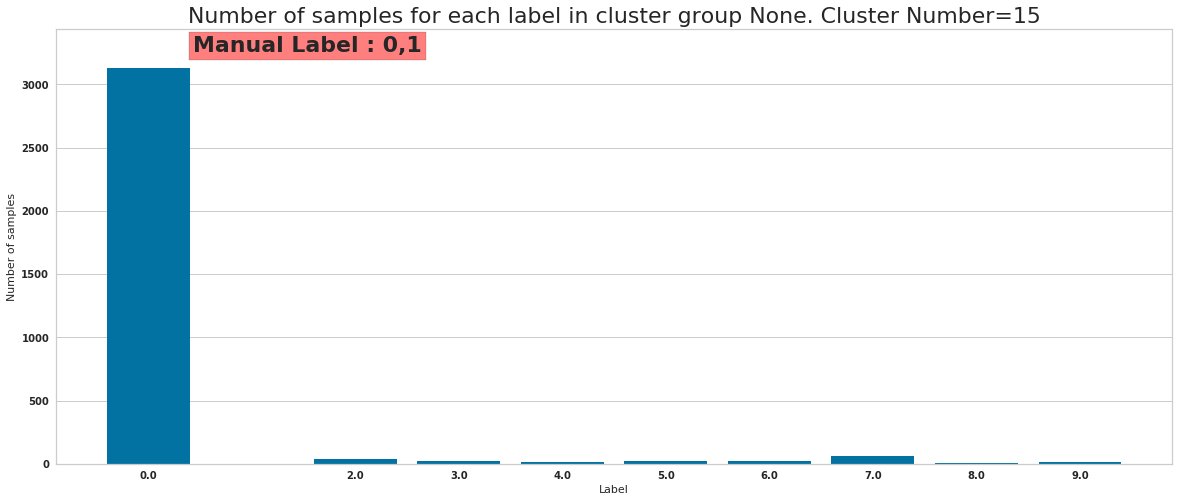

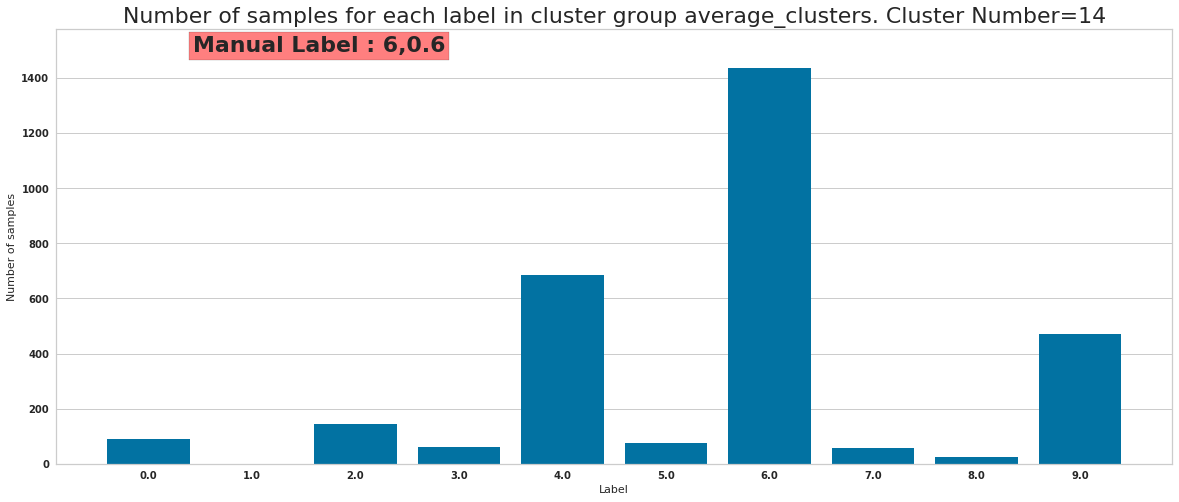

In [129]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,2,0,3,
                                           6,1,7,9,
                                           8,9,3,5,
                                           1,8,6,0
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0.9,1,1,
                                               1,1,1,0.9,
                                               0.95,0.65,1,0.9,
                                               1,1,0.6,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [130]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [132]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


Manual Label 9
(3640, 52) (3640, 32)
Num correct=1687
Cluster 0 Manual Label 9 Percentage correct 46.34615384615385
********************************
Manual Label 2
(5220, 52) (5220, 32)
Num correct=4917
Cluster 1 Manual Label 2 Percentage correct 94.19540229885058
********************************
Manual Label 0
(2829, 52) (2829, 32)
Num correct=2452
Cluster 2 Manual Label 0 Percentage correct 86.67373630258042
********************************
Manual Label 3
(3291, 52) (3291, 32)
Num correct=2285
Cluster 3 Manual Label 3 Percentage correct 69.43178365238529
********************************
Manual Label 6
(4384, 52) (4384, 32)
Num correct=4028
Cluster 4 Manual Label 6 Percentage correct 91.87956204379562
********************************
Manual Label 1
(4299, 52) (4299, 32)
Num correct=3592
Cluster 5 Manual Label 1 Percentage correct 83.55431495696673
********************************
Manual Label 7
(4472, 52) (4472, 32)
Num correct=4336
Cluster 6 Manual Label 7 Percentage correct 96.95885

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

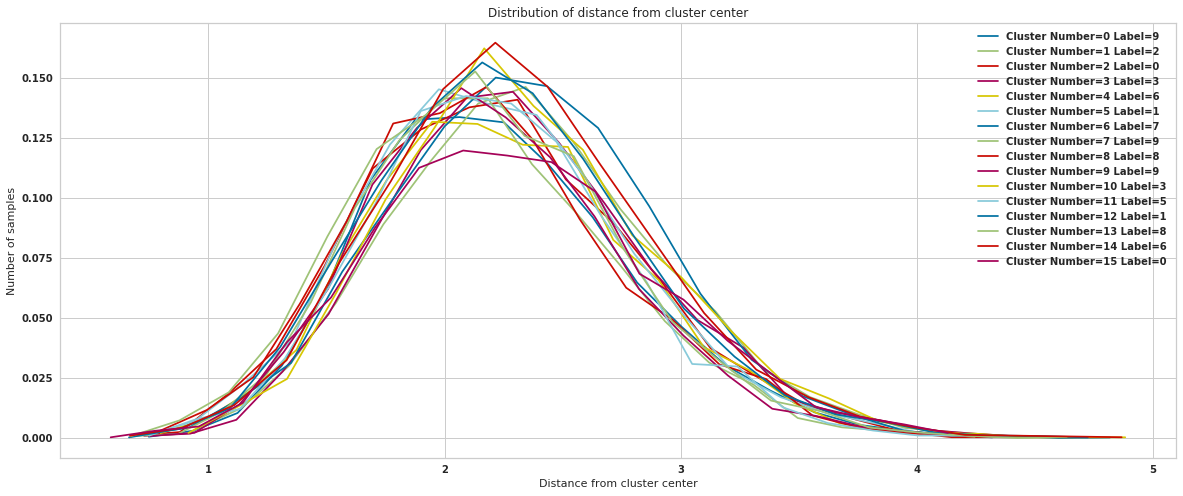

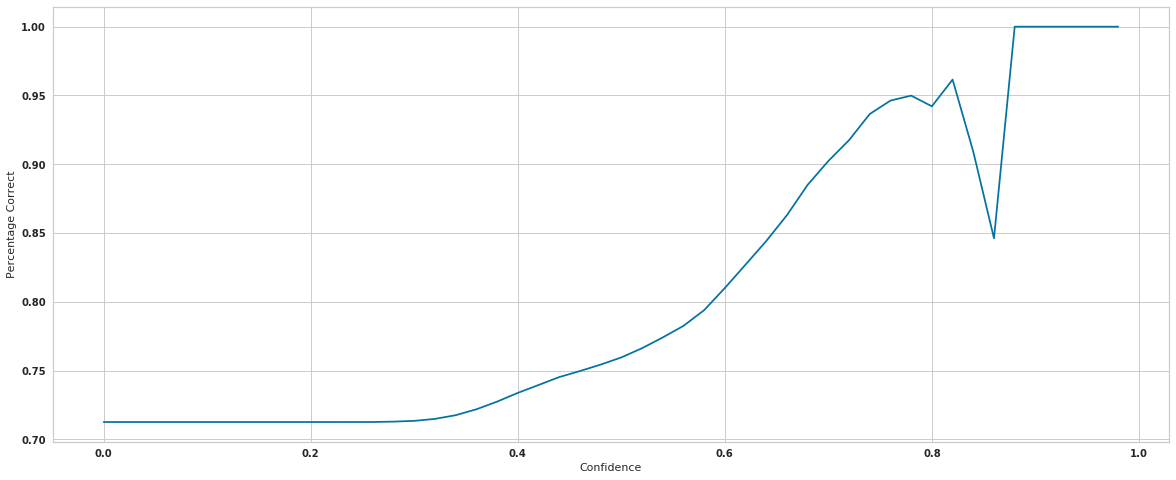

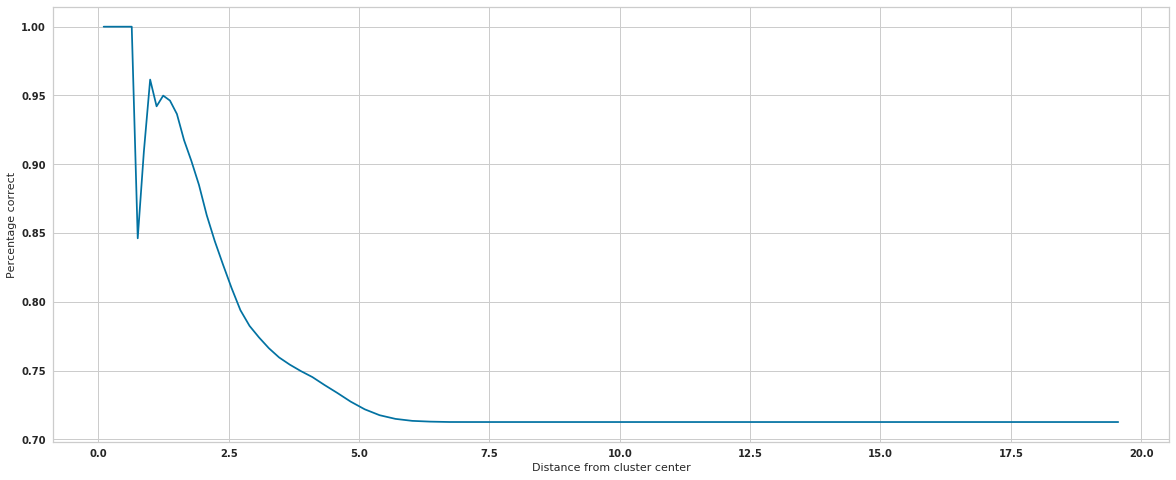

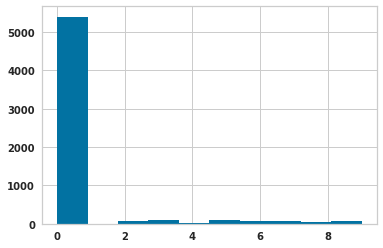

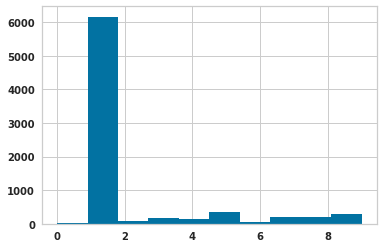

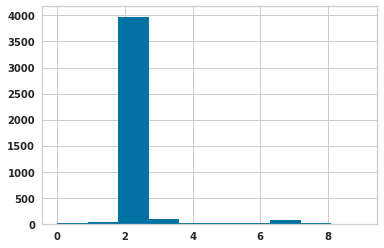

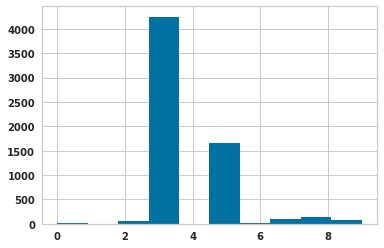

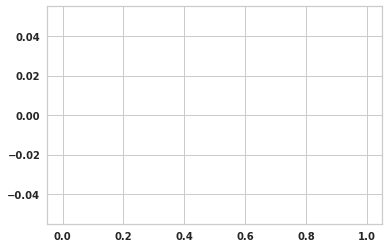

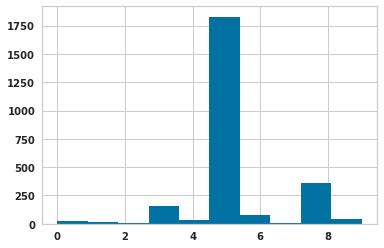

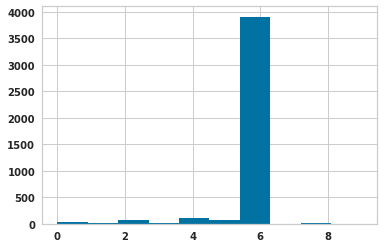

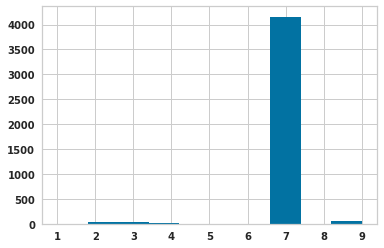

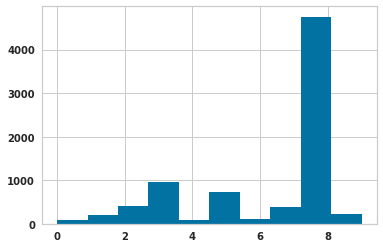

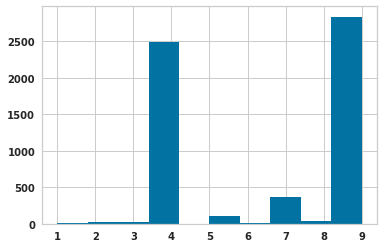

In [133]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [134]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:08 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS
Number of steps completed=8415
Number of epochs completed 9.0
run_id=2 z_min=-4.340634 z_max=4.580414
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.


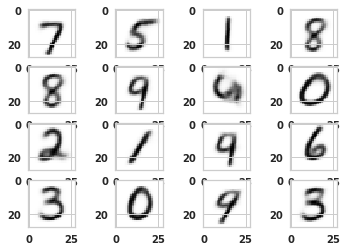

In [135]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


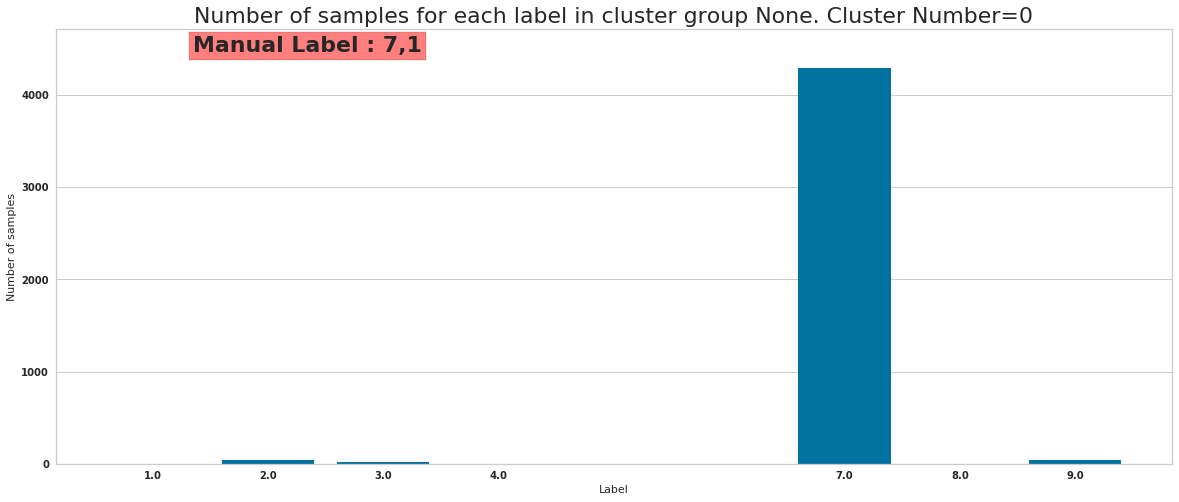

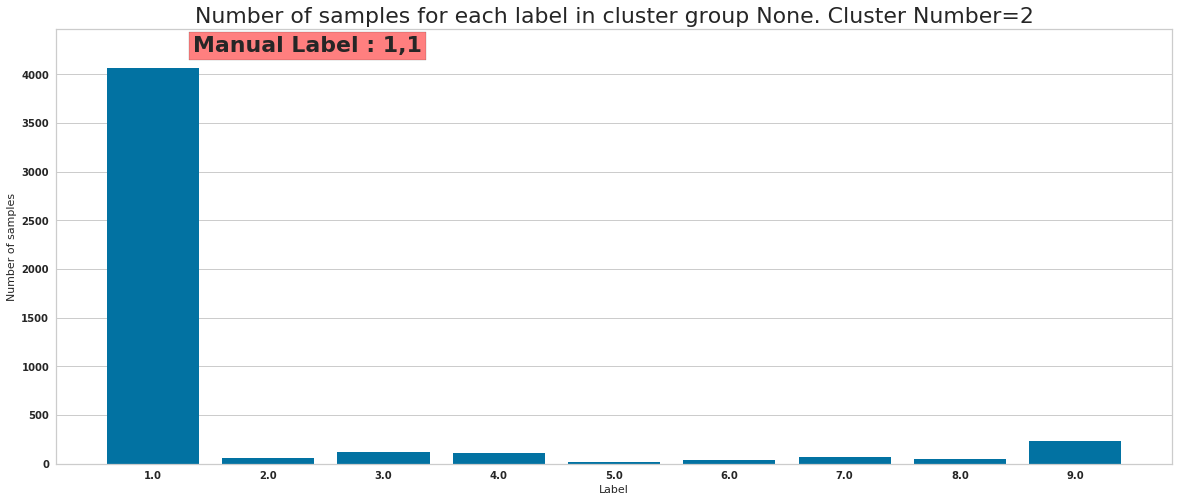

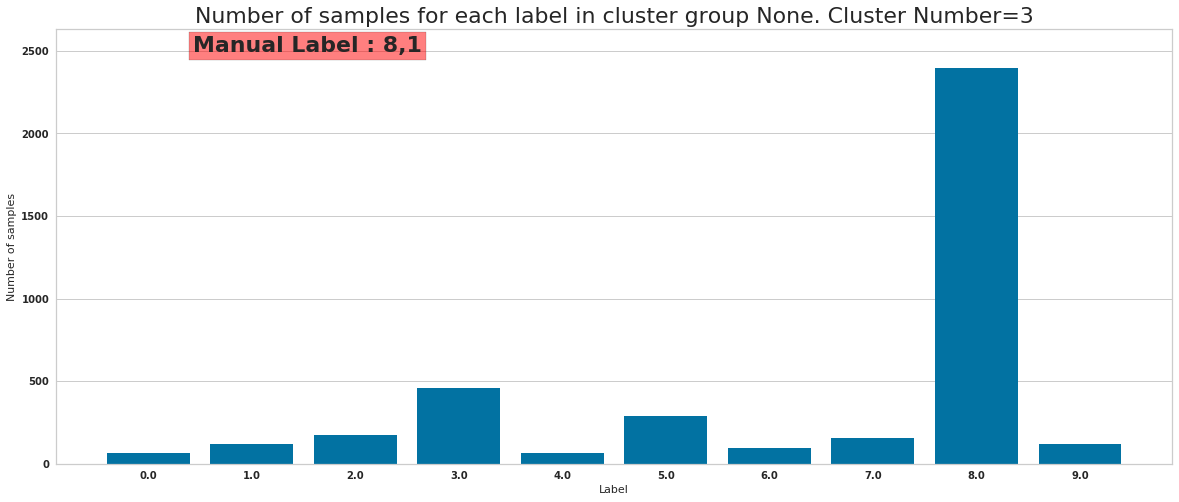

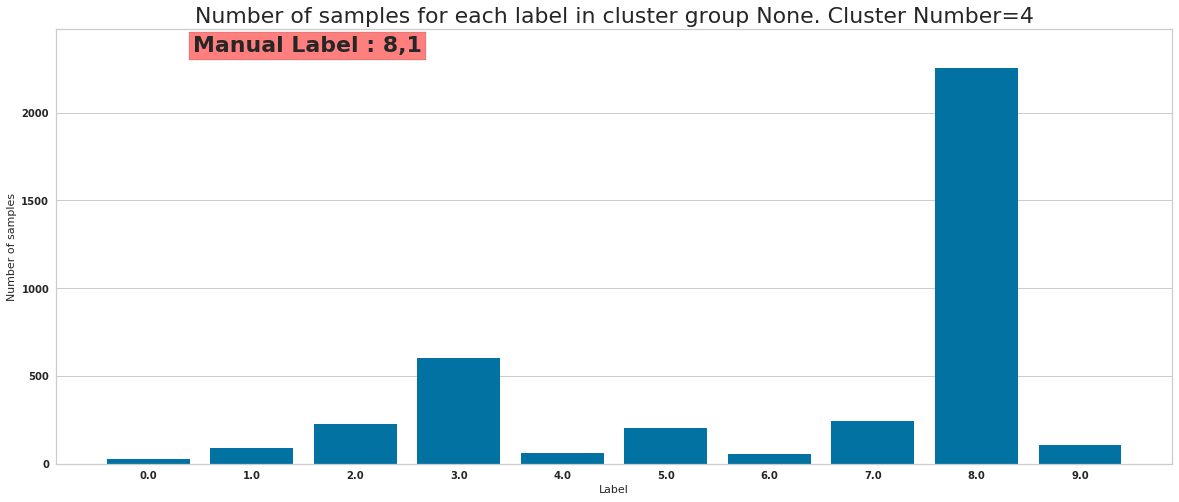

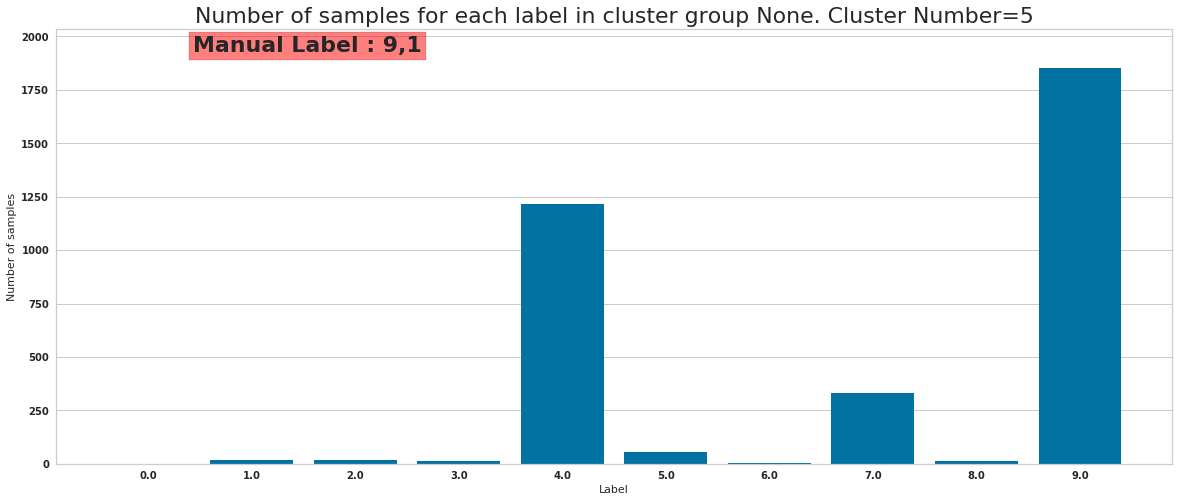

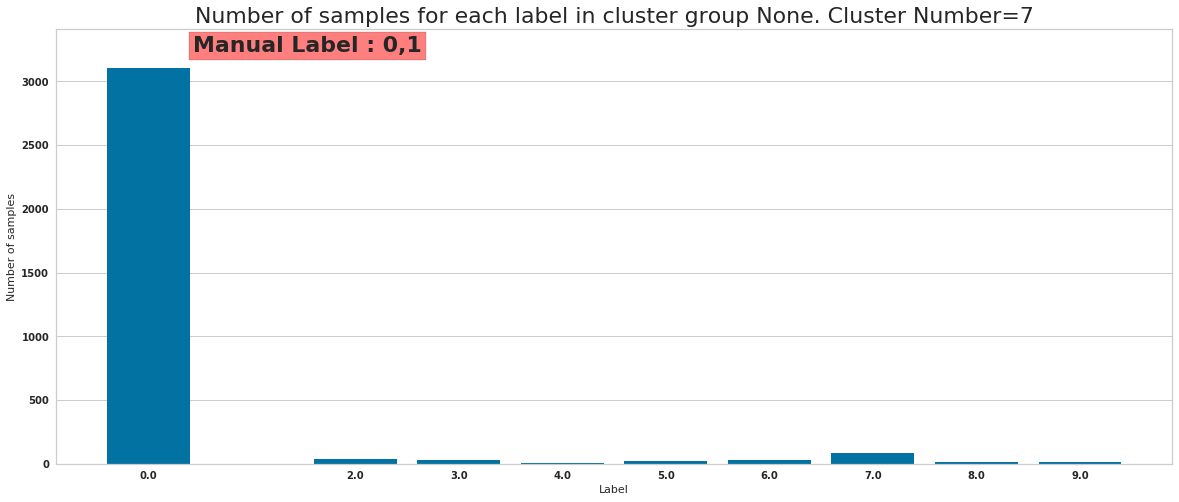

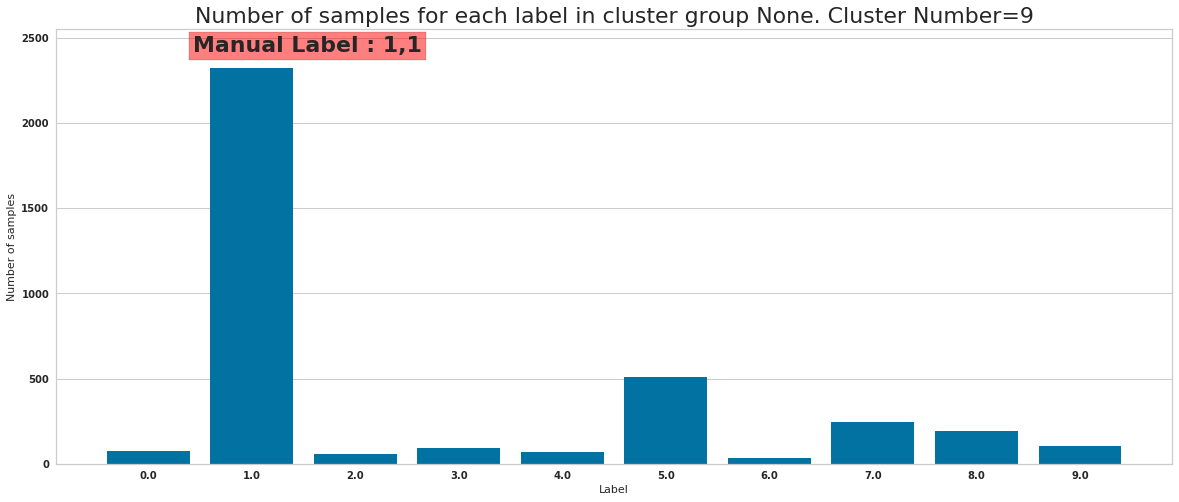

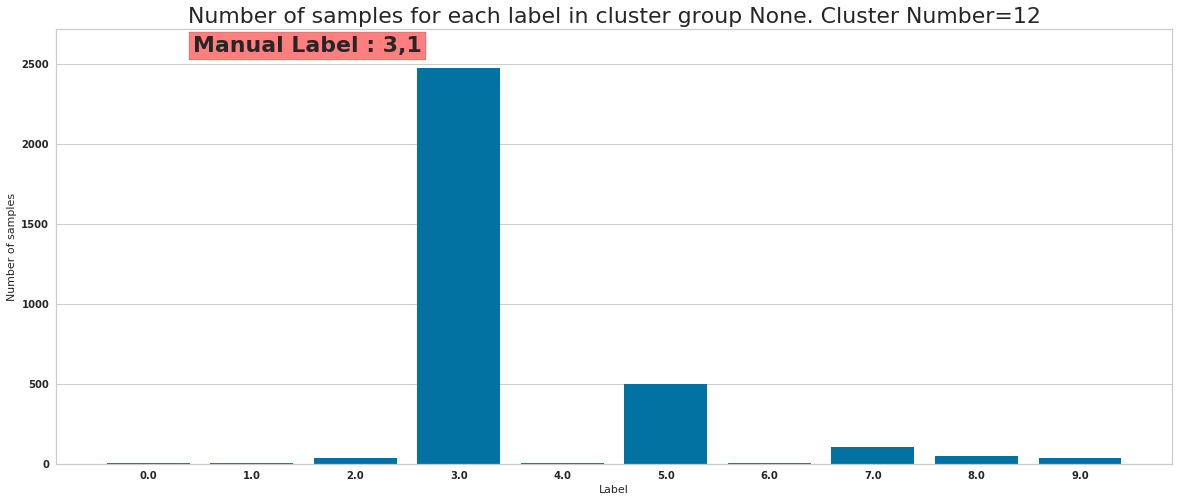

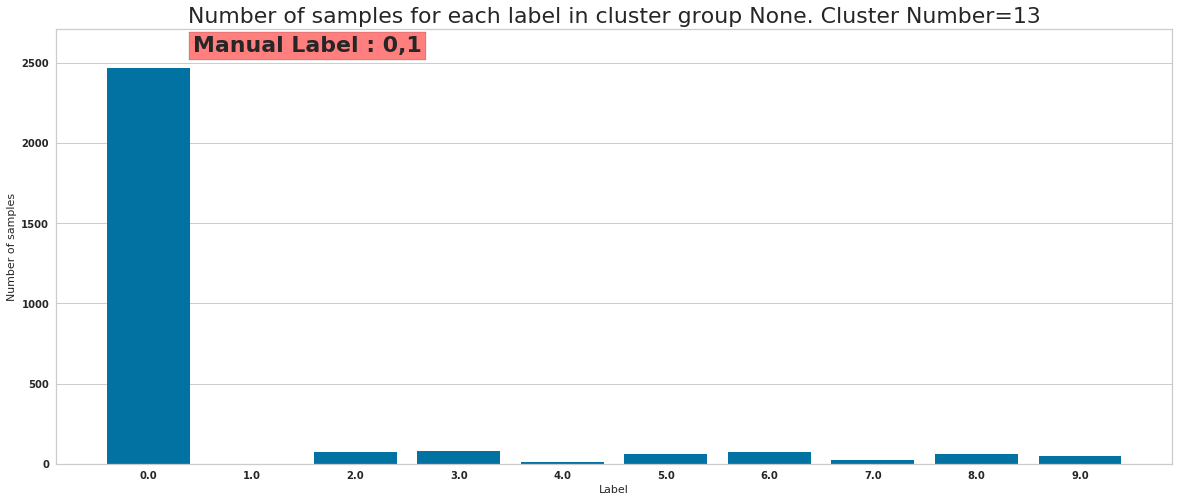

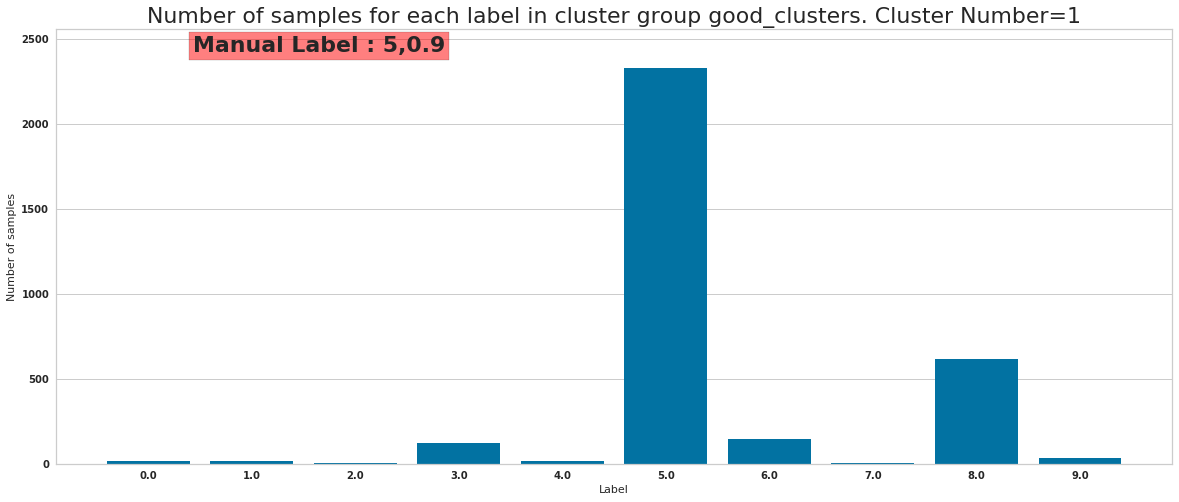

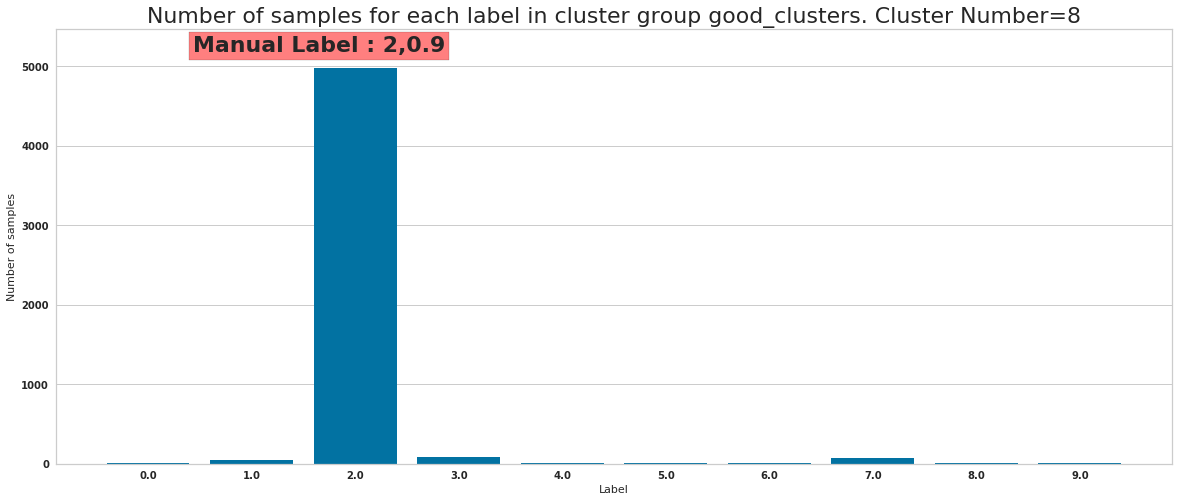

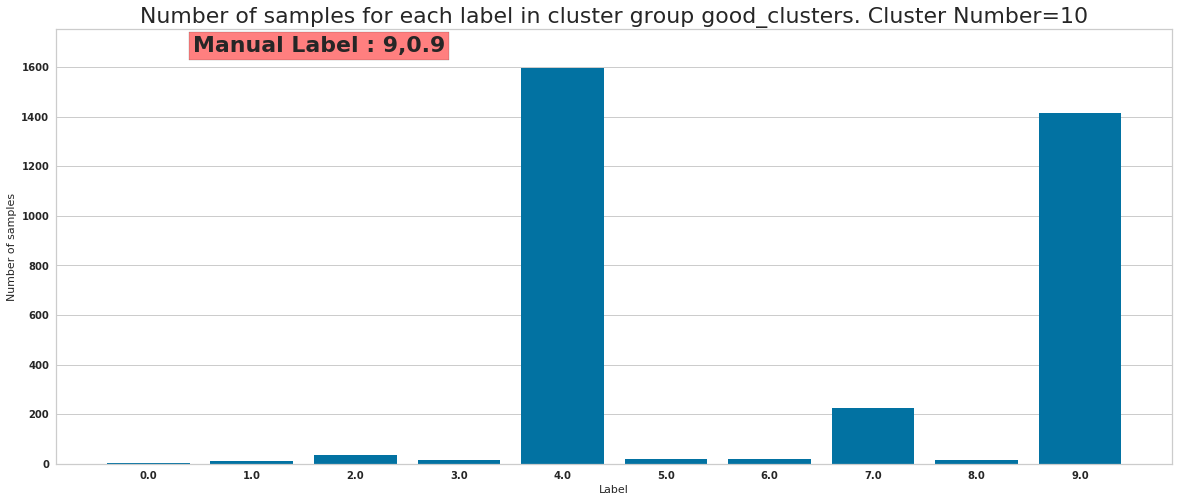

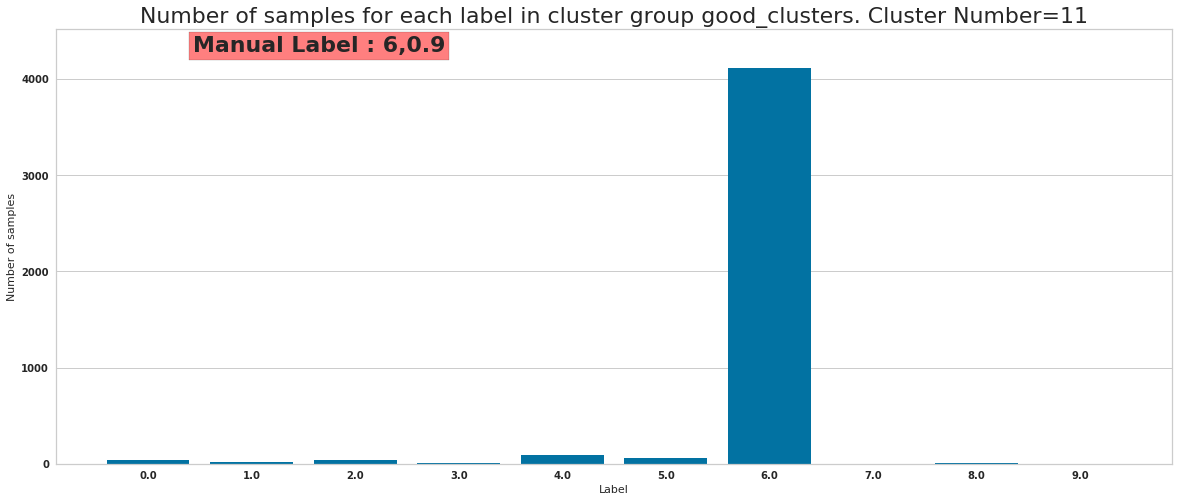

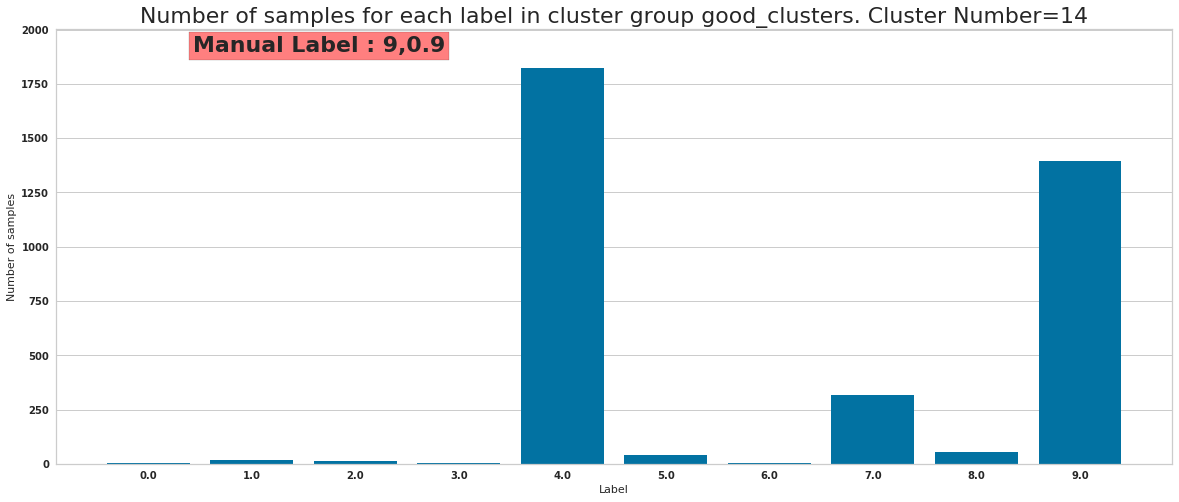

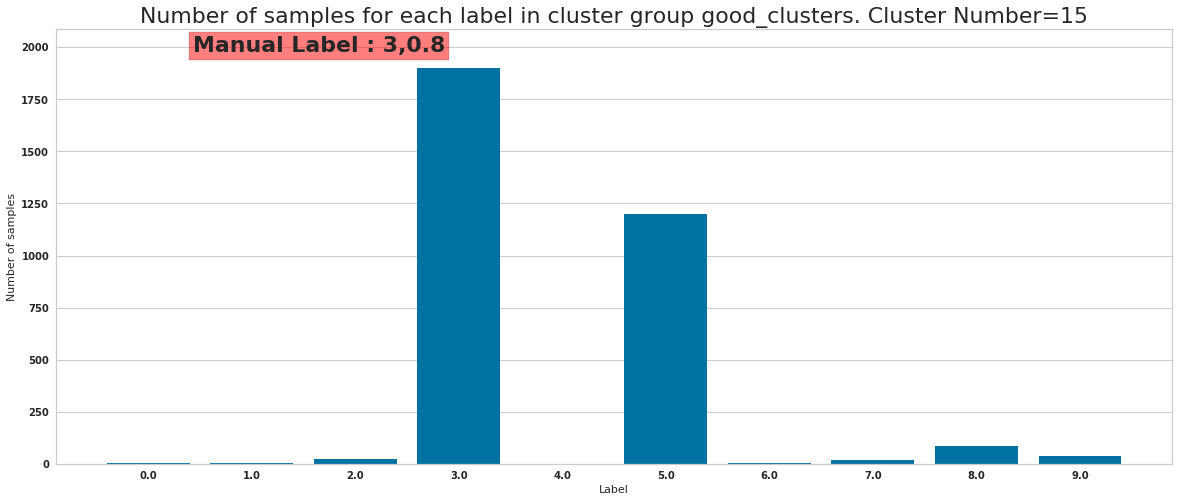

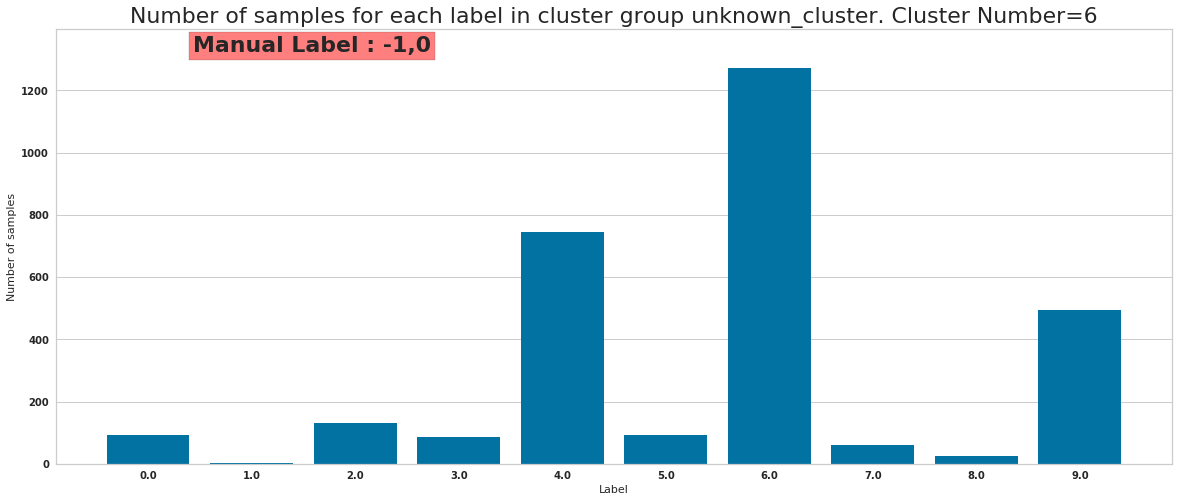

In [136]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,5,1,8,
                                           8,9,-1,0,
                                           2,1,9,6,
                                           3,0,9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,1,
                                               1,1,0,1,
                                               0.9,1,0.9,0.9,
                                               1,1,0.9,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


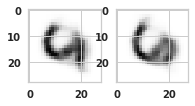

In [137]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [138]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [139]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


6
2
Skipping distance computation for unknown cluster
Manual Label 7
(4396, 54) (4396, 32)
Num correct=4285
Cluster 0 Manual Label 7 Percentage correct 97.47497725204731
********************************
Manual Label 5
(3305, 54) (3305, 32)
Num correct=2327
Cluster 1 Manual Label 5 Percentage correct 70.40847201210288
********************************
Manual Label 1
(4762, 54) (4762, 32)
Num correct=4061
Cluster 2 Manual Label 1 Percentage correct 85.27929441411172
********************************
Manual Label 8
(3938, 54) (3938, 32)
Num correct=2393
Cluster 3 Manual Label 8 Percentage correct 60.76688674454038
********************************
Manual Label 8
(7812, 54) (3874, 32)
Num correct=4645
Cluster 4 Manual Label 8 Percentage correct 59.459805427547366
********************************
Manual Label 9
(3523, 54) (3523, 32)
Num correct=1850
Cluster 5 Manual Label 9 Percentage correct 52.512063582174285
********************************
unknown
<class 'dict'>
['unknown_cluster']
*******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

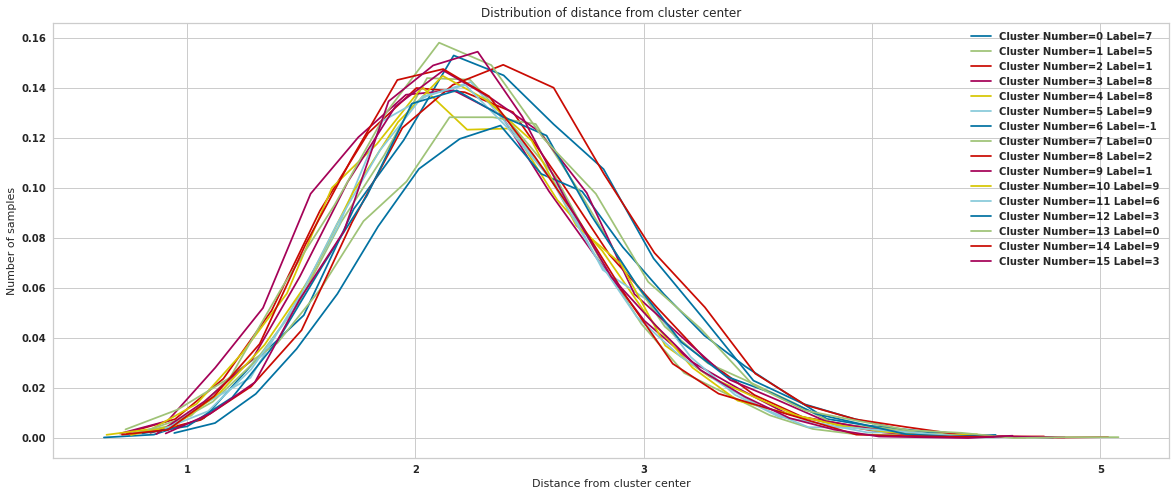

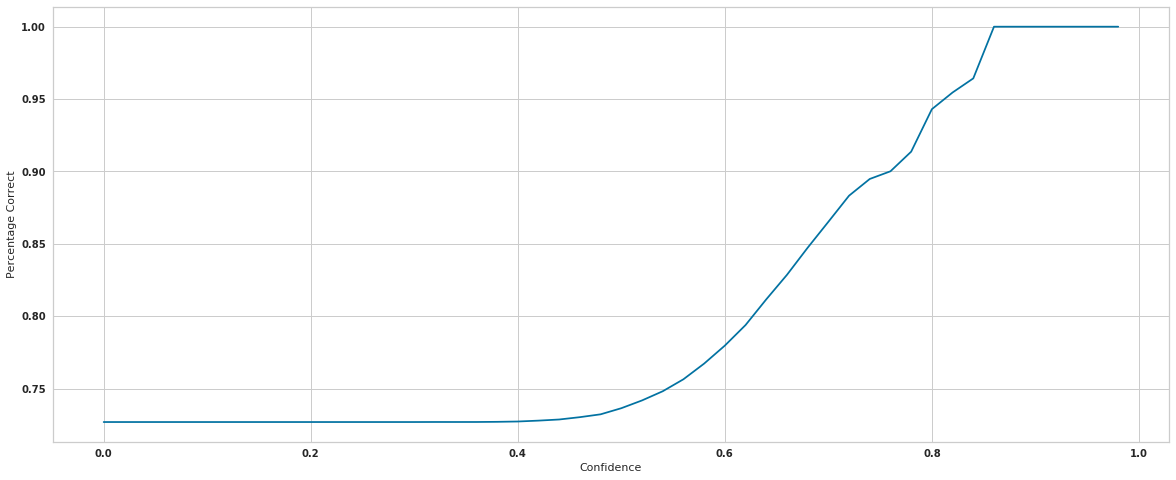

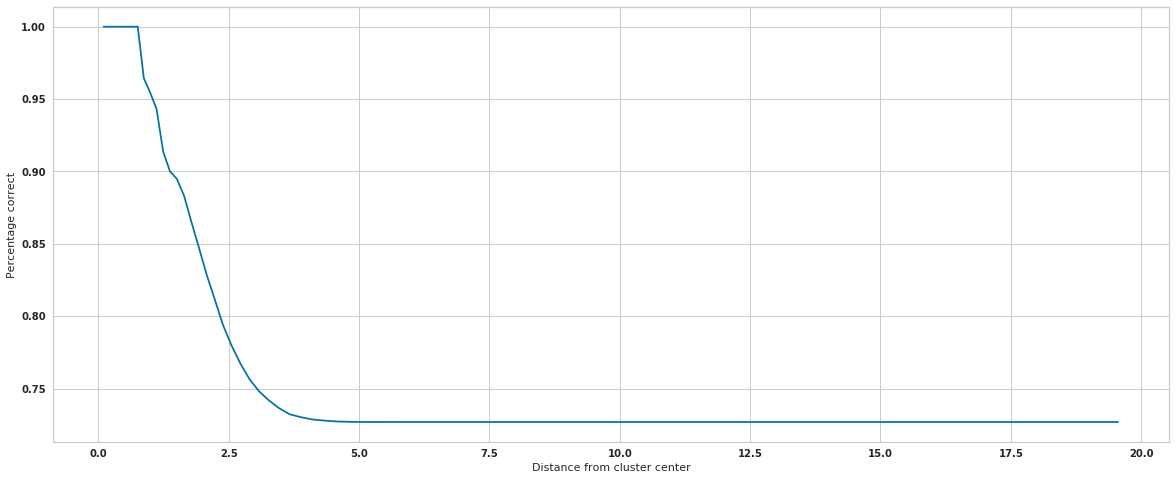

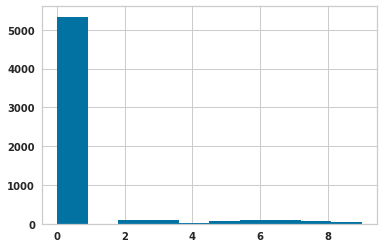

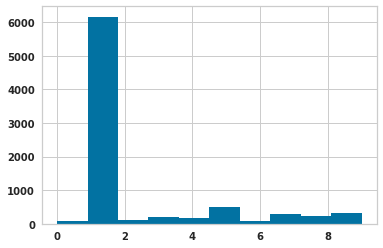

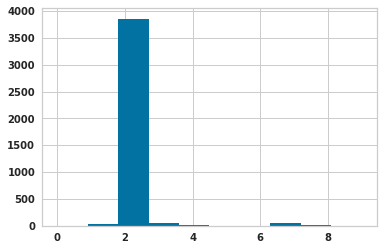

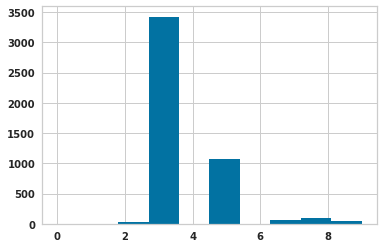

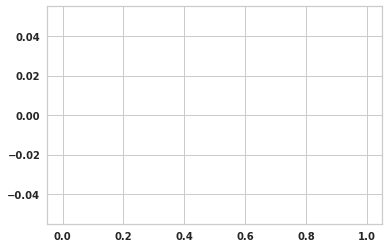

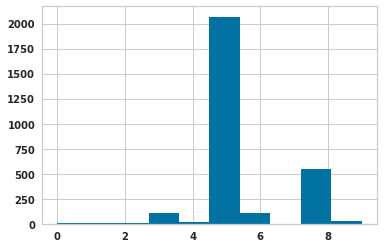

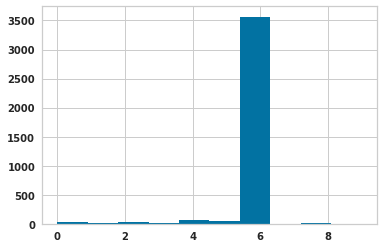

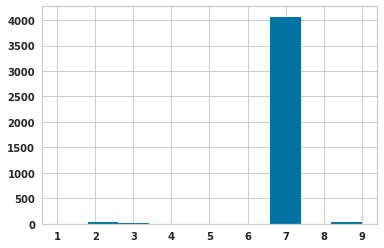

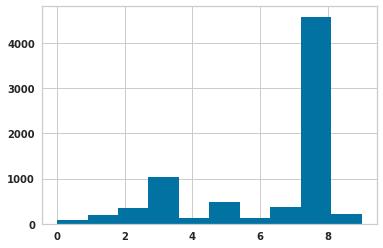

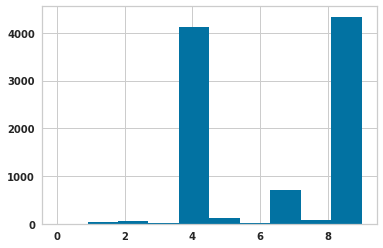

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [142]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56841
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9